# 互评作业1: 数据探索性分析与数据预处理---3220200920 刘晓晨
Github地址：https://github.com/LiuXiaochen-0920/Data-Mining
### 1. 问题描述
本次作业中，自行选择2个数据集进行探索性分析与预处理。
### 2. 数据集
所选数据集为：<br>  
* [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews)
* [Chicago Building Violations](https://www.kaggle.com/chicago/chicago-building-violations)

### 3. 数据分析要求
#### 3.1 数据可视化和摘要
* 数据摘要<br> 
标称属性，给出每个可能聚会的频数<br> 
数值属性，给出5数概括及缺失值的个数<br> 

* 数据可视化<br> 
使用直方图、盒图等检查数据分布及离群点<br> 

#### 3.2 数据缺失的处理
观察数据集中缺失数据，分析其缺失的原因。分别使用下列四种策略对缺失值进行处理:<br> 

* 将缺失部分剔除
* 用最高频率值来填补缺失值
* 通过属性的相关关系来填补缺失值
* 通过数据对象之间的相似性来填补缺失值<br> 
注意：在处理后，要可视化地对比新旧数据集。

# 分析过程报告

In [34]:
import re
import sys
import csv
import json
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [35]:
"""
数据摘要
    标称属性，给出每个可能聚会的频数
    数值属性，给出5数概括及缺失值的个数
"""

# 获取数据表的基本信息，包括行列属性和形状
def columns_info(df,show_shape=True,new_df=None):
    print(df.info())
    if show_shape: print(df.shape) 
    if new_df is not None:
        print();
        print(new_df.info())
        if show_shape: print(new_df.shape)  
    return None

# 标称属性每个可能取值的频数及直方图 前50个
def nominal_summary(df,nominal_index=None,head_n=50,new_df=None):
    # 根据频数绘制直方图
    def bar_describe(data,new_data=None,head_n=50):
        if new_data is None:
            plt.figure(figsize=(24,8))
            #标题及横纵轴
            plt.title(data.name, fontsize=30)    
            plt.bar(data.index[:head_n], data.values[:head_n])
            plt.xticks(rotation=90)
            plt.show()
        else:
            plt.figure(figsize=(24,8))
            plt.title(data.name, fontsize=30)    
            plt.bar(data.index[:head_n], data.values[:head_n],color='b',label=data.name)
            plt.bar(new_data.index[:head_n],new_data.values[:head_n],color='r',label='new_'+new_data.name)
            plt.xticks(rotation=90)
            plt.legend()
            plt.show()
            
    # 获取数据中每个取值的频数
    frequency = {key: df[key].value_counts() for key in df.columns}
    new_frequency = None
    if new_df is not None:
        new_frequency = {key: new_df[key].value_counts() for key in new_df.columns}
    if nominal_index is None:
        nominal_index=df.columns
    if new_frequency is None:
        for key in nominal_index:
            bar_describe(data=frequency[key],new_data=None,head_n=head_n)
    else:
        for key in nominal_index:
            bar_describe(data=frequency[key],new_data=new_frequency[key],head_n=head_n)
    return None

# 数值属性五数概括及缺失值个数
def numerical_summary(df,numerical_index=None,new_df=None):
    shape=df.shape 
    
    # 格式化输出五数概括和缺失值个数
    def data_describe(data,new_data=None):
        print('descriptive statistics (%s):' % data.name)
        info=data.describe()
        new_info = None
        if new_data is not None:
            new_info = new_data.describe()
            
        # 五数概括，直接利用函数计算
        print("Min: {:.4f}\tQ1(25%): {:.4f} \tQ2(50%): {:.4f} \tQ3(75%): {:.4f} \tMax: {:.4f}".format(
            info['min'],info['25%'],info['50%'],info['75%'],info['max']))
        # 缺失值为总行数-有值得行数
        print("Missing: {:d}".format(int(shape[0] - info['count'])))
        print()
        
        if new_info is not None:
            print("\033[95m new Min: {:.4f}\tQ1(25%): {:.4f} \tQ2(50%): {:.4f} \tQ3(75%): {:.4f} \tMax: {:.4f} \033[0m".format(
            new_info['min'],new_info['25%'],new_info['50%'],new_info['75%'],new_info['max']))
            print("\033[95m new Missing: {:d} \033[0m".format(int(shape[0] - new_info['count'])))
            print()
        
    if numerical_index is None:
        print("Please provide the numerical index needed to be describe")
        return None
    
    # 获取数值属性的5数概况和缺失值个数
    if new_df is None:
        for key in numerical_index:
            data_describe(df[key])
    else:
        new_shape=new_df.shape 
        for key in numerical_index:
            data_describe(df[key],new_df[key])
    
    return None

In [36]:
"""
数据可视化
    使用直方图、盒图等检查数据分布及离群点
"""

# 数据可视化，用于绘制数值属性的直方图，盒图及散点图
def box_plot(df,ylabel=None,new_df=None):
    if new_df is None:
        plt.figure()
        plt.title('Boxplot')
        sns.boxplot(y=ylabel,data=df,palette='Set2')
    else:
        plt.figure(figsize=(14,8))
        plt.subplot(121)
        plt.title('Boxplot')
        sns.boxplot(y=ylabel,data=df,palette='Set1')

        plt.subplot(122)
        plt.title('new_Boxplot')
        sns.boxplot(y=ylabel,data=new_df,palette='Set2')
    
def hist_plot(df,ylabel=None,bins=10,new_df=None):
    if ylabel is None:
        print("Please provide ylabel")
        return None
    if new_df is None:
        plt.figure()
        plt.title('Histogram')
        sns.distplot(a=df[ylabel].dropna(),bins=bins,hist=True,kde=False)
    else:
        plt.figure(figsize=(14,8))
        plt.subplot(121)
        plt.title('Histogram')
        sns.distplot(a=df[ylabel].dropna(),bins=bins,hist=True,kde=False)

        plt.subplot(122)
        plt.title('new_Histogram')
        sns.distplot(a=new_df[ylabel].dropna(),bins=bins,hist=True,kde=False)

def scatter_plot(df,xlabel=None,ylabel=None,new_df=None):
    if xlabel is None or ylabel is None:
        print("Please provide xlabel and ylabel")
        return None
    if new_df is None:
        plt.figure()
        plt.title('Scatter plot')
        sns.scatterplot(x=xlabel,y=ylabel,data=df)
    else:
        plt.figure(figsize=(14,8))
        plt.subplot(121)
        plt.title('Scatter plot')
        sns.scatterplot(x=xlabel,y=ylabel,data=df)

        plt.subplot(122)
        plt.title('new Scatter plot')
        sns.scatterplot(x=xlabel,y=ylabel,data=new_df)

def viz_pairs(df,ylabel=None,xlabel=None,bins=20,new_df=None):
    if ylabel is None or xlabel is None:
        print("Please provide xlabel and ylabel")
        return None
    box_plot(df,ylabel=ylabel,new_df=new_df)
    box_plot(df,ylabel=xlabel,new_df=new_df)
    hist_plot(df,ylabel=ylabel,bins=bins,new_df=new_df)
    hist_plot(df,ylabel=xlabel,bins=bins,new_df=new_df)
    scatter_plot(df,xlabel=xlabel,ylabel=ylabel,new_df=new_df)

In [37]:
"""
数据缺失值处理
    1. 将缺失部分剔除
    2. 用最高频率值来填补缺失值
    3. 通过属性的相关关系来填补缺失值
    4. 通过数据对象之间的相似性来填补缺失值
"""    
#1.将缺失部分剔除
def miss_drop(df):
    return df.dropna(axis=0,inplace=False)

#2.用最高频率值来填补缺失值
def miss_mode_fill(df):
    cpdf = df.copy(deep=True)
    for key in cpdf.columns:
        cpdf[key].fillna(cpdf[key].mode()[0],inplace=True)
    return cpdf

#3.通过属性的相关关系来填补缺失值
def attr_corr_fill(df,miss_index,complete_index):
    def set_miss_values(df, complete_index):
        enc_label = OrdinalEncoder()
        enc_fea = OrdinalEncoder()
        missing_index = complete_index[0]
    
        # 将现有的数值数据(No NaN)放入随机森林回归器中
        train_df = df[complete_index]
        # 已知、未知
        known_values = np.array(train_df[train_df[missing_index].notnull()])
        unknow_values = np.array(train_df[train_df[missing_index].isnull()])
    
        # y是已知的丢失索引
        y = known_values[:, 0].reshape(-1, 1)
        enc_label.fit(y)
        y = enc_label.transform(y)
    
        # X为特征
        X = known_values[:, 1:]
        test_X = unknow_values[:, 1:]
        all_X = np.row_stack((X,test_X))
        enc_fea.fit(all_X)
        X = enc_fea.transform(X)
    
        # 调整
        rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
        rfr.fit(X, y.ravel())
        # 预测
        predicted_values = rfr.predict(enc_fea.transform(unknow_values[:, 1:]))
        predicted_values = enc_label.inverse_transform(predicted_values.reshape(-1, 1))
        # 用预测值填充
        df.loc[ (df[missing_index].isnull()), missing_index] = predicted_values
        return df
        cpdf = df.copy(deep=True)
        for i in range(0,len(miss_index)):
            complete_index.insert(0,miss_index[i])
            cpdf = set_miss_values(cpdf,complete_index)
        return cpdf

#4. 通过数据对象之间的相似性来填补缺失值
def obj_corr_fill(df,numerical_index,k=30):
    sys.setrecursionlimit(100000)  #增加操作系统的递归限制
    #开始KNN训练
    cpdf = df.copy(deep=True)
    imputed_training=fast_knn(cpdf[numerical_index].values, k=k)
    imputed_training=pd.DataFrame(data=imputed_training,columns=numerical_index)
    cpdf[numerical_index] = imputed_training[numerical_index]
    return cpdf

# 数据集1 - Wine Reviews
130k wine reviews with variety, location, winery, price, and description.
* winemag-data-130k-v2.csv contains 10 columns and 130k rows of wine reviews.  
* winemag-data_first150k.csv contains 10 columns and 150k rows of wine reviews.

## 1.1 winemag-data_first150k.csv

In [38]:
# 读取文件
wine_dir = "C:/Users/liuxiaochen/Desktop/DM-work1/1winemag"
winemag150k=pd.read_csv(wine_dir + "/winemag-data_first150k.csv",sep=',',header='infer',index_col=0) 

In [39]:
# 查看文件内部信息
columns_info(winemag150k)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB
None
(150930, 10)


## 数据摘要

In [40]:
# 标称属性
nominal_index = ['country','designation', 'province', 'region_1', 'region_2', 'variety', 'winery']
# 数值属性
numerical_index = ['points', 'price']

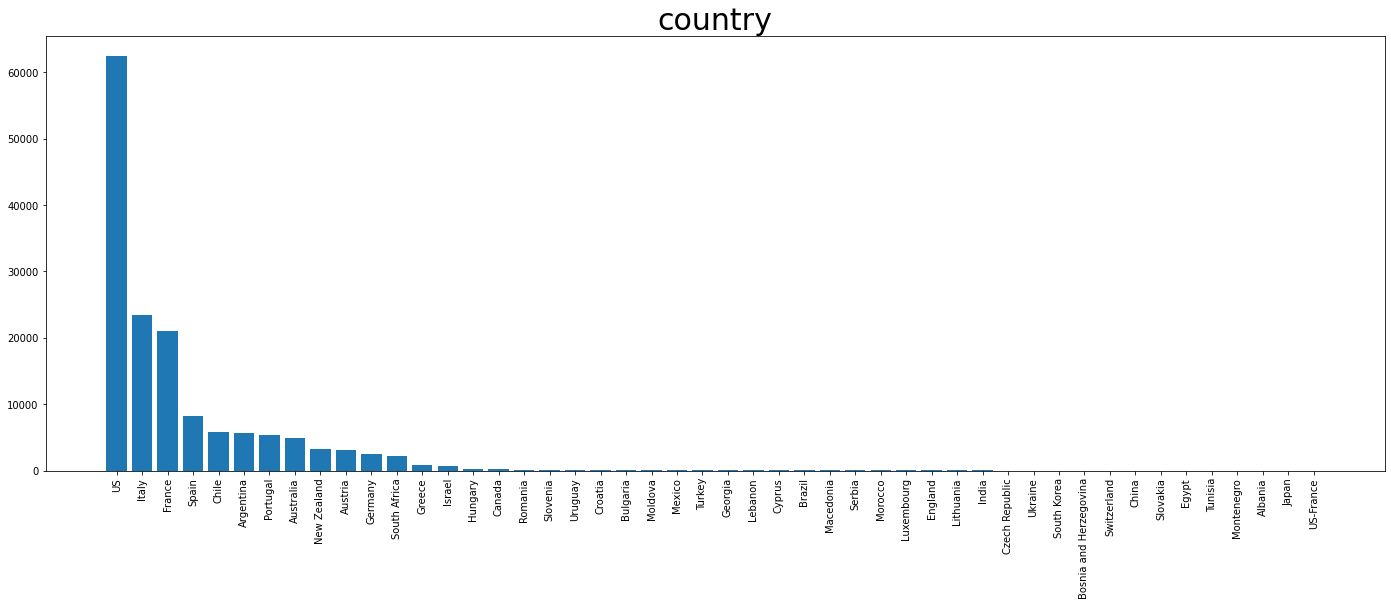

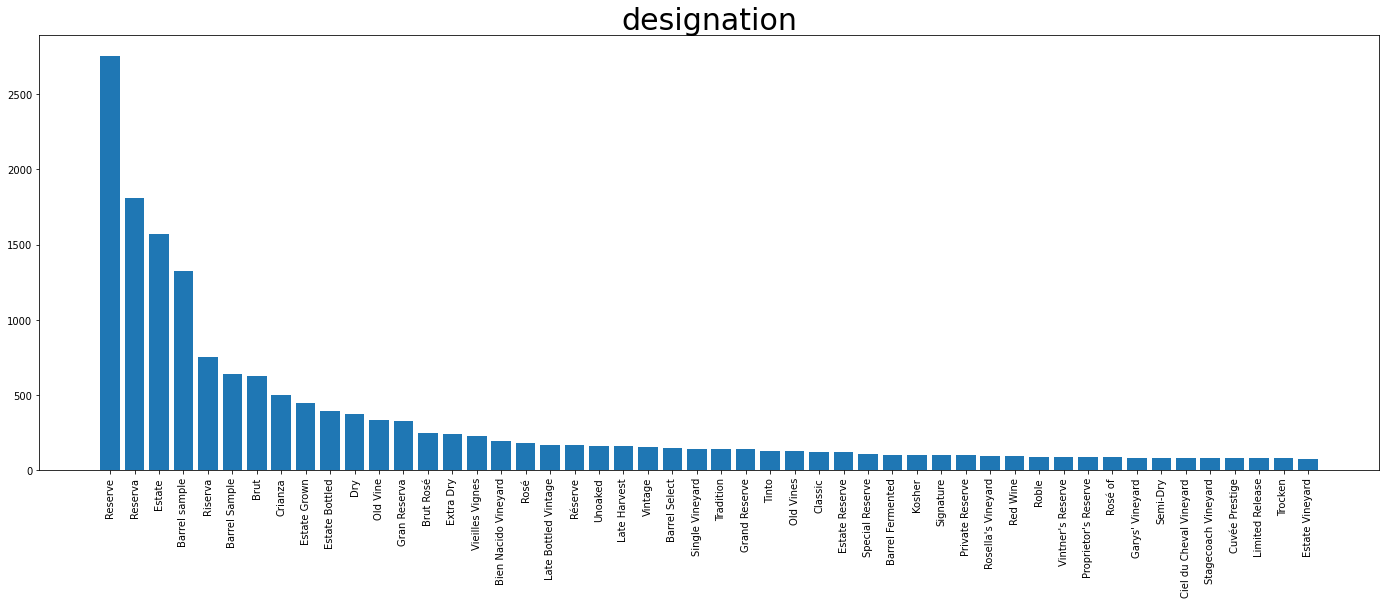

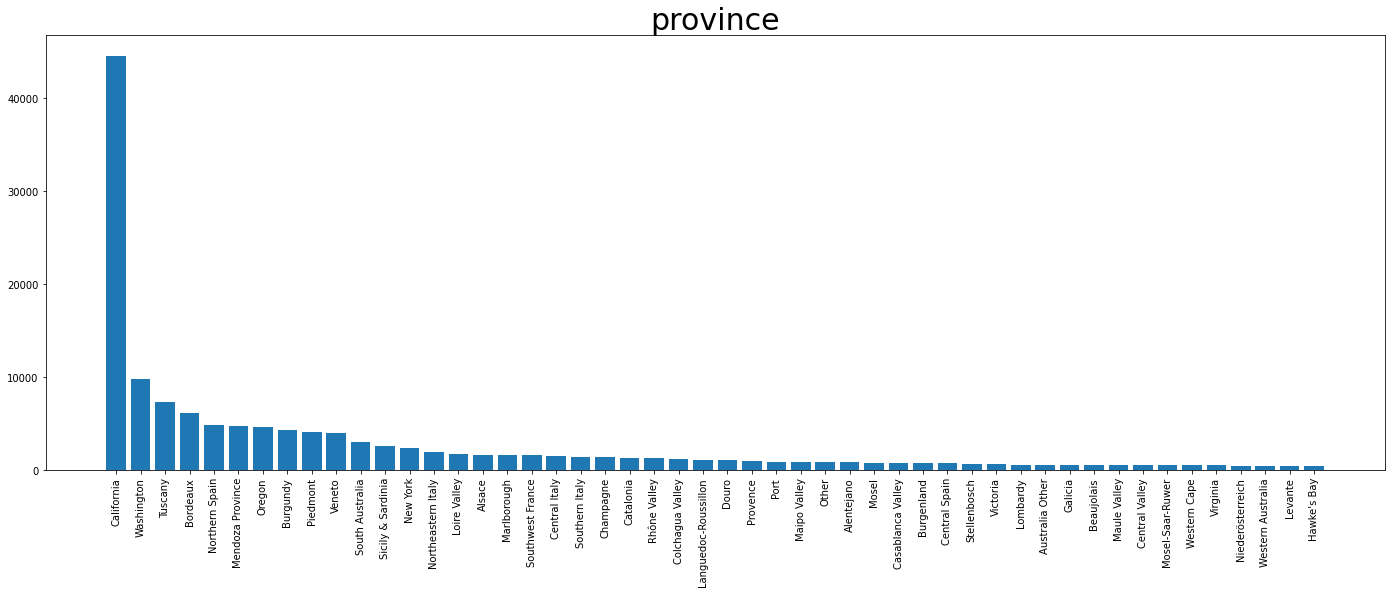

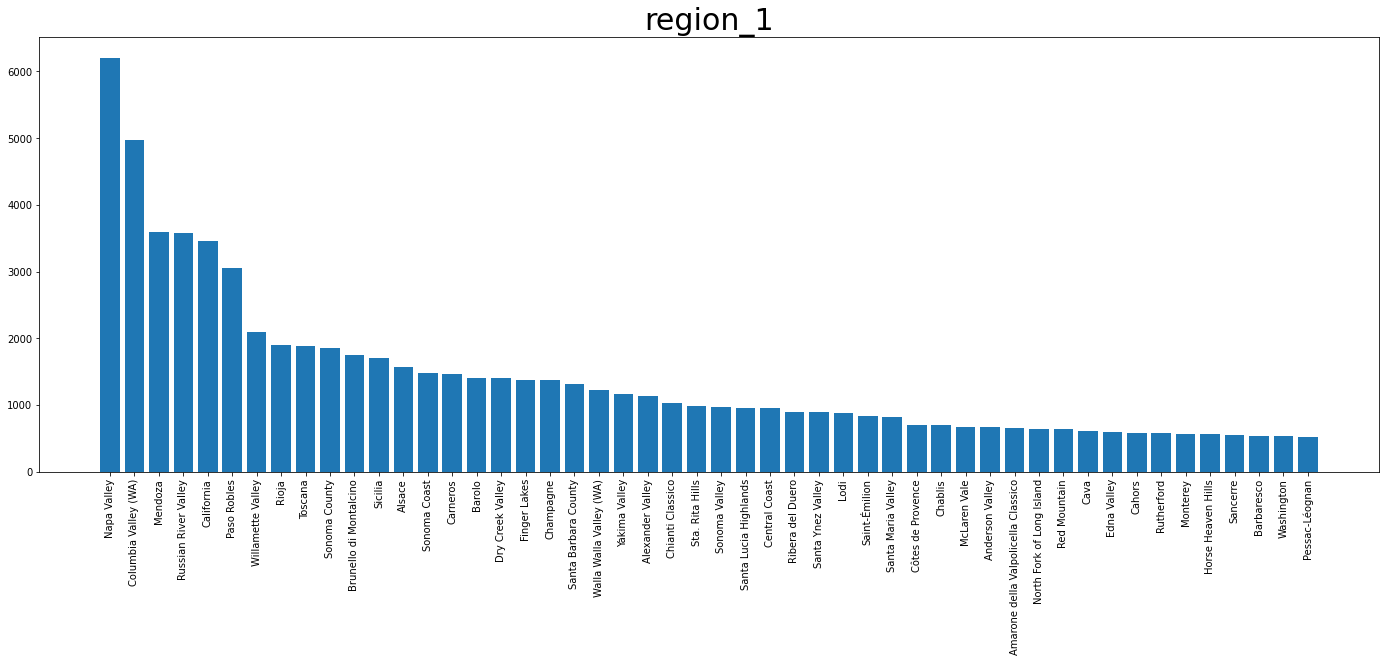

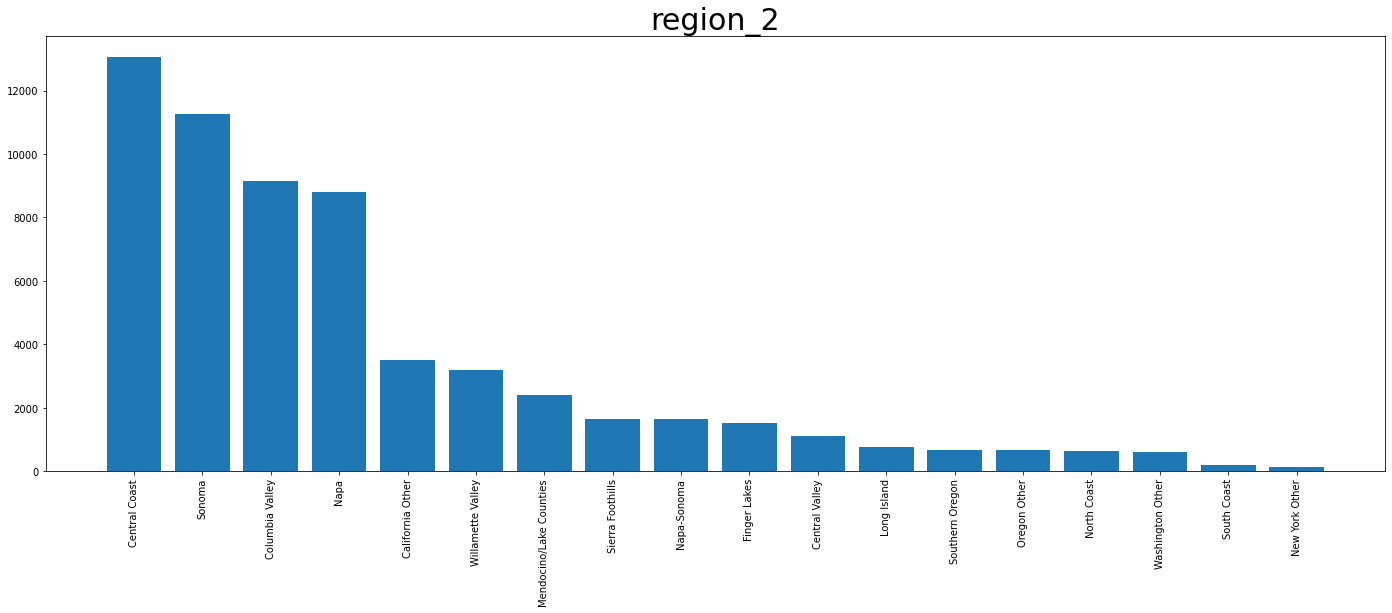

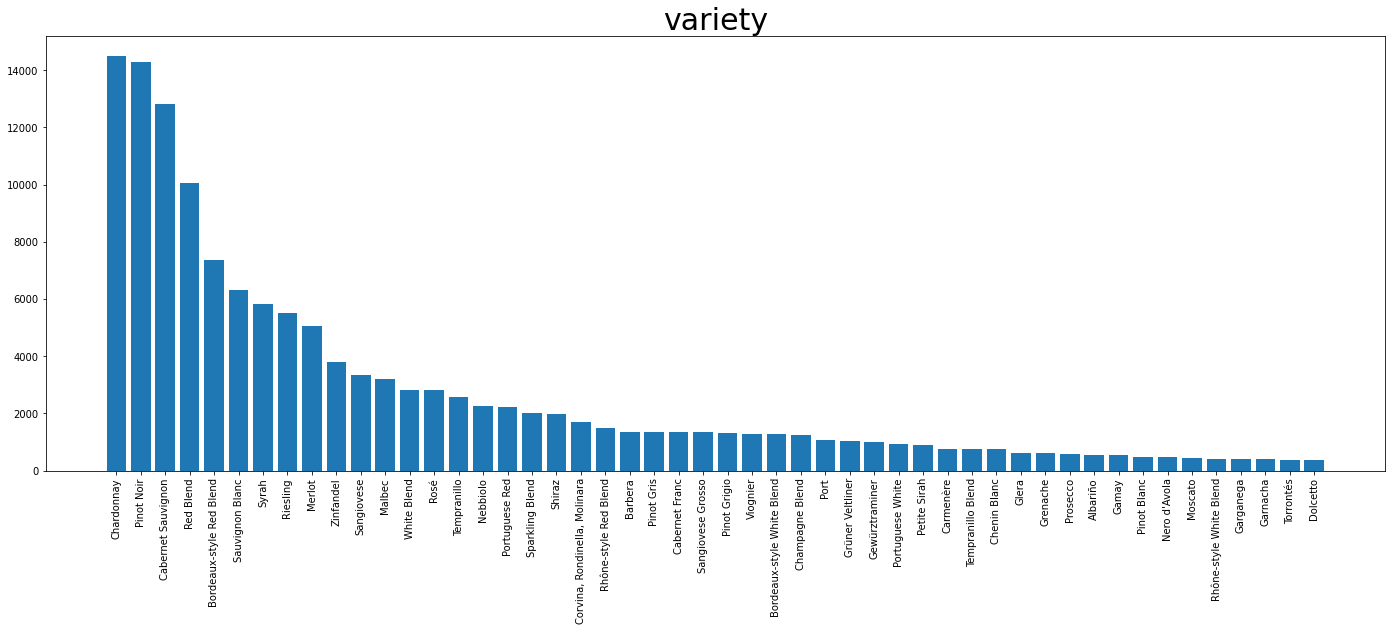

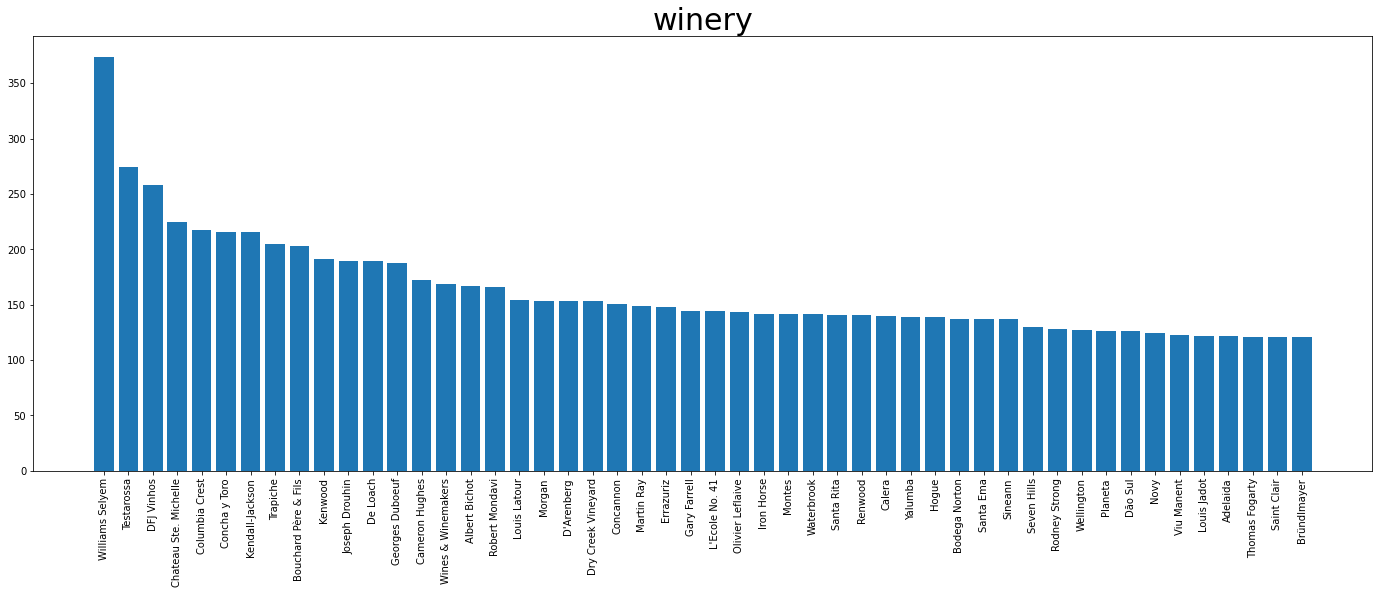

In [41]:
# 对七种标称属性进行频数的统计和可视化
nominal_summary(winemag150k,new_df=None,nominal_index=nominal_index,head_n=50)

In [42]:
# 对两种数值属性，给出5数概括及缺失值的个数
numerical_summary(winemag150k,new_df=None,numerical_index=numerical_index)

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000
Missing: 0

descriptive statistics (price):
Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000
Missing: 13695



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


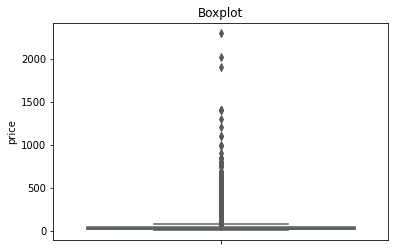

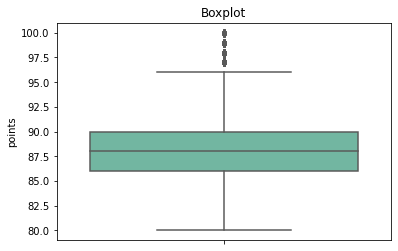

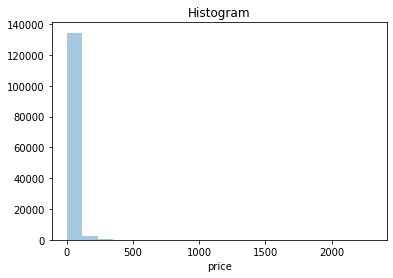

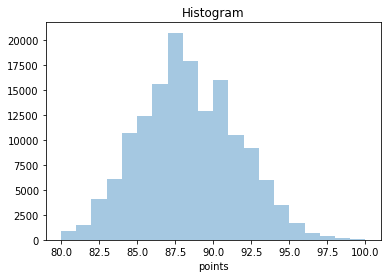

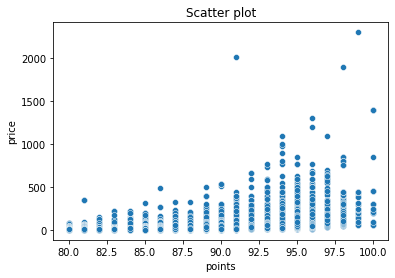

In [43]:
# 数据可视化：使用直方图、盒图等检查数据分布及离群点
viz_pairs(winemag150k,xlabel='points',ylabel='price',bins=20,new_df=None)

### 缺失值处理与对比

#### 1 将缺失部分剔除

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB
None
(150930, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39241 non-null  object 
 1   description  39241 non-null  object 
 2   designat

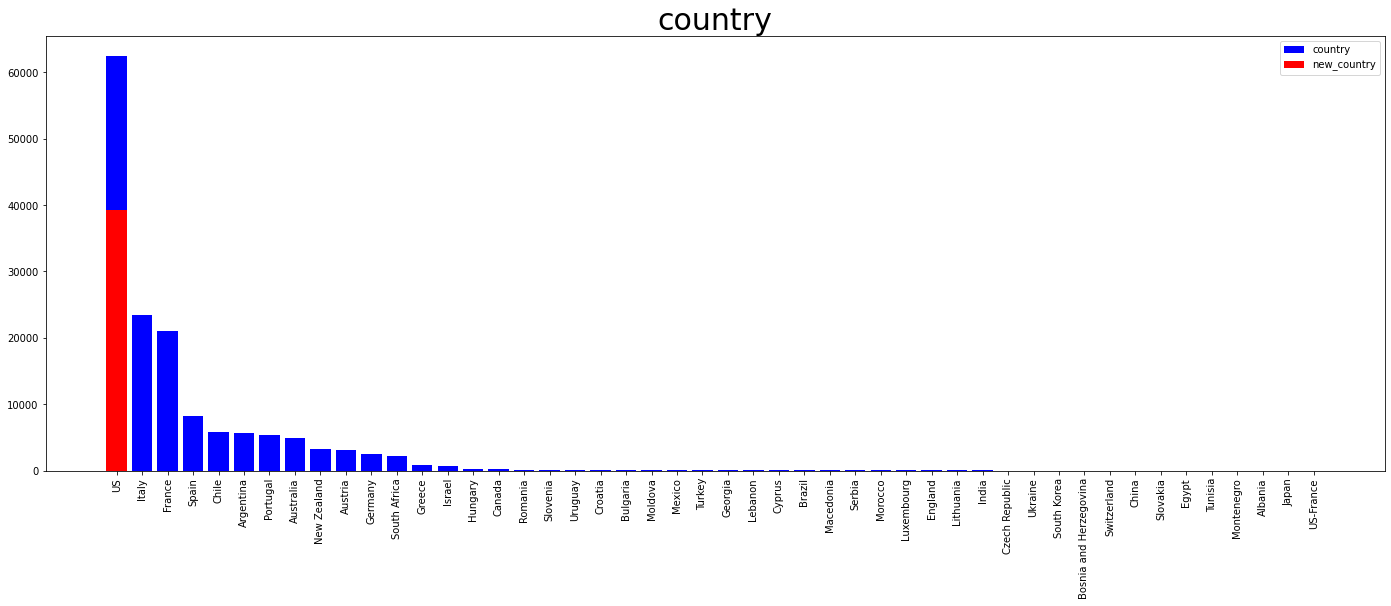

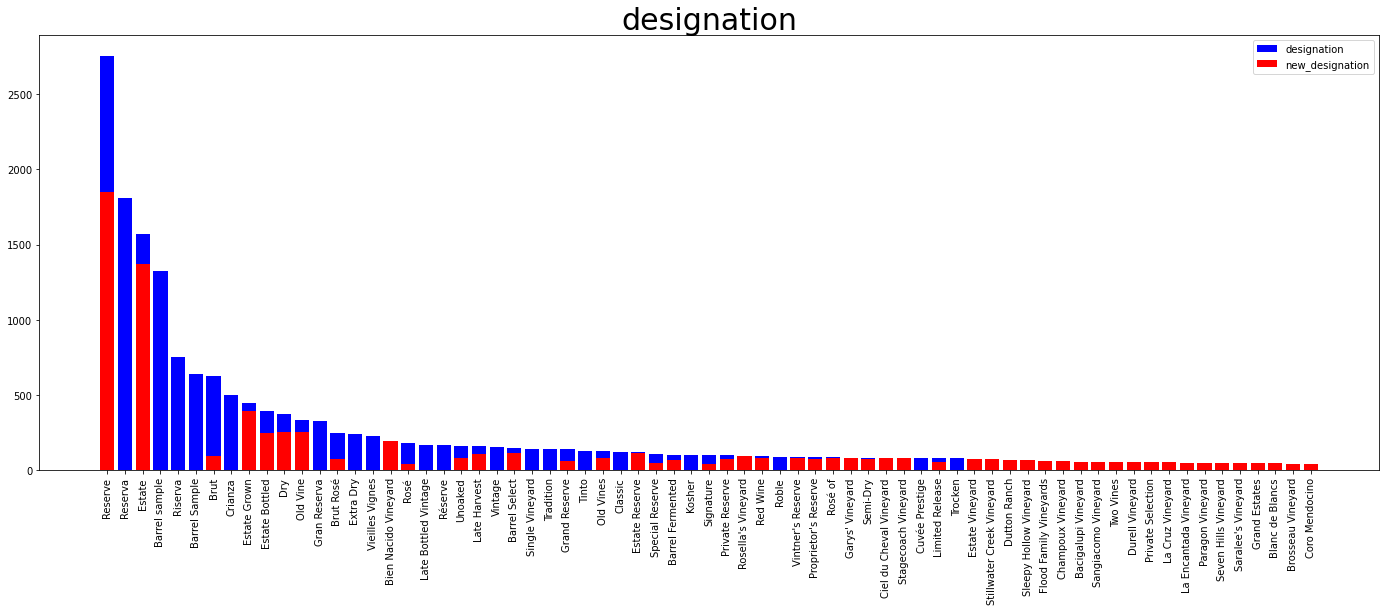

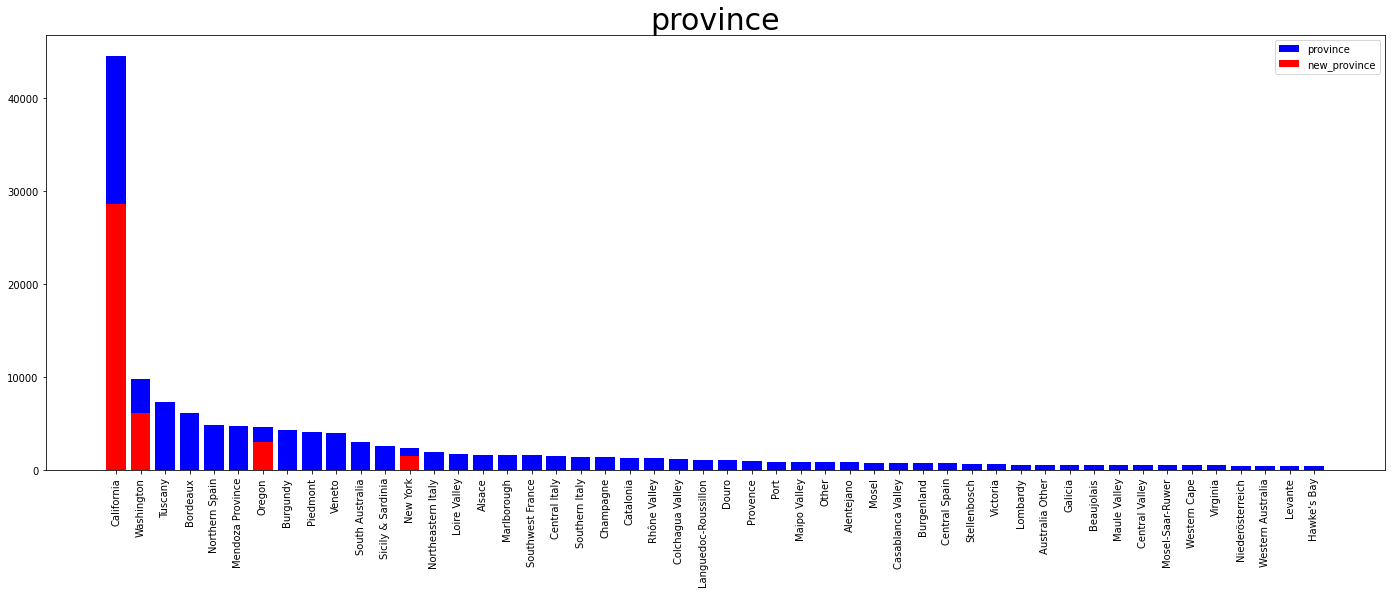

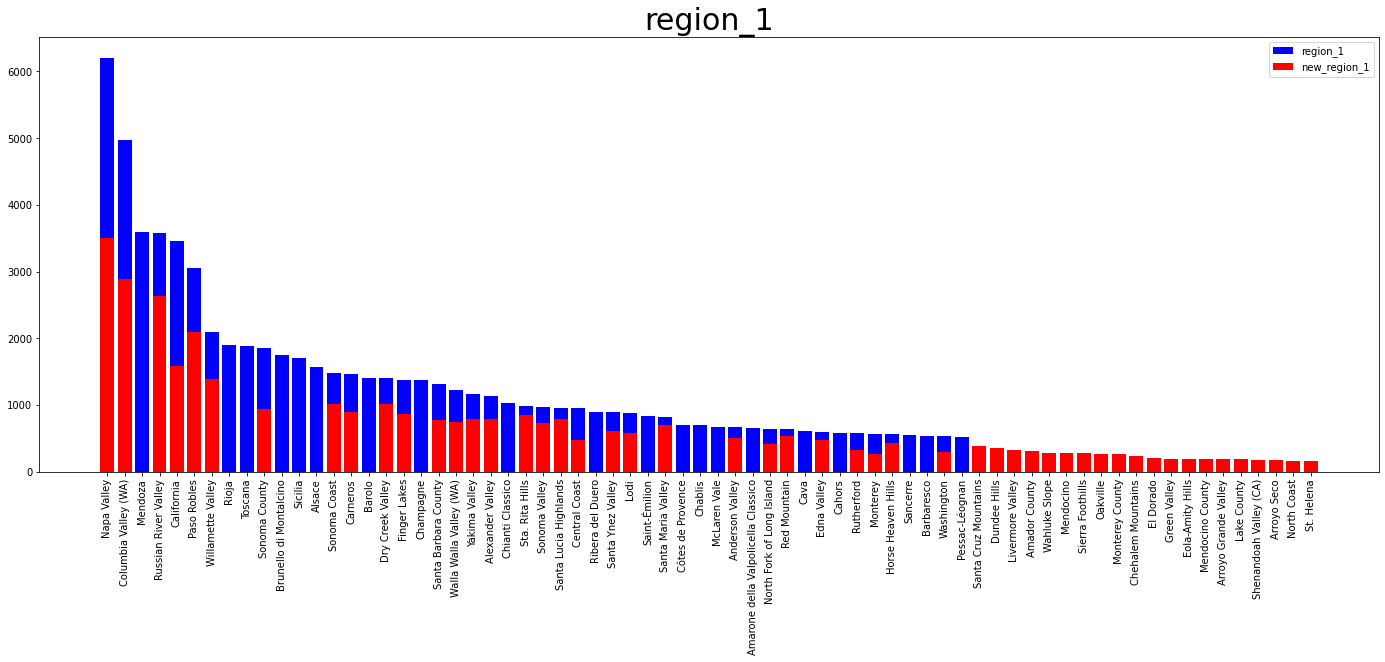

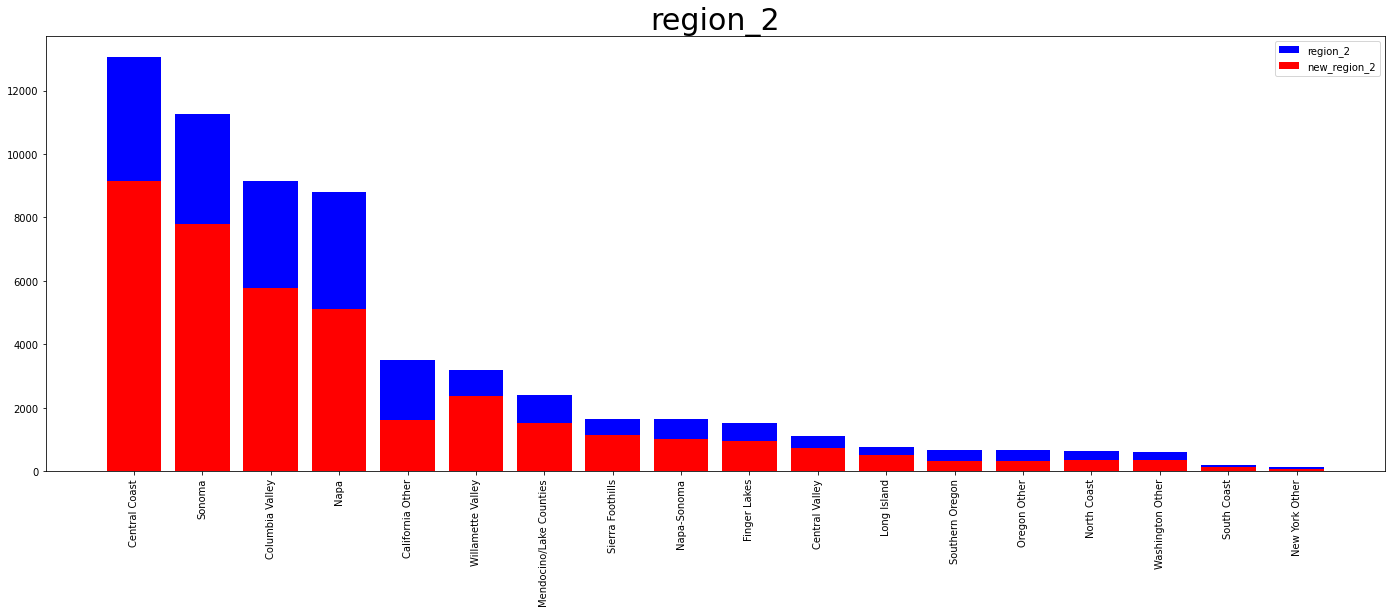

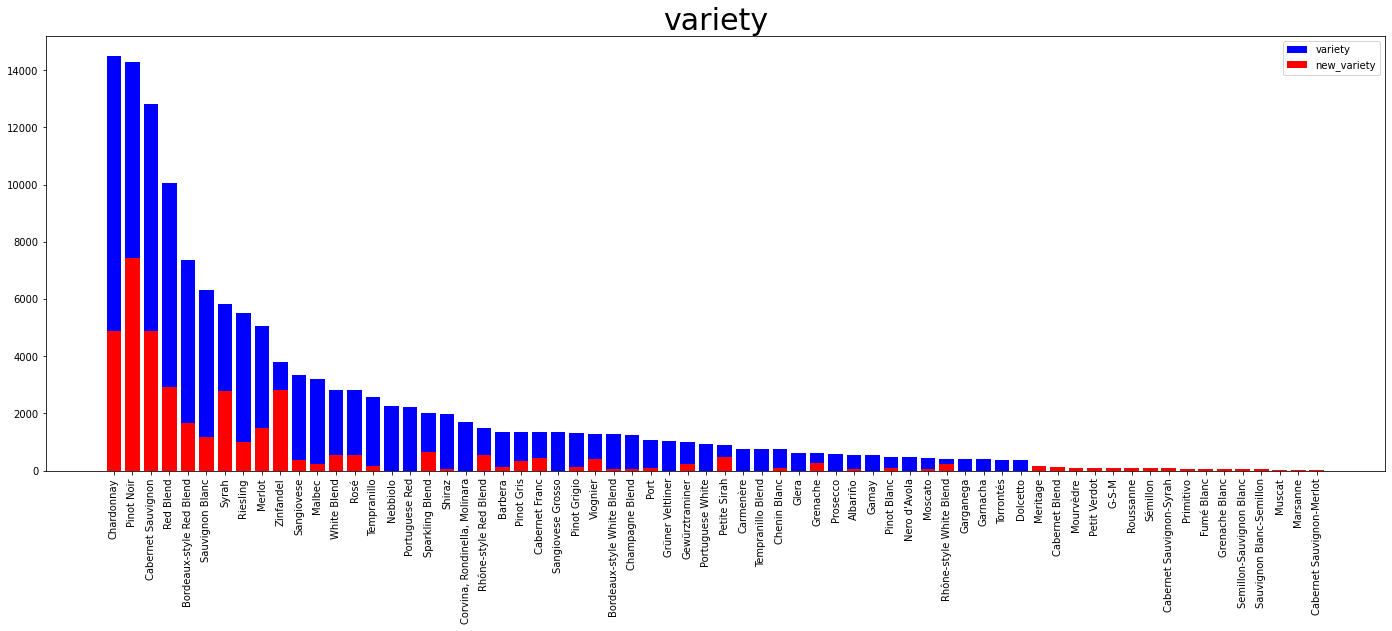

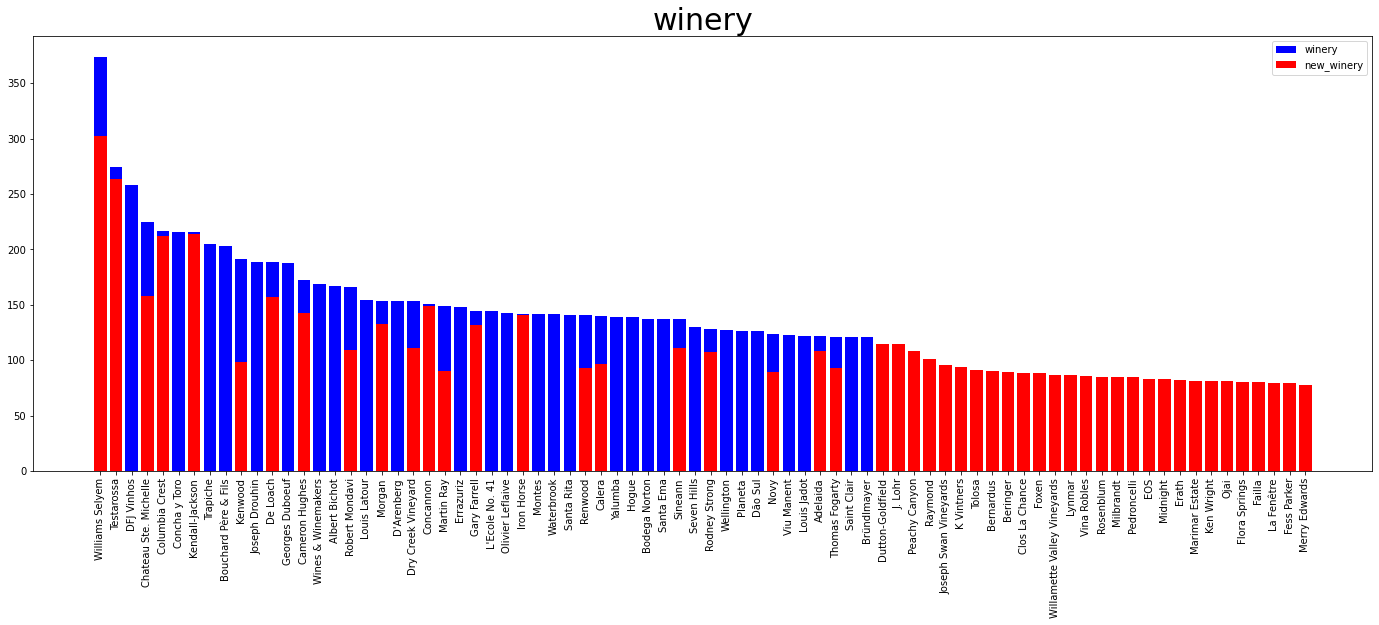

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000 
 new Missing: 111689 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000
Missing: 13695

 new Min: 4.0000	Q1(25%): 22.0000 	Q2(50%): 32.0000 	Q3(75%): 45.0000 	Max: 2013.0000 
 new Missing: 111689 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


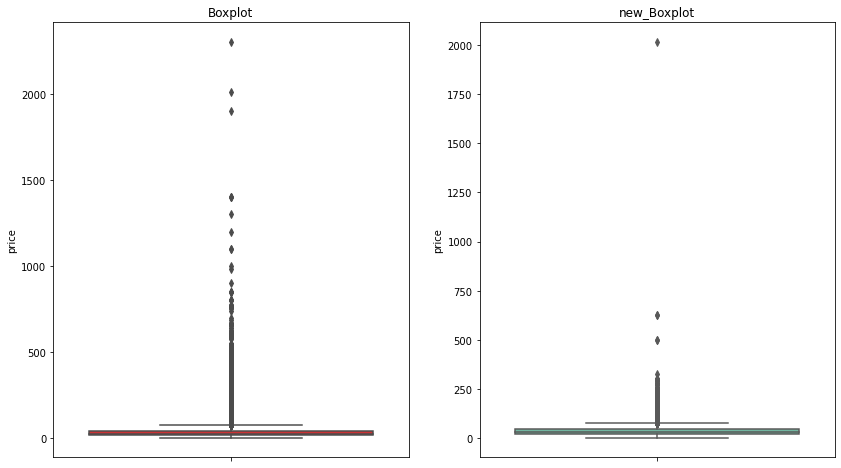

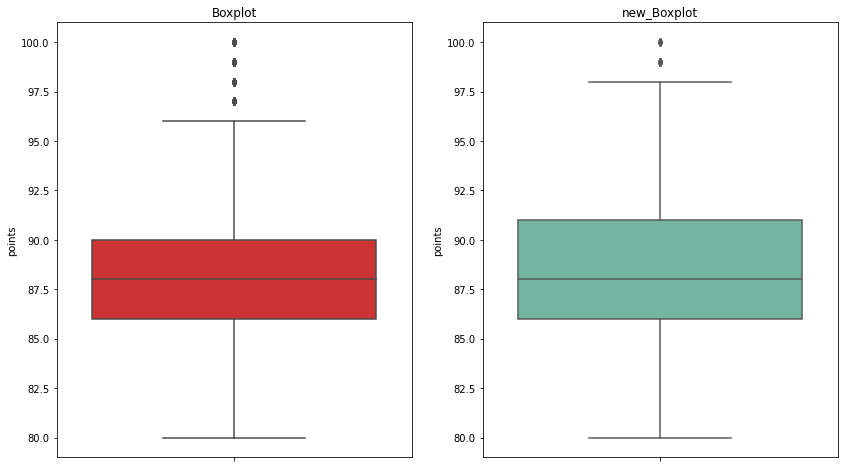

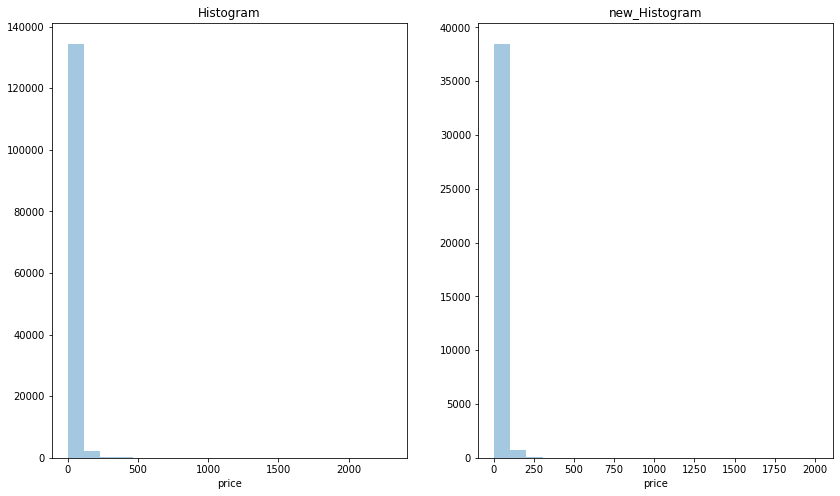

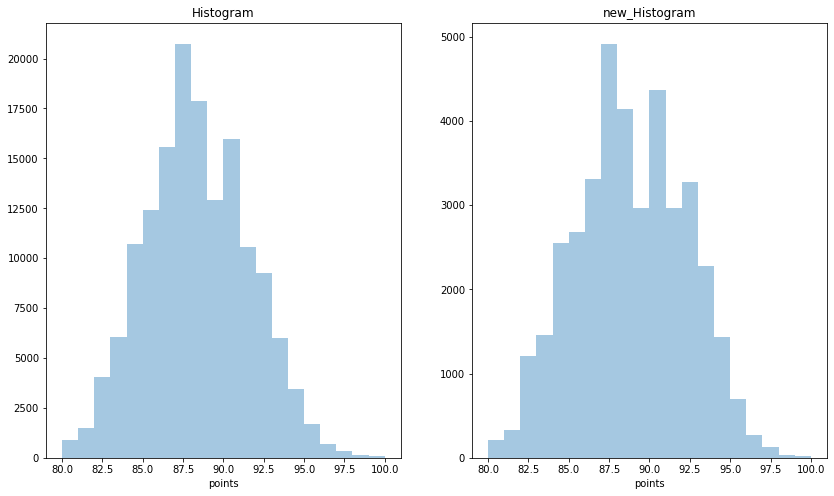

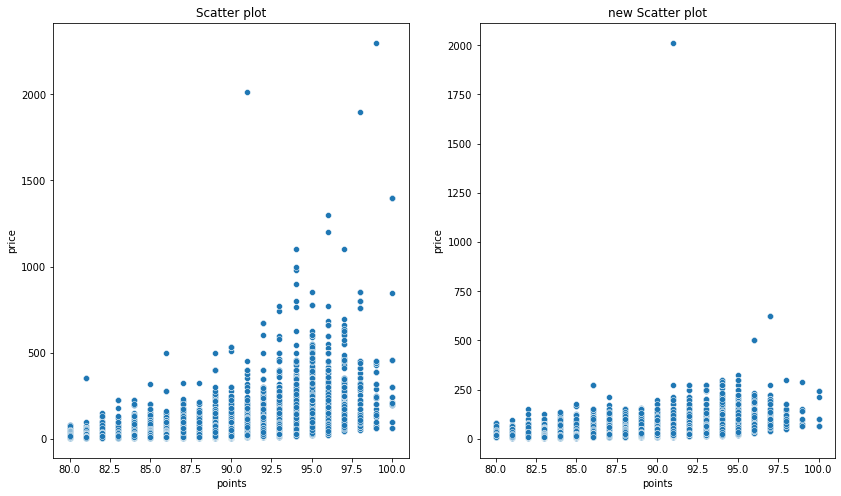

In [44]:
# 剔除
dw150k=miss_drop(winemag150k)
# 重新进行上述过程，并且做对比
columns_info(winemag150k,show_shape=True,new_df=dw150k)
nominal_summary(winemag150k,nominal_index=nominal_index,head_n=50,new_df=dw150k)
numerical_summary(winemag150k,numerical_index=numerical_index,new_df=dw150k)
viz_pairs(winemag150k,xlabel='points',ylabel='price',bins=20,new_df=dw150k)

#### 2 用最高频率值来填补缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB
None
(150930, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150930 non-null  object 
 1   description  150930 non-null  object 
 2   des

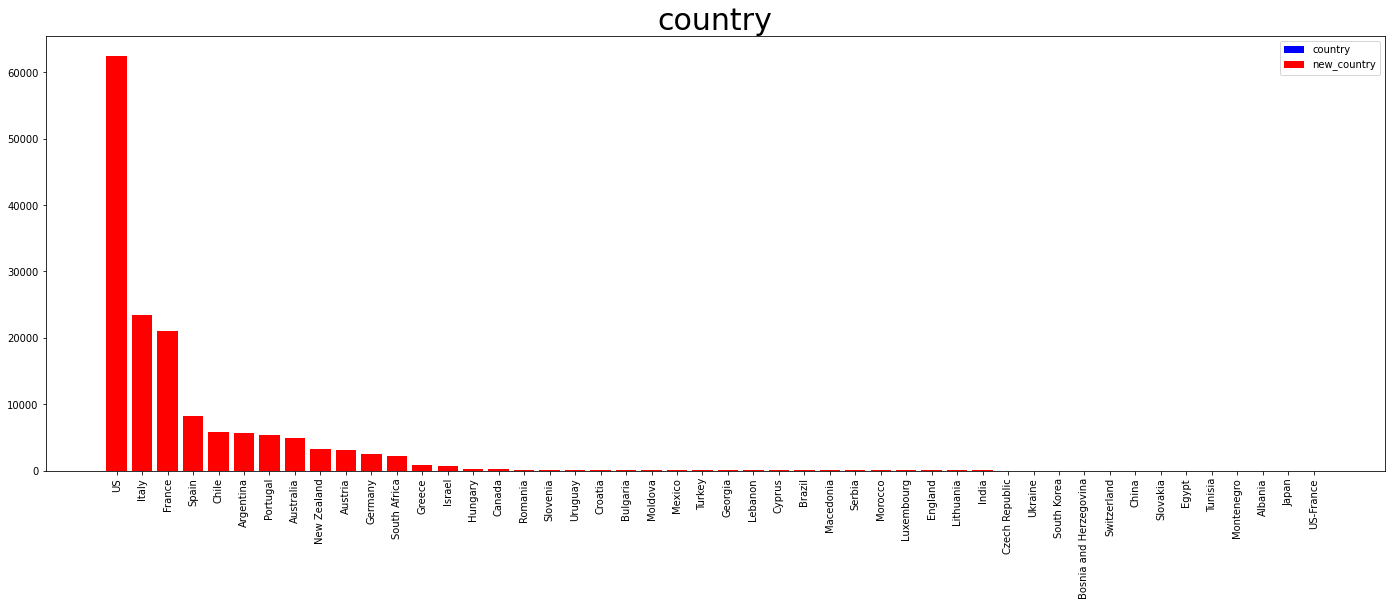

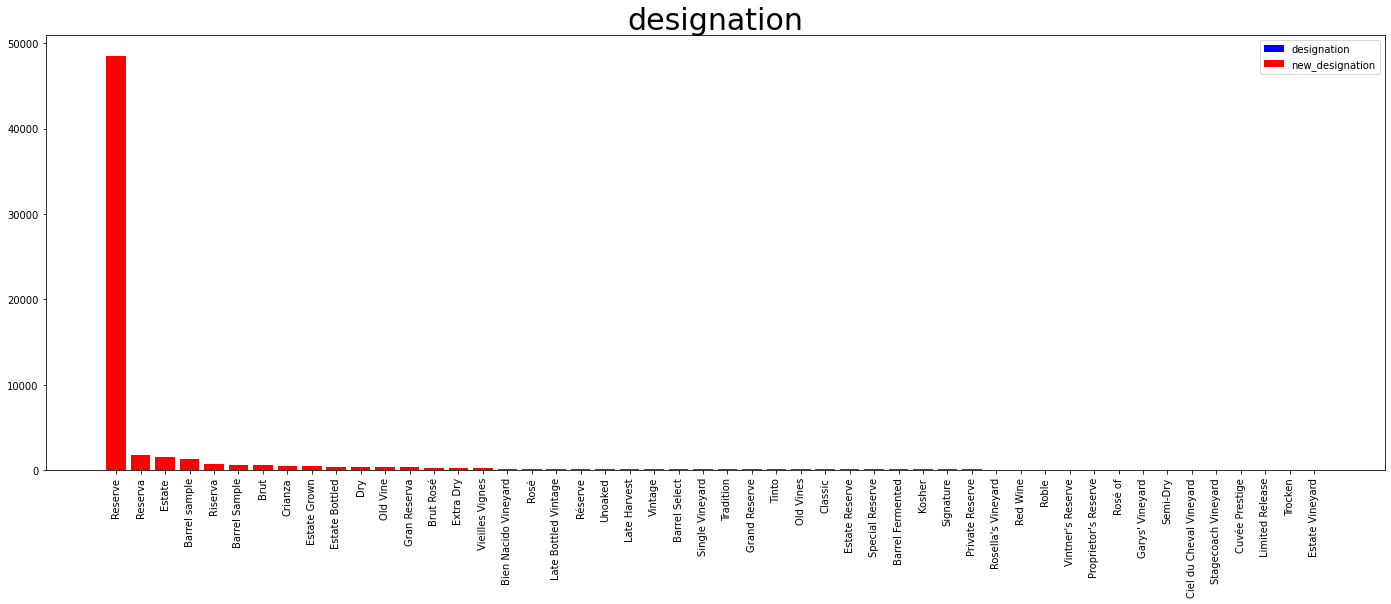

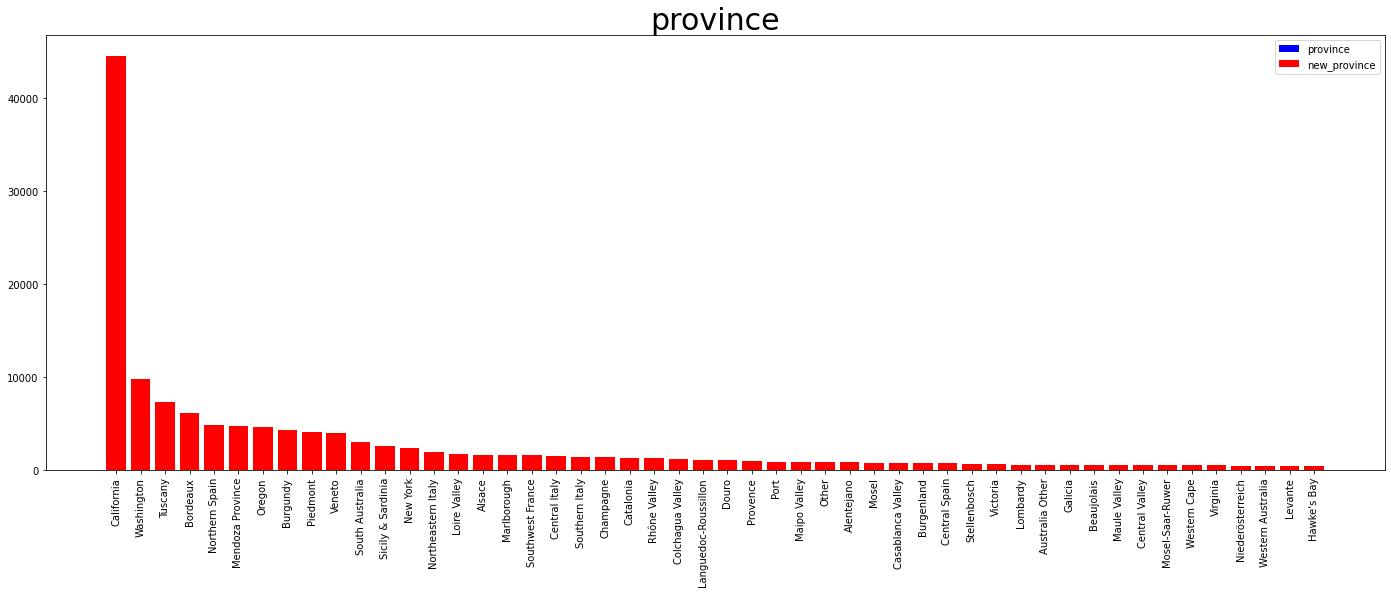

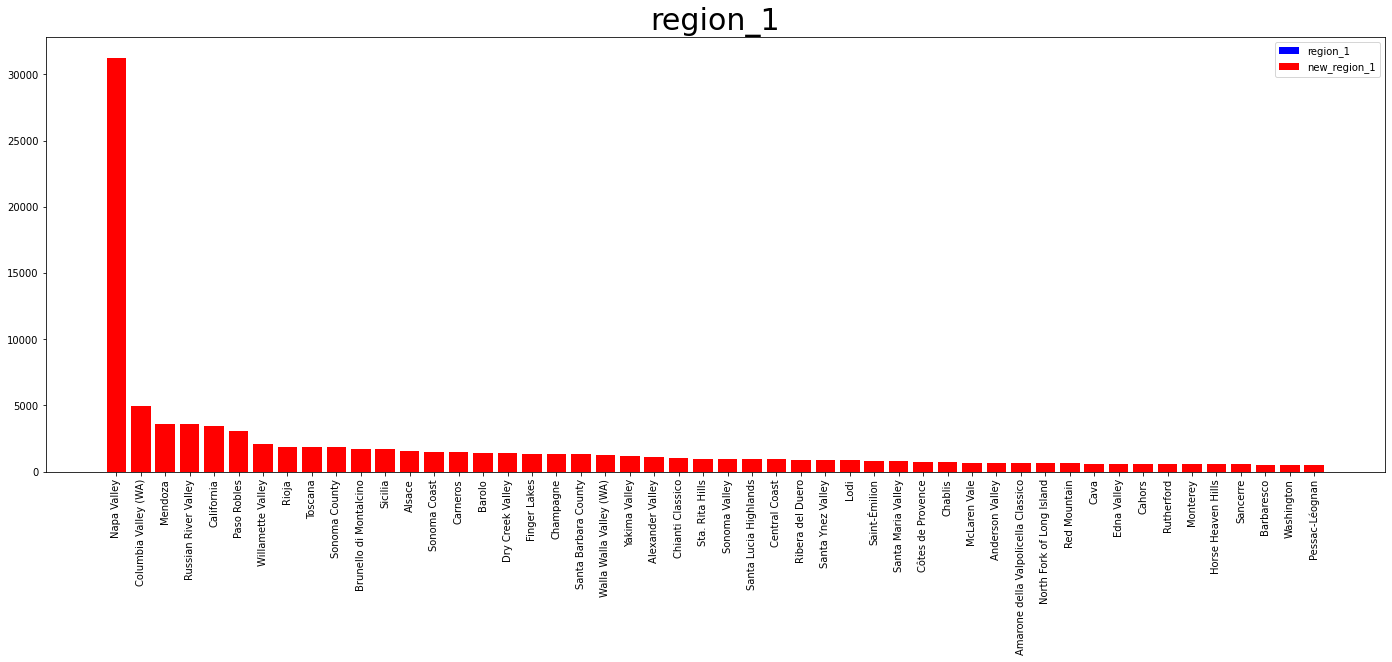

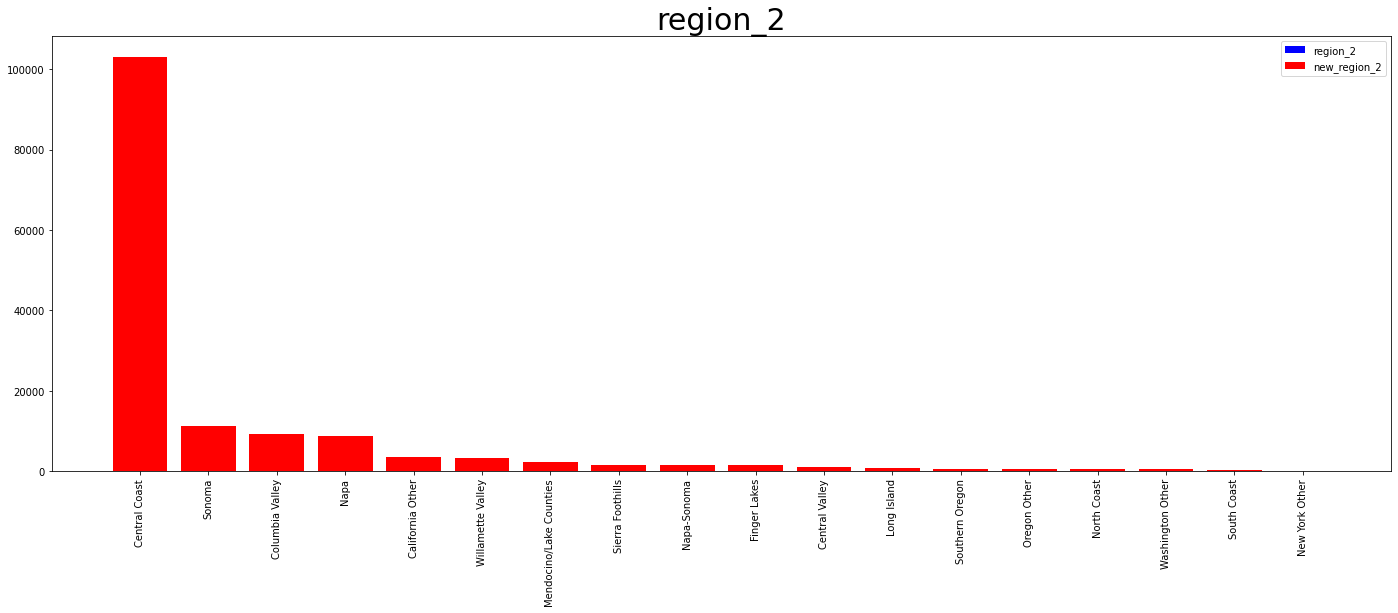

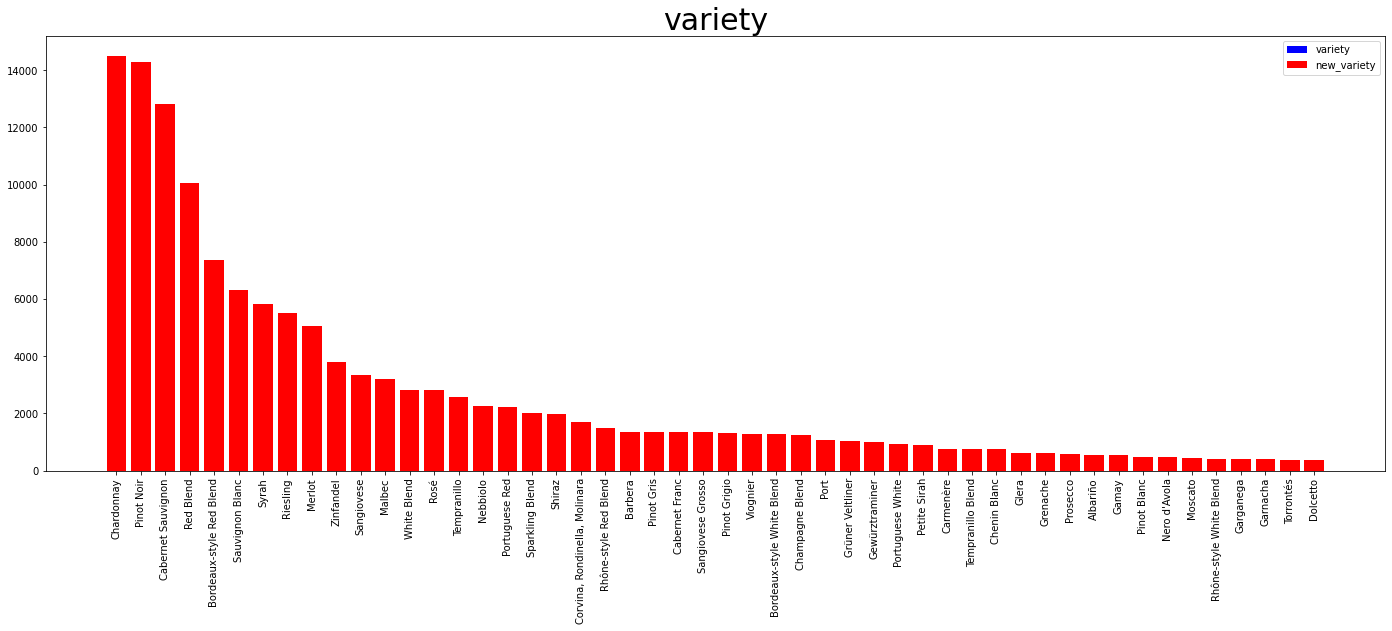

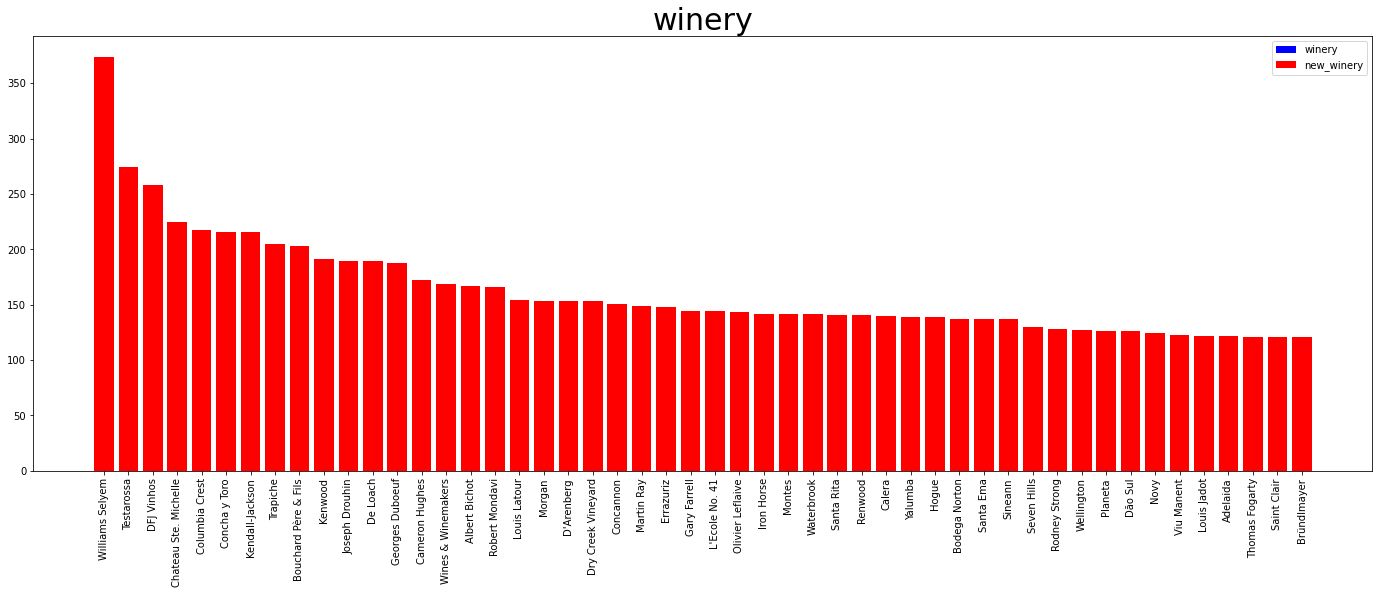

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000 
 new Missing: 0 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000
Missing: 13695

 new Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 22.0000 	Q3(75%): 38.0000 	Max: 2300.0000 
 new Missing: 0 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


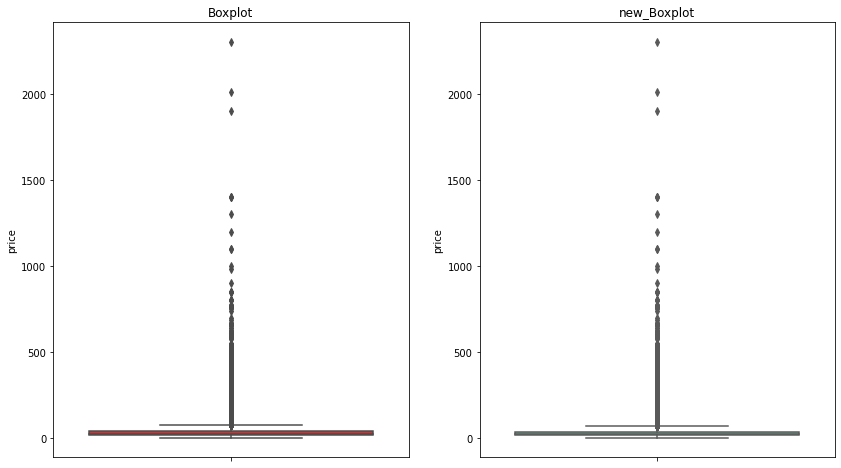

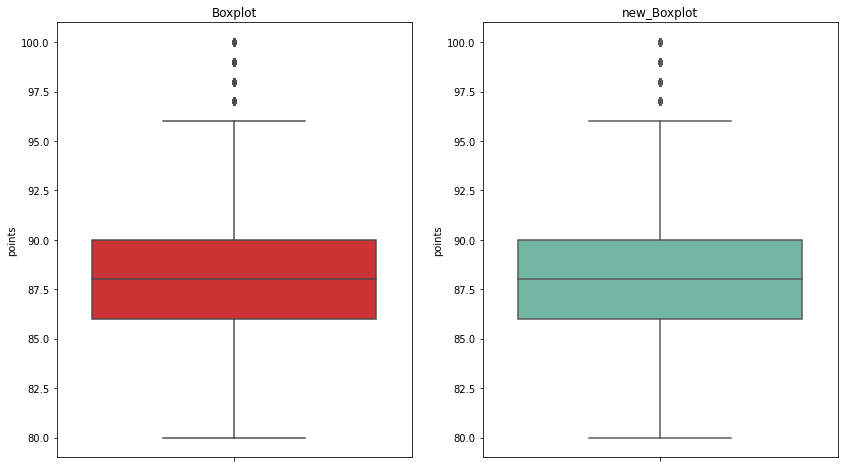

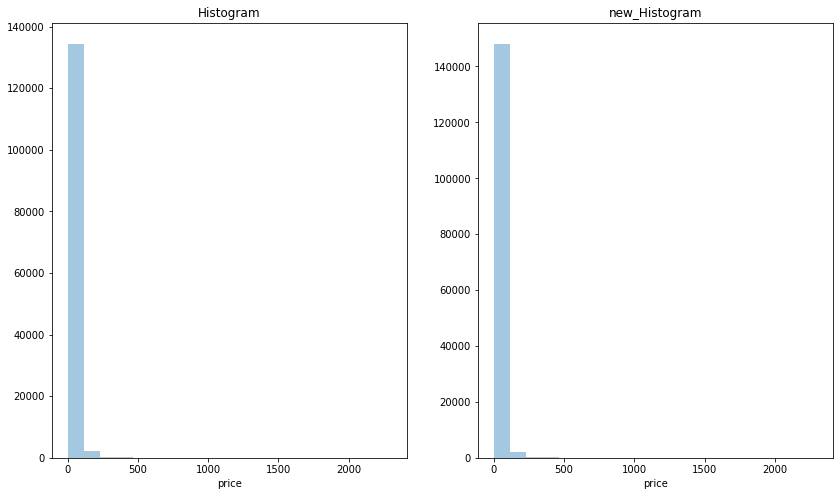

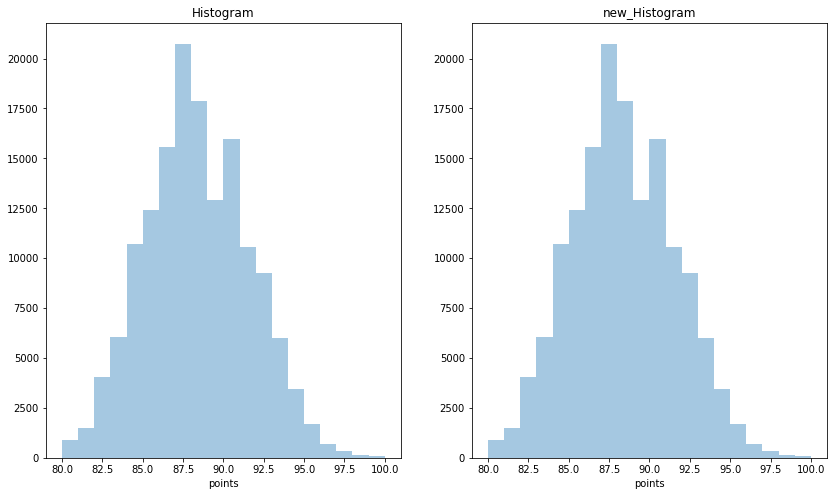

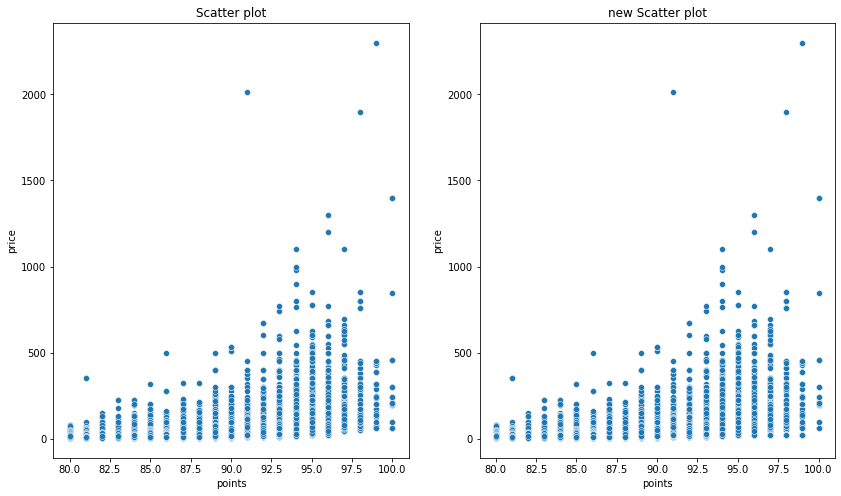

In [46]:
md150k=miss_mode_fill(winemag150k)
columns_info(winemag150k,show_shape=True,new_df=md150k)
nominal_summary(winemag150k,nominal_index=nominal_index,head_n=50,new_df=md150k)
numerical_summary(winemag150k,numerical_index=numerical_index,new_df=md150k)
viz_pairs(winemag150k,xlabel='points',ylabel='price',bins=20,new_df=md150k)

#### 3 通过属性的相关关系来填补缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB
None
(150930, 10)


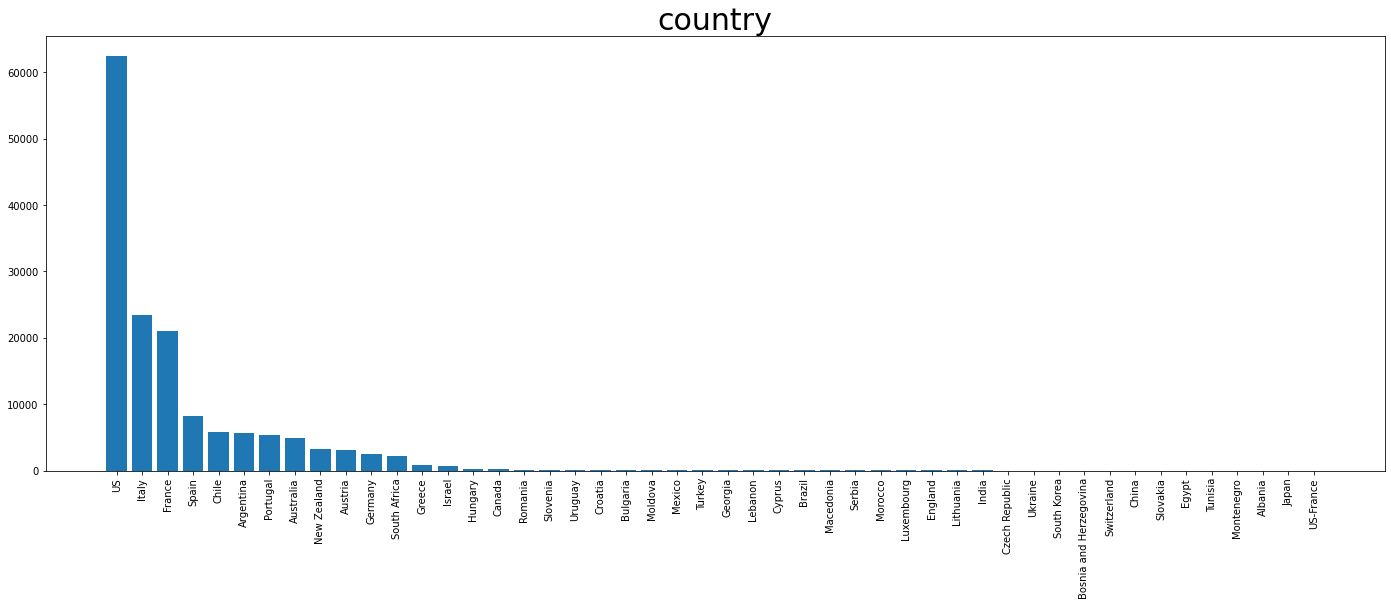

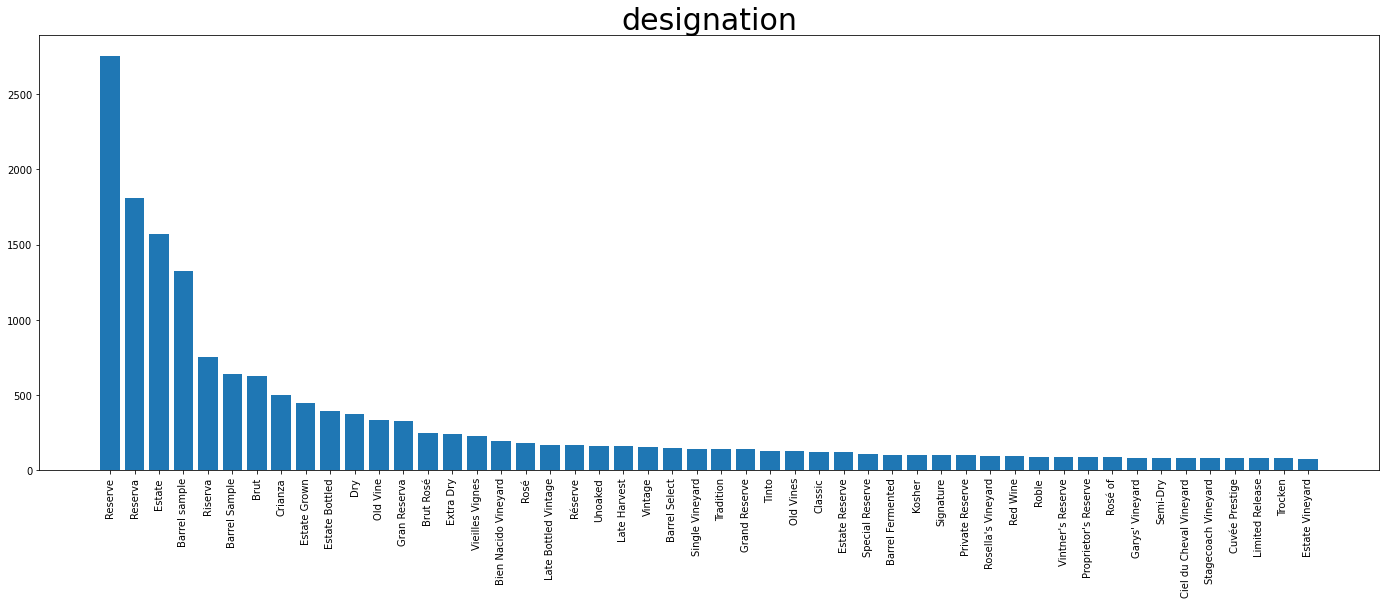

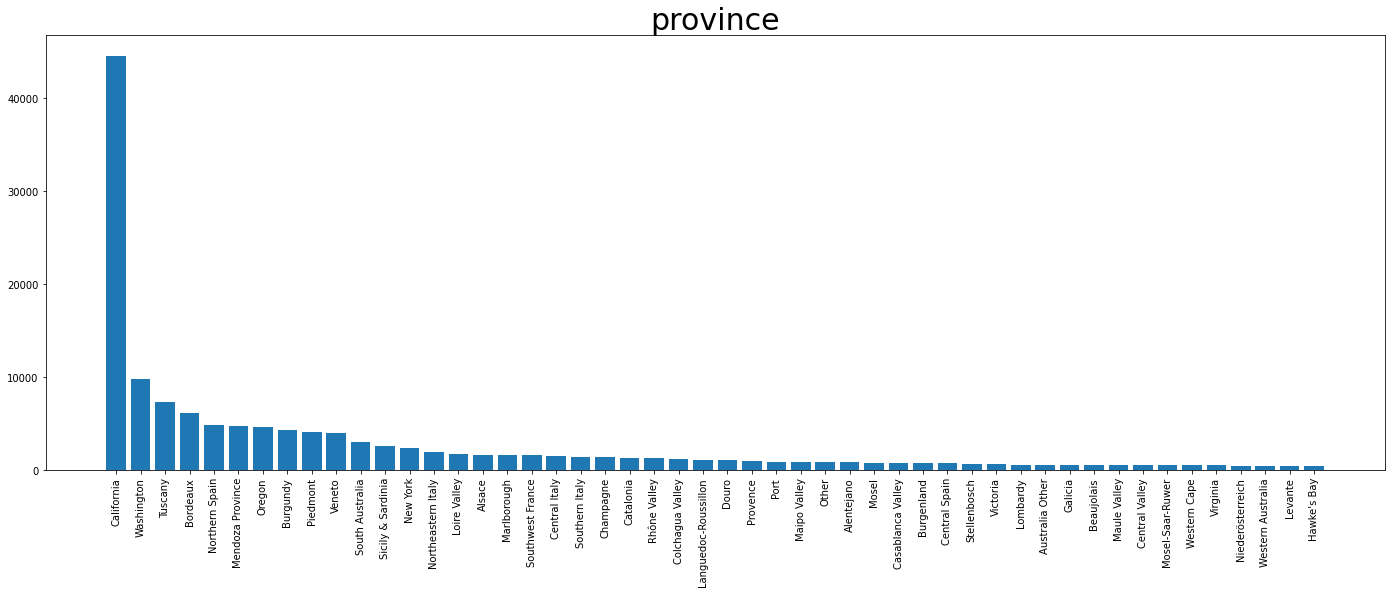

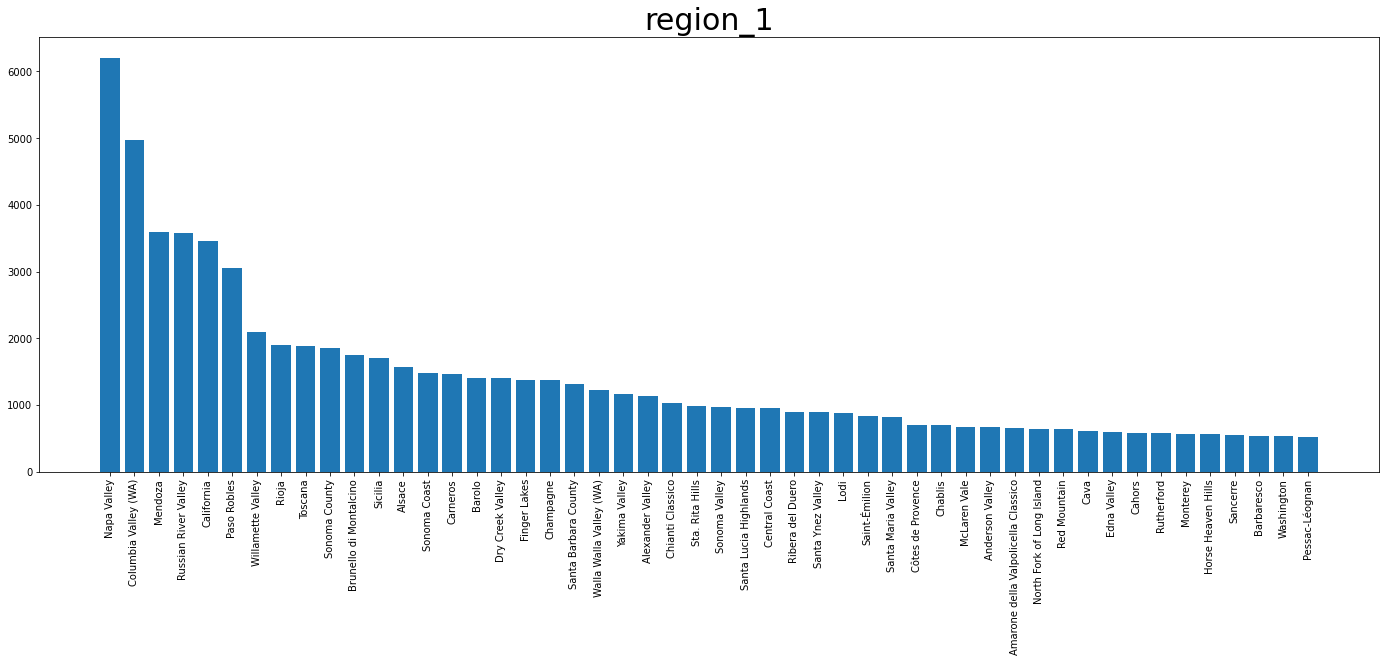

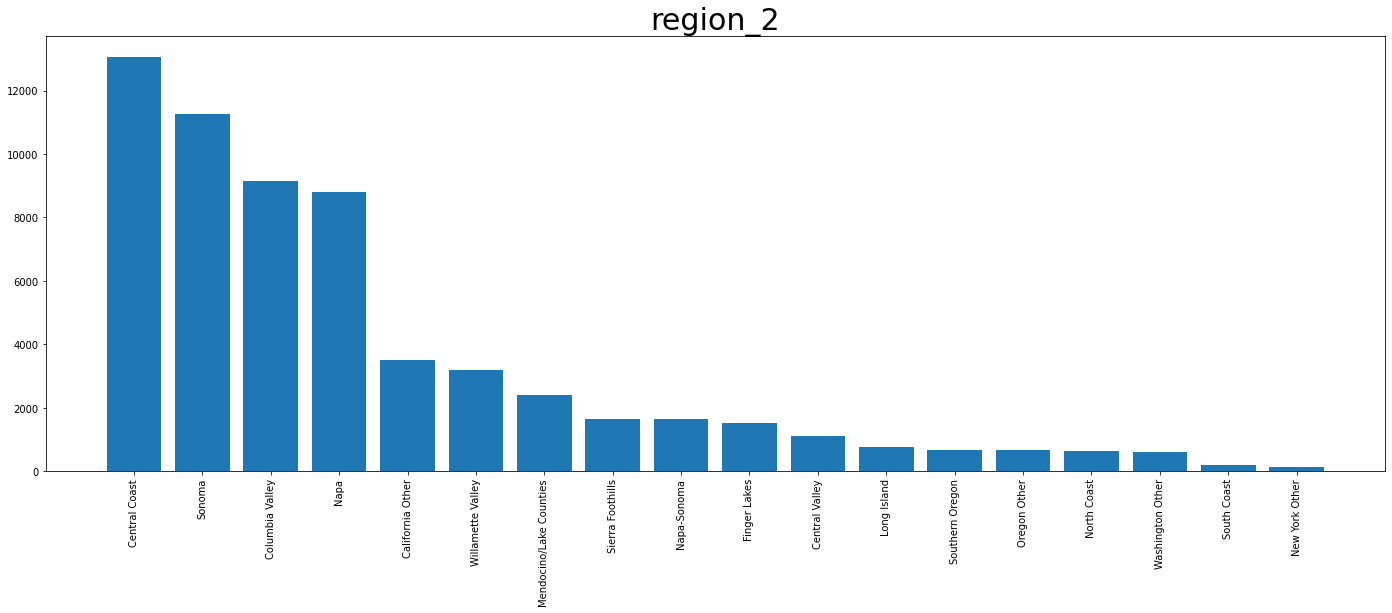

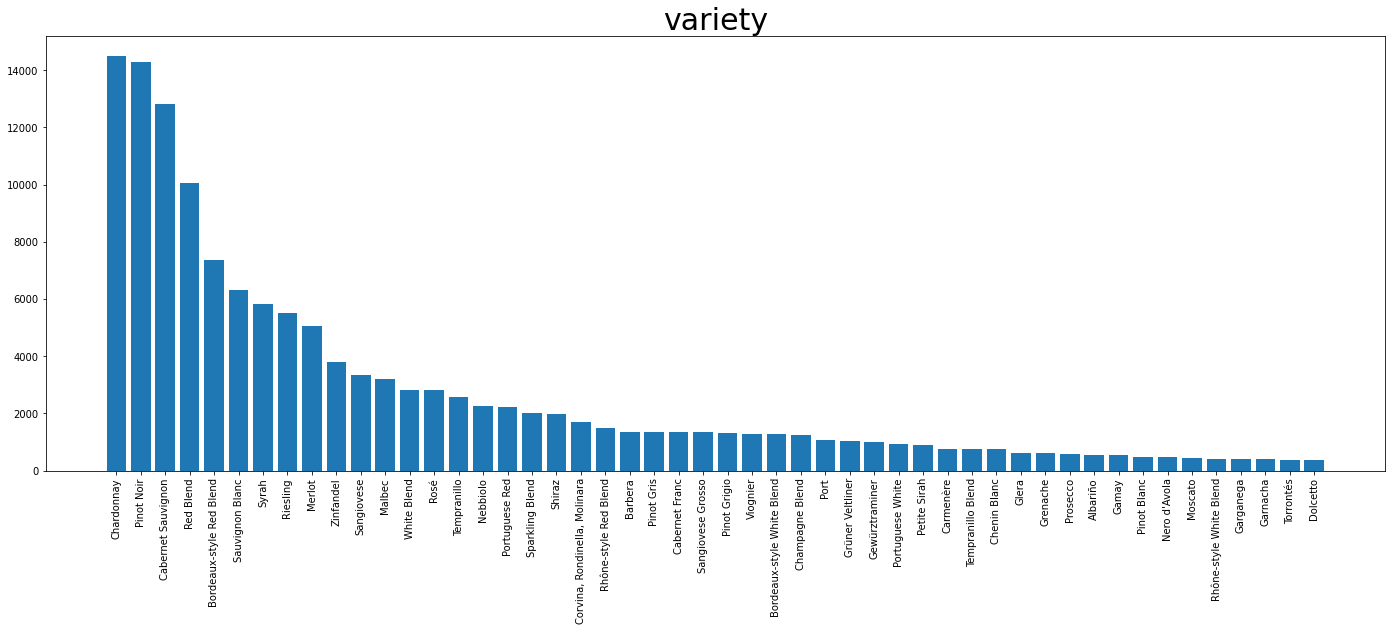

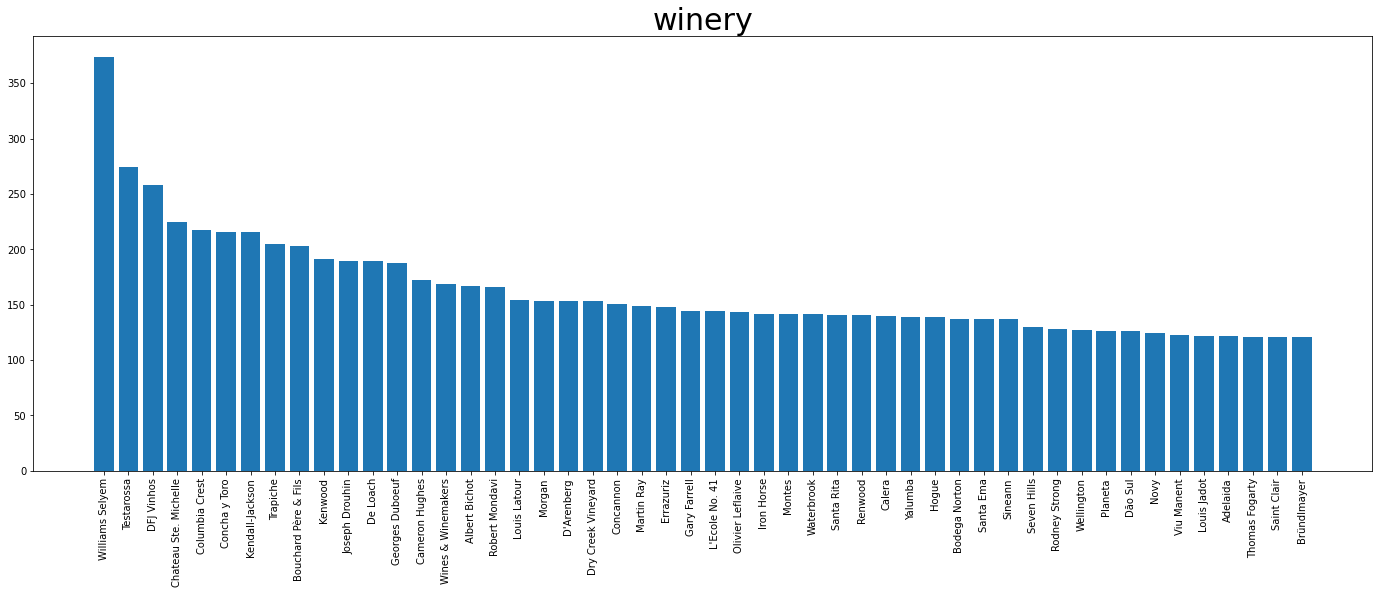

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000
Missing: 0

descriptive statistics (price):
Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000
Missing: 13695



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


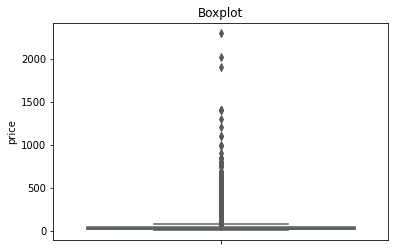

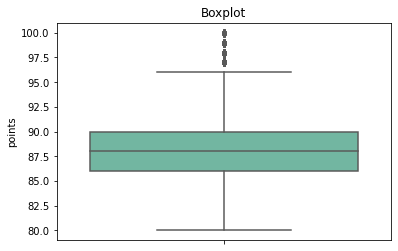

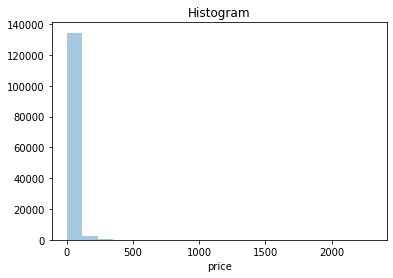

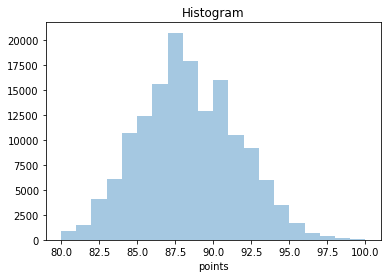

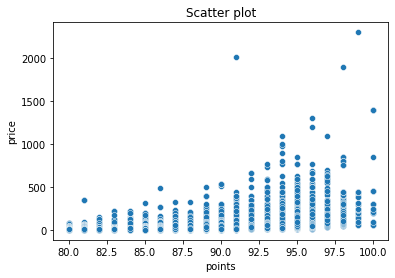

In [48]:
# 随机森林
miss_index=['country','designation','price','province','region_1','region_2']
comp_index=['description','points','variety','winery']
att150k=attr_corr_fill(winemag150k,miss_index=miss_index,complete_index=comp_index)
columns_info(winemag150k,show_shape=True,new_df=att150k)
nominal_summary(winemag150k,nominal_index=nominal_index,head_n=50,new_df=att150k)
numerical_summary(winemag150k,numerical_index=numerical_index,new_df=att150k)
viz_pairs(winemag150k,xlabel='points',ylabel='price',bins=20,new_df=att150k)

#### 4 通过数据对象之间的相似性来填补缺失值

c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\impyute\imputation\cs\fast_knn.py:113: RuntimeWarning: invalid value encountered in true_divide
  weights = distances/np.sum(distances)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB
None
(150930, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   des

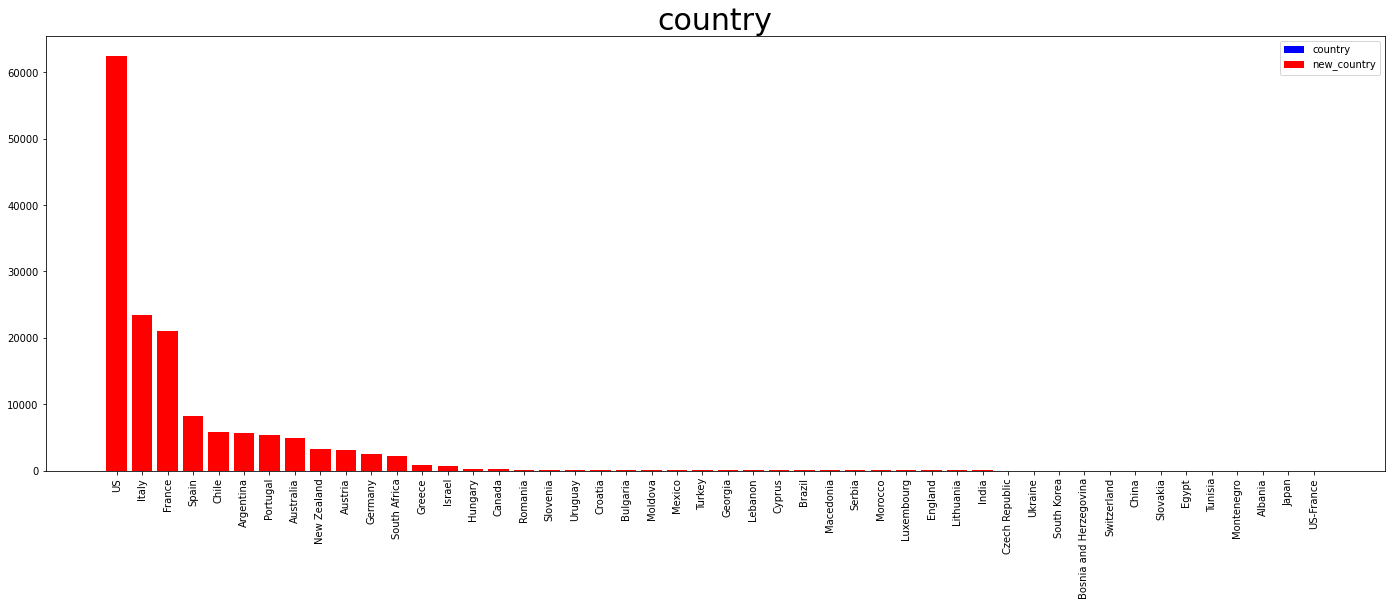

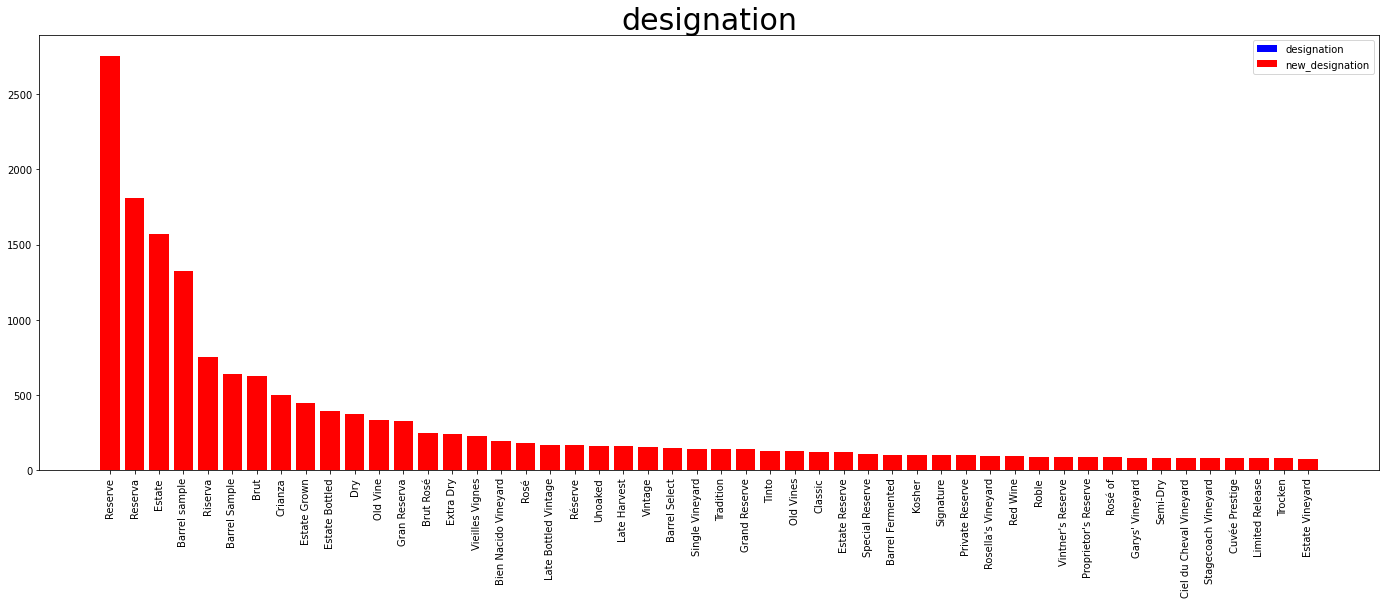

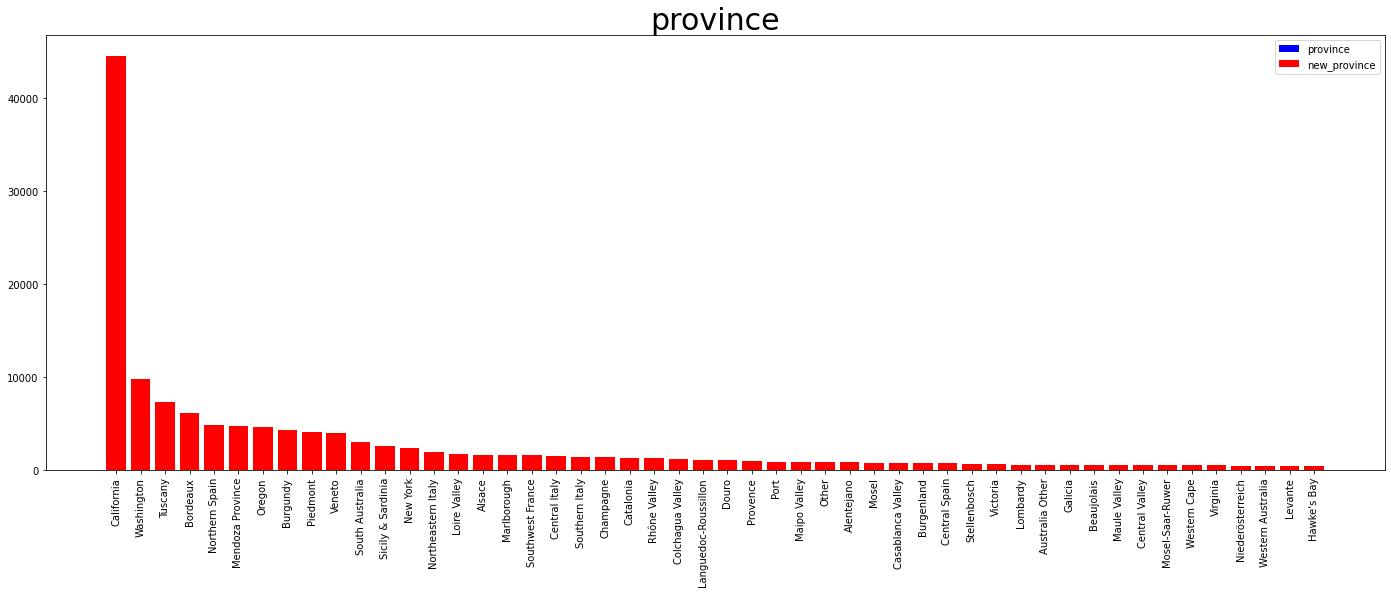

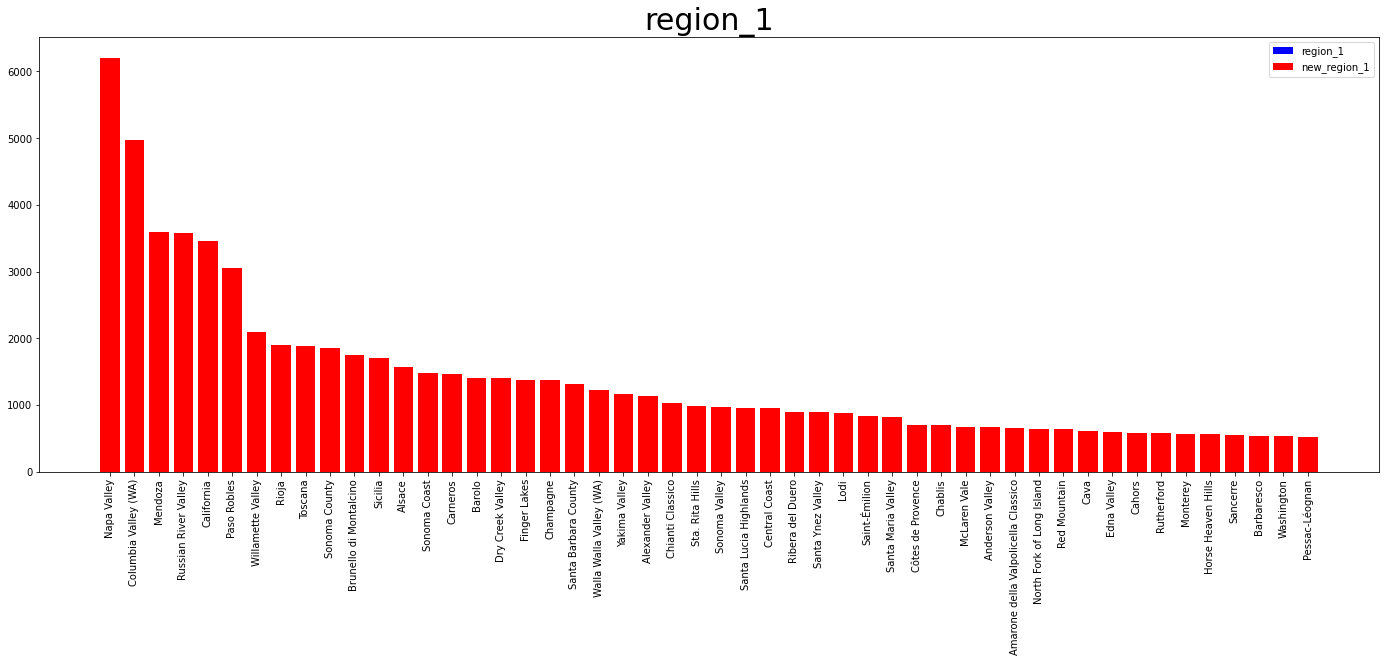

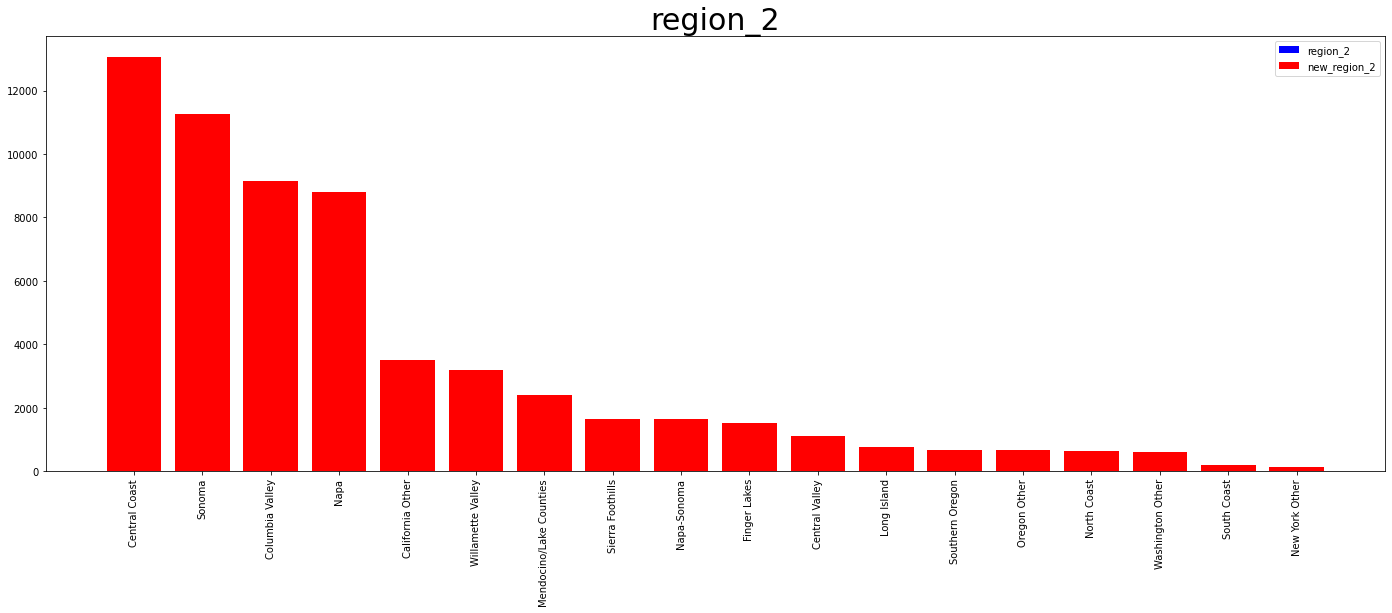

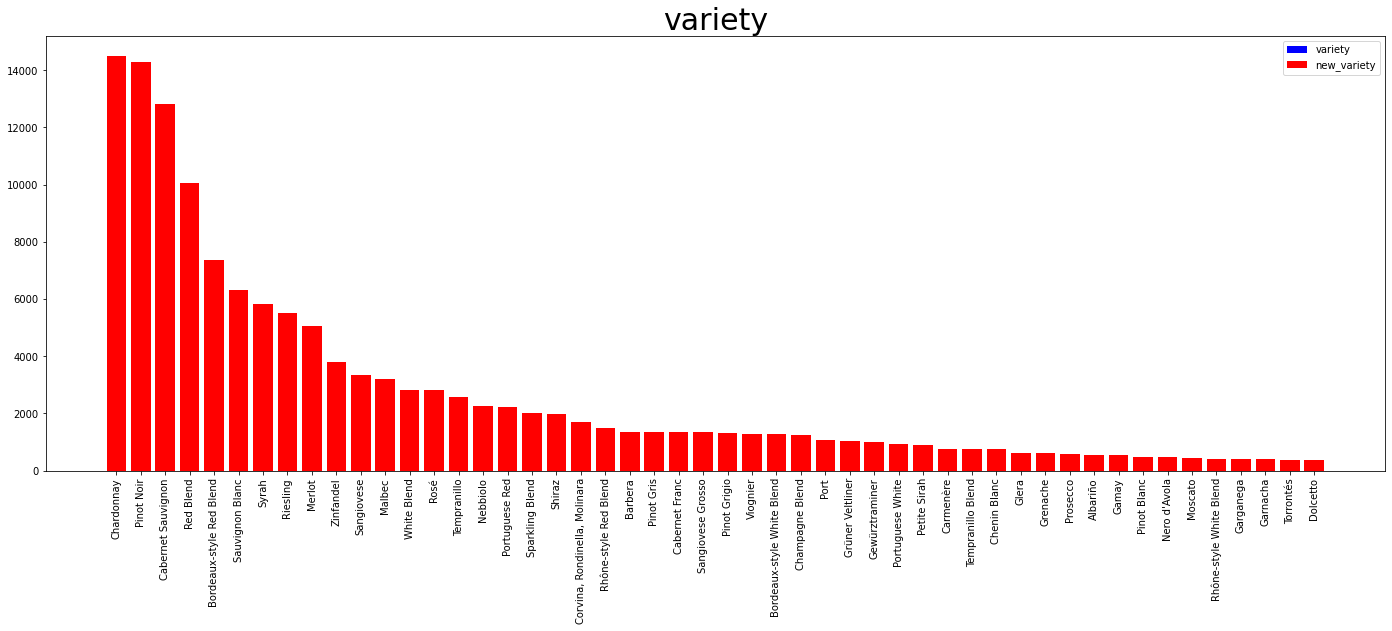

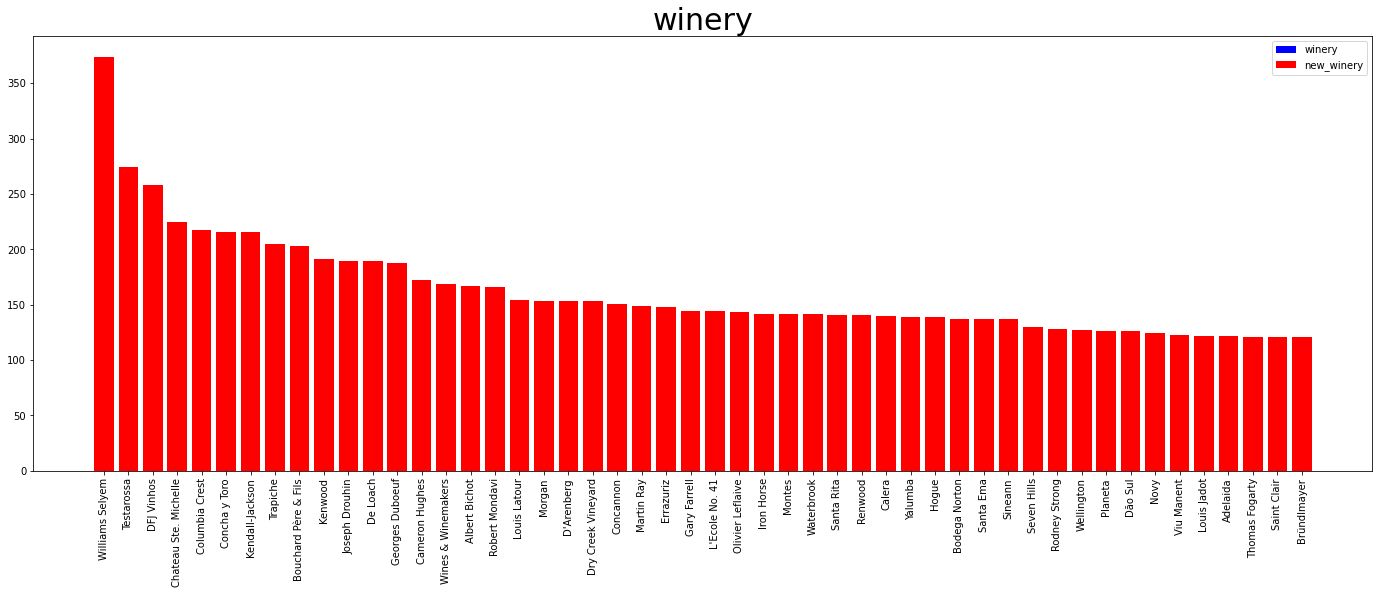

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 90.0000 	Max: 100.0000 
 new Missing: 0 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000
Missing: 13695

 new Min: 4.0000	Q1(25%): 16.0000 	Q2(50%): 24.0000 	Q3(75%): 40.0000 	Max: 2300.0000 
 new Missing: 13620 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


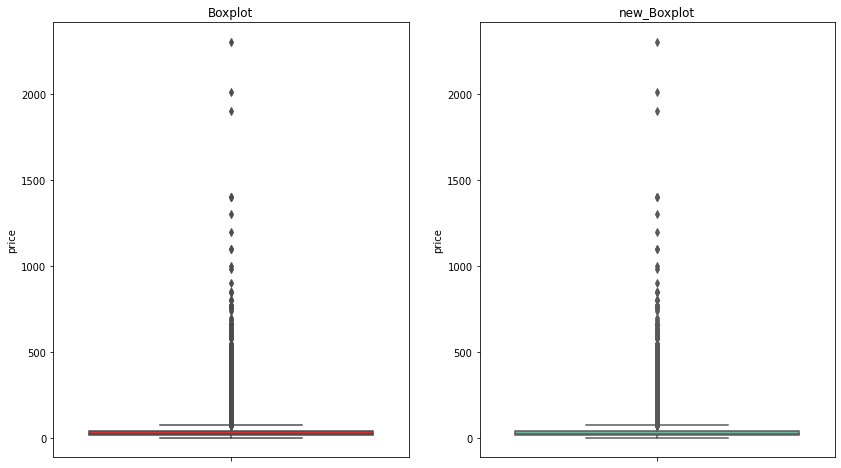

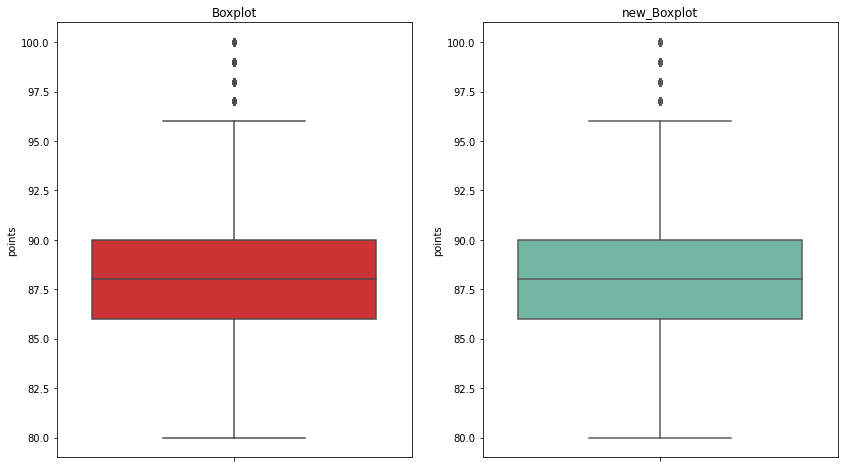

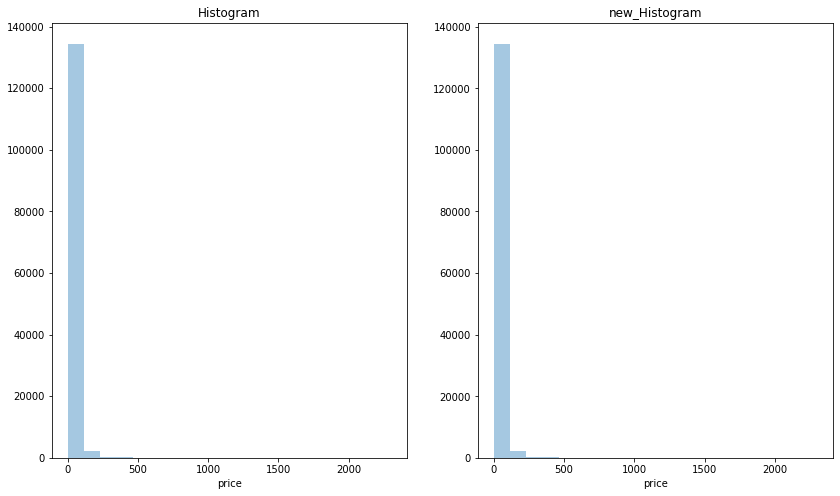

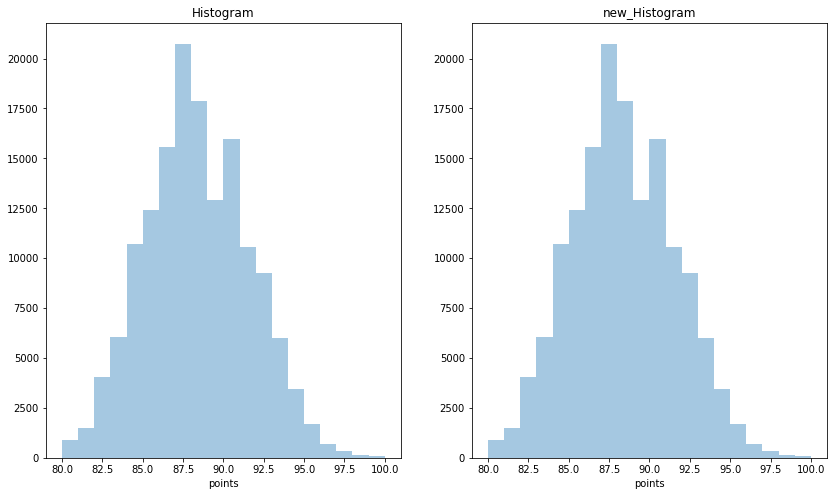

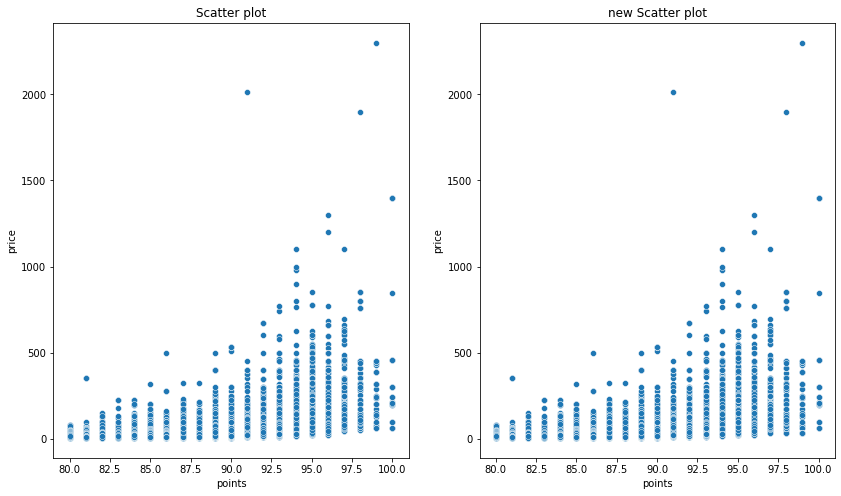

In [49]:
# KNN
obj150k=obj_corr_fill(winemag150k,numerical_index=numerical_index,k=10)
columns_info(winemag150k,show_shape=True,new_df=obj150k)
nominal_summary(winemag150k,nominal_index=nominal_index,head_n=50,new_df=obj150k)
numerical_summary(winemag150k,numerical_index=numerical_index,new_df=obj150k)
viz_pairs(winemag150k,xlabel='points',ylabel='price',bins=20,new_df=obj150k)

## 1.2 winemag-data-130k-v2.csv

In [66]:
#与第一部分采用相同的策略 这里的标称属性有些不同
winemag130k=pd.read_csv(wine_dir+"/winemag-data-130k-v2.csv",sep=',',header='infer',index_col=0)
columns_info(winemag130k)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB
None
(129971, 13)


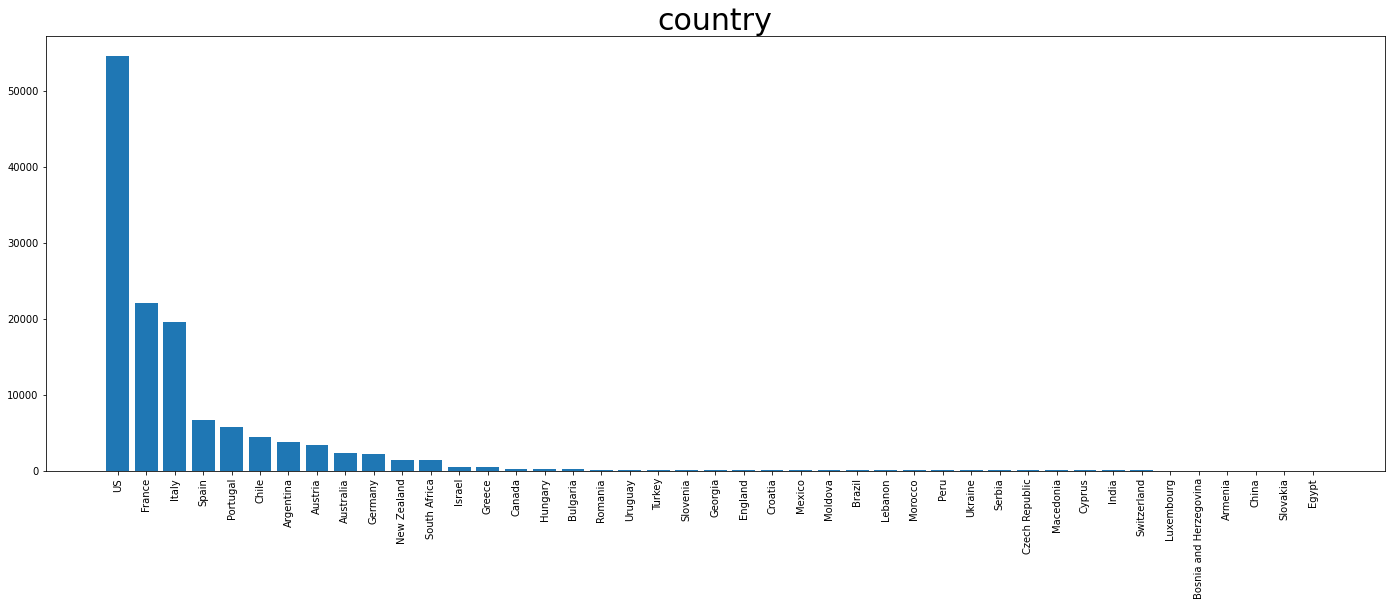

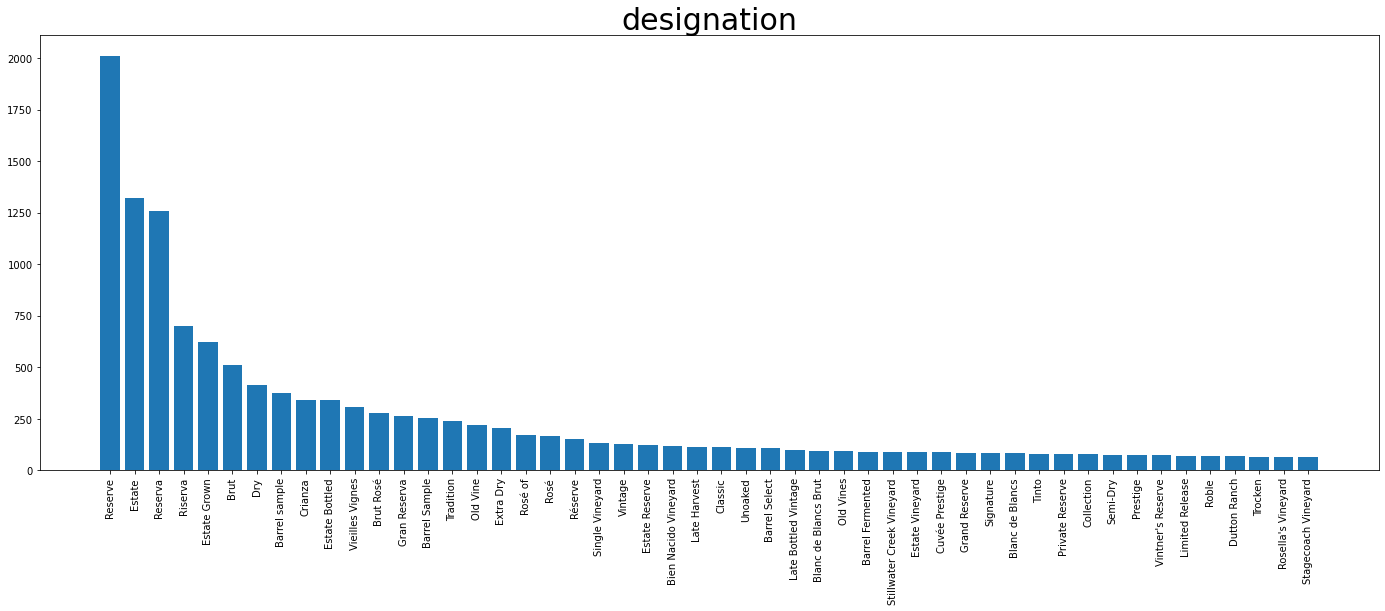

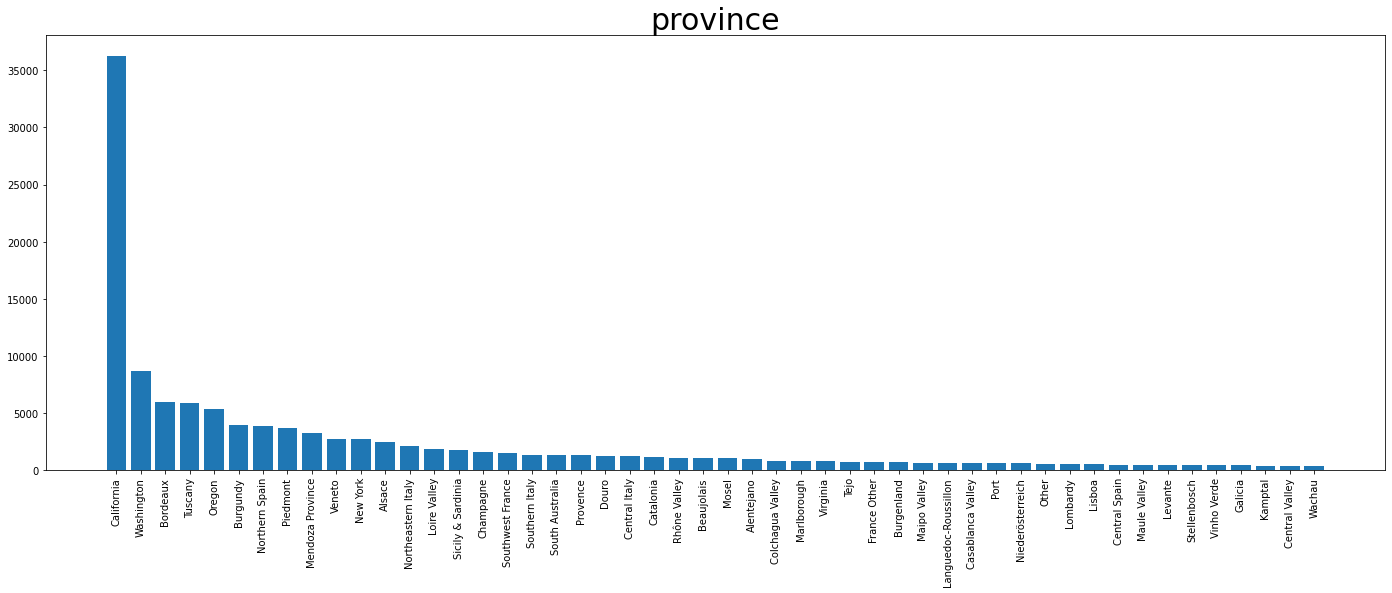

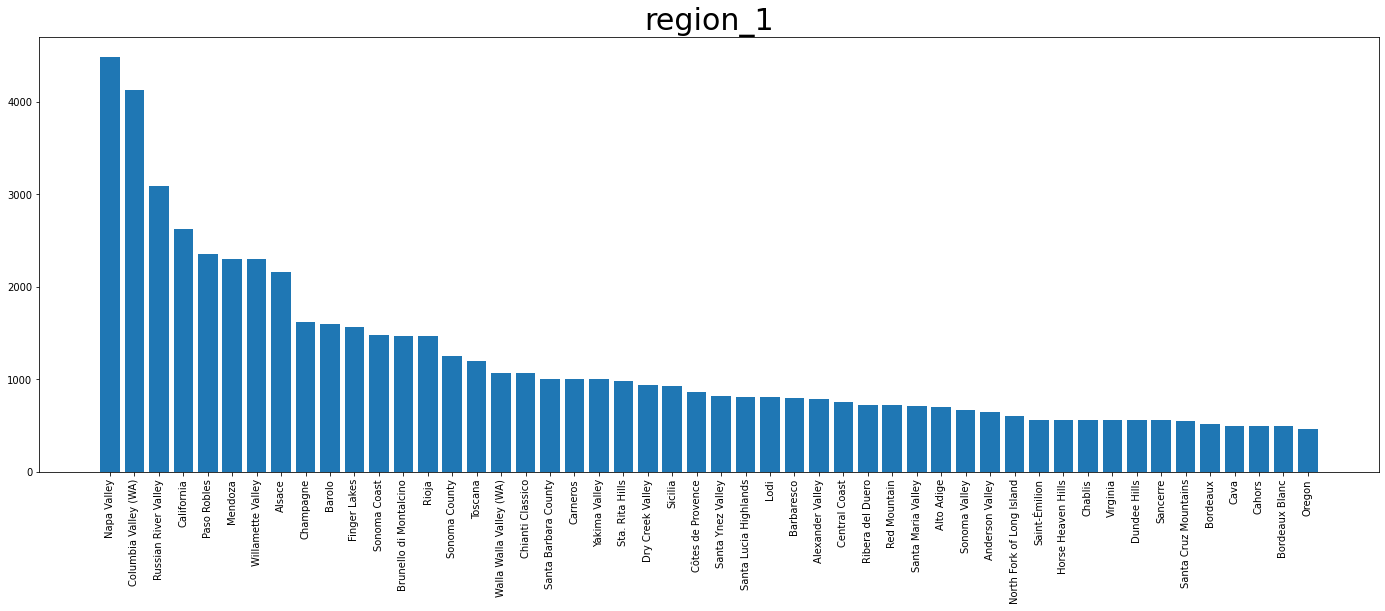

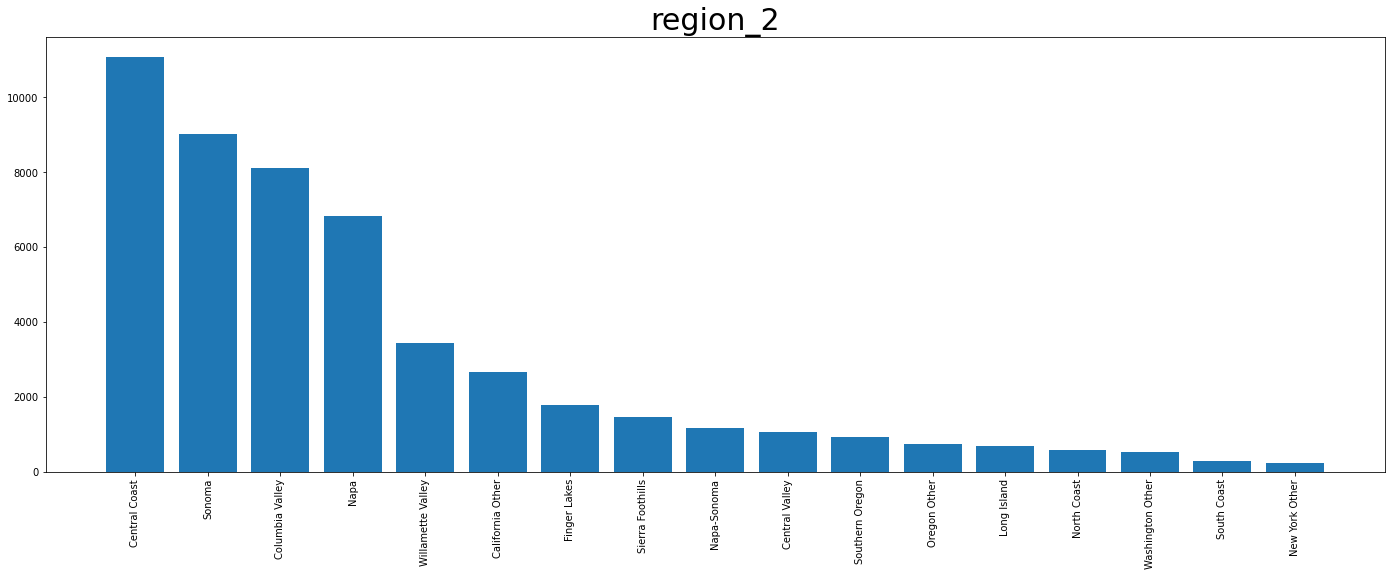

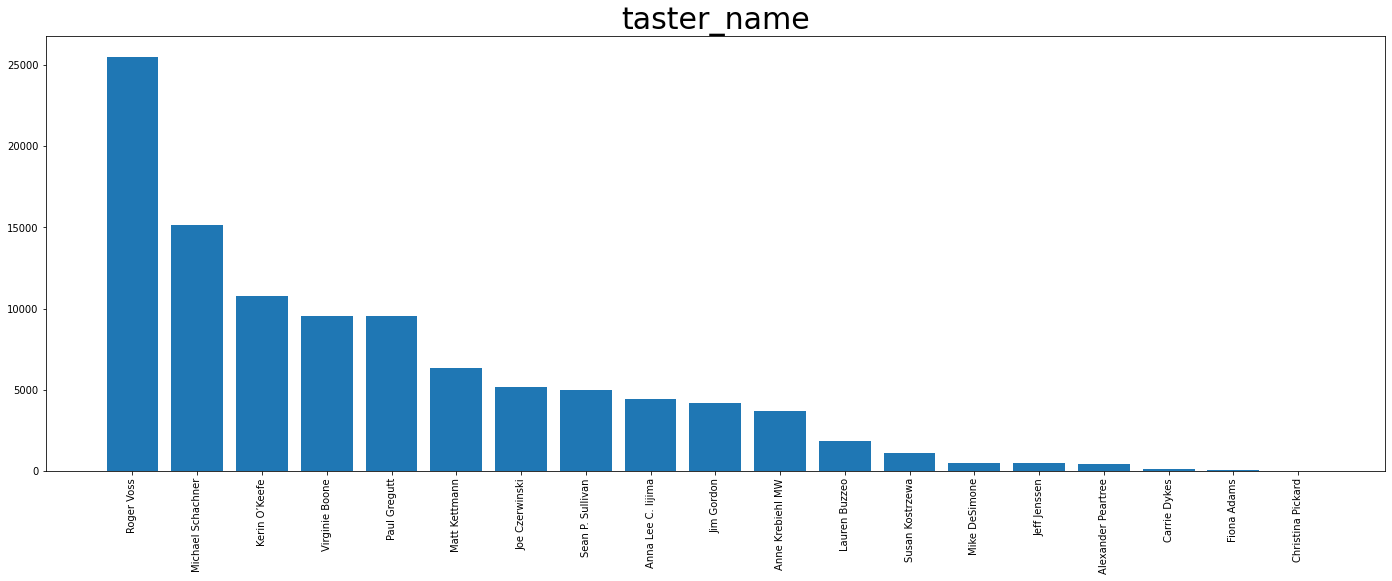

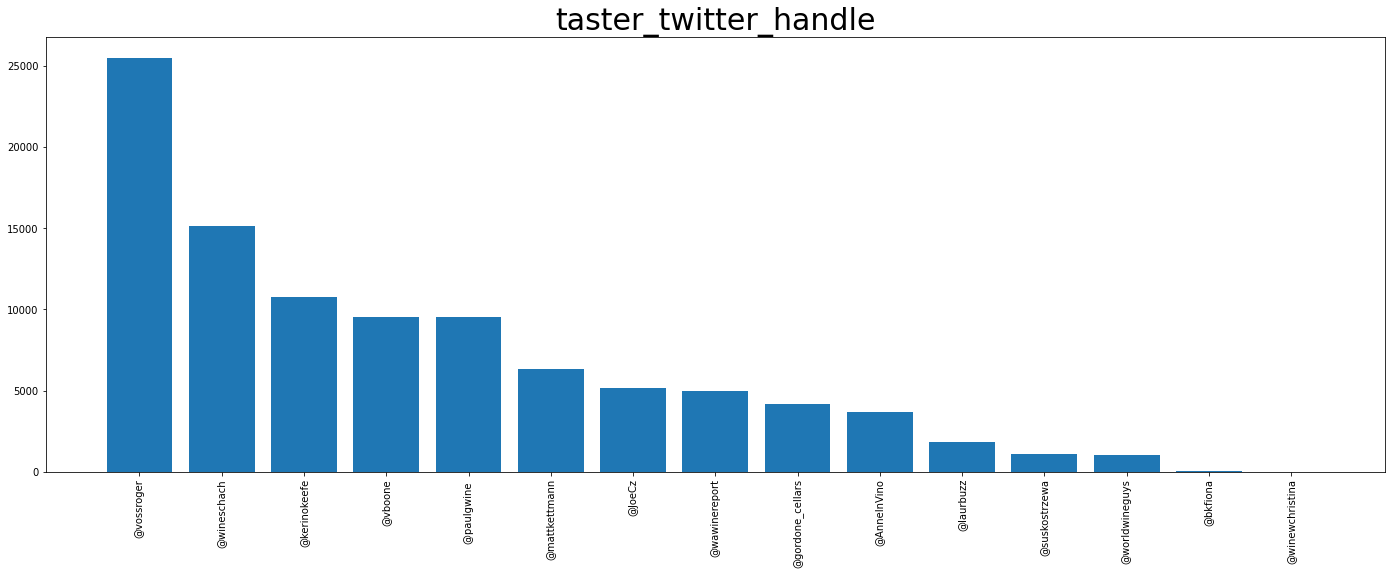

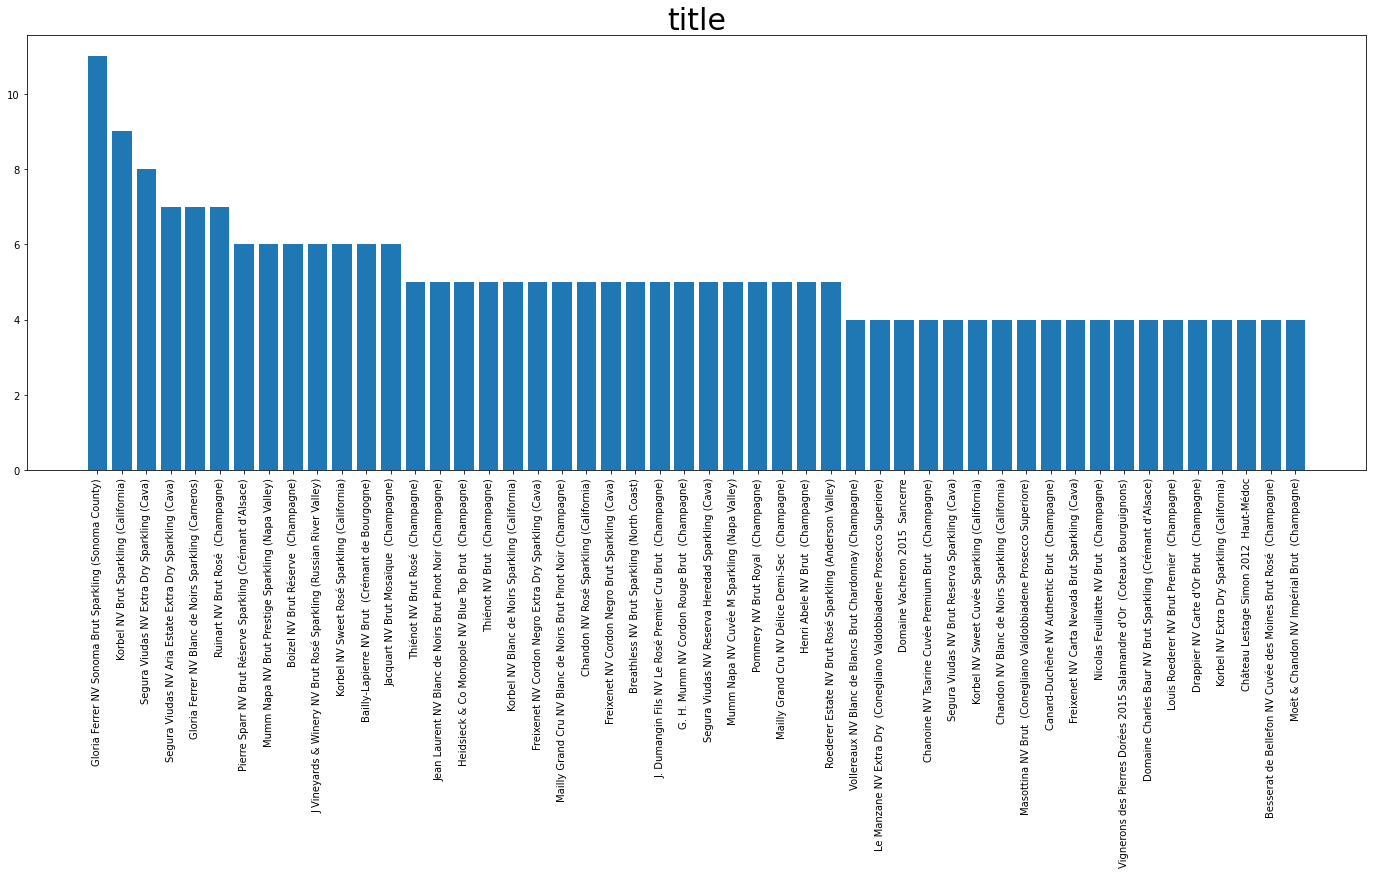

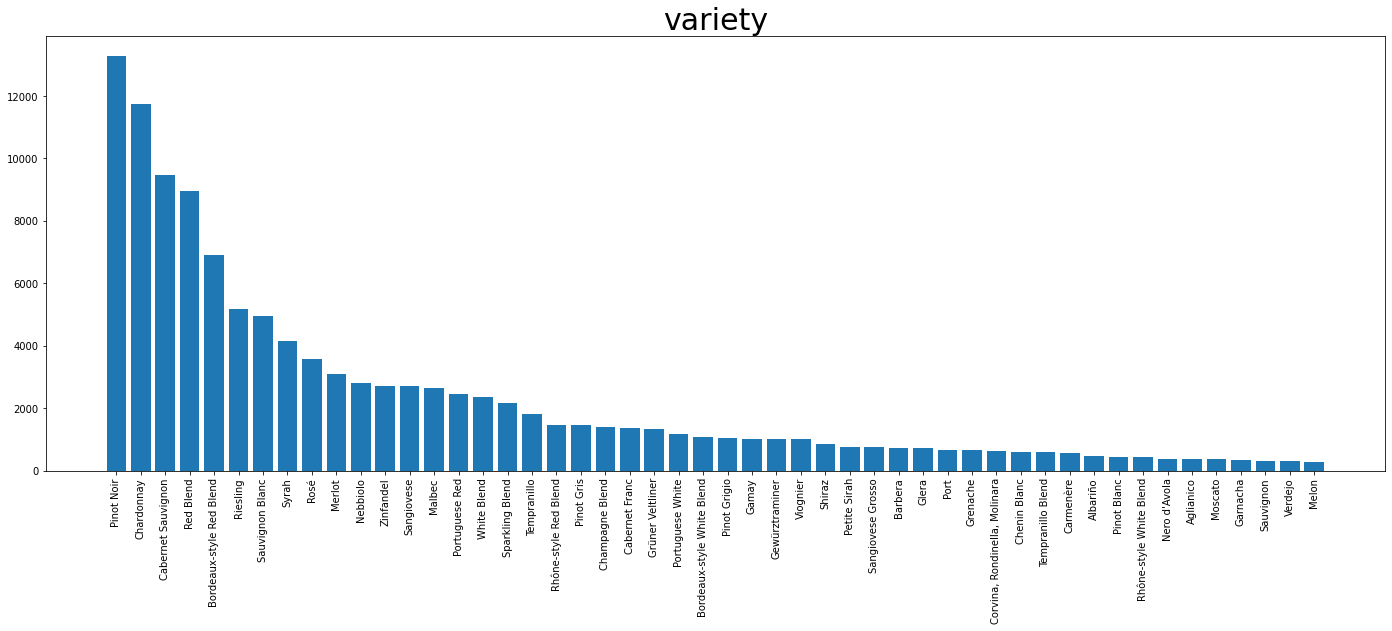

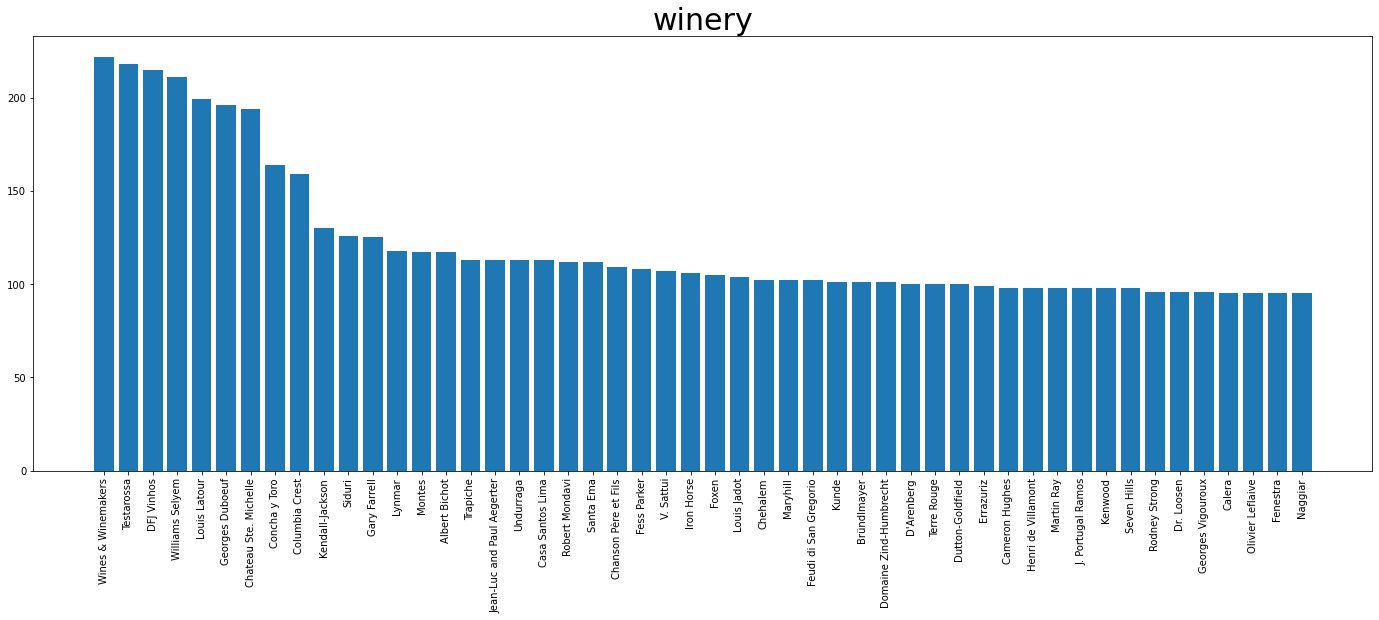

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000
Missing: 0

descriptive statistics (price):
Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000
Missing: 8996



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


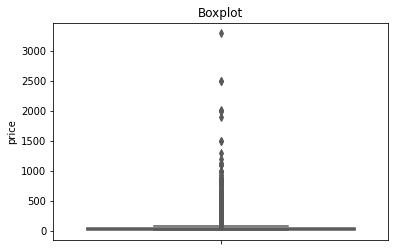

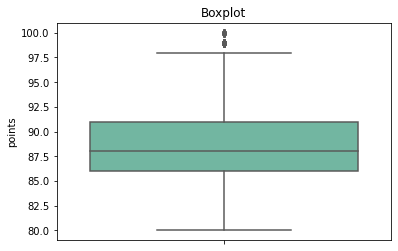

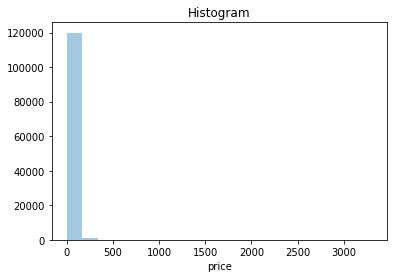

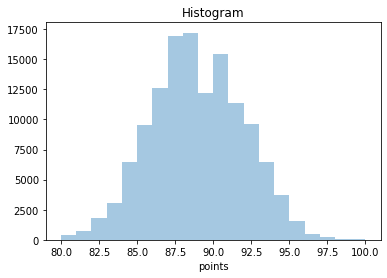

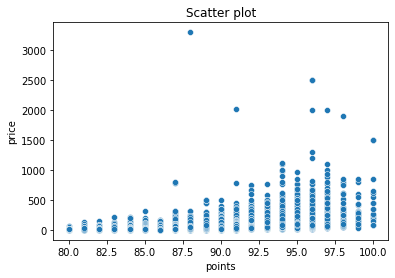

In [68]:
# 标称属性
nominal_index = ['country', 'designation', 'province', 'region_1', 'region_2', 
                 'taster_name','taster_twitter_handle','title',
                 'variety', 'winery']
# 数值属性
numerical_index = ['points', 'price']
# 统计频数，缺失点，可视化
nominal_summary(winemag130k,nominal_index,head_n=50)
numerical_summary(winemag130k,numerical_index)
viz_pairs(winemag130k,xlabel='points',ylabel='price',bins=20,new_df=None)

### 缺失值处理与对比

#### 1 将缺失部分剔除

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB
None
(129971, 13)

<class 'pan

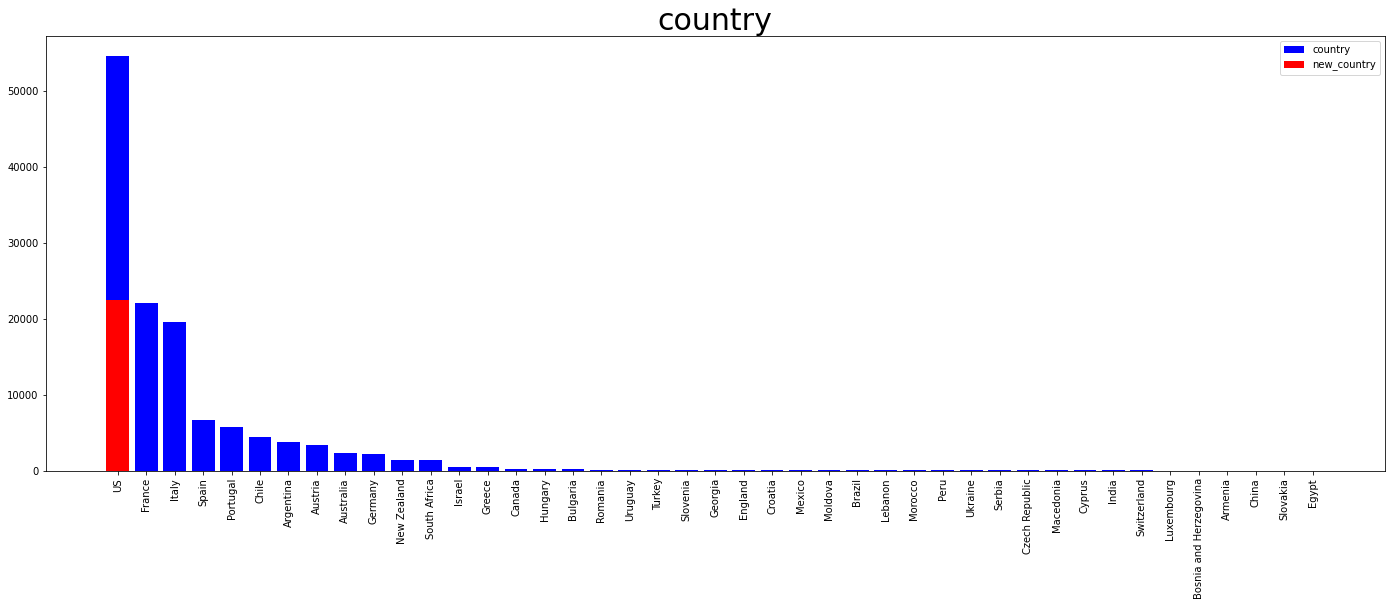

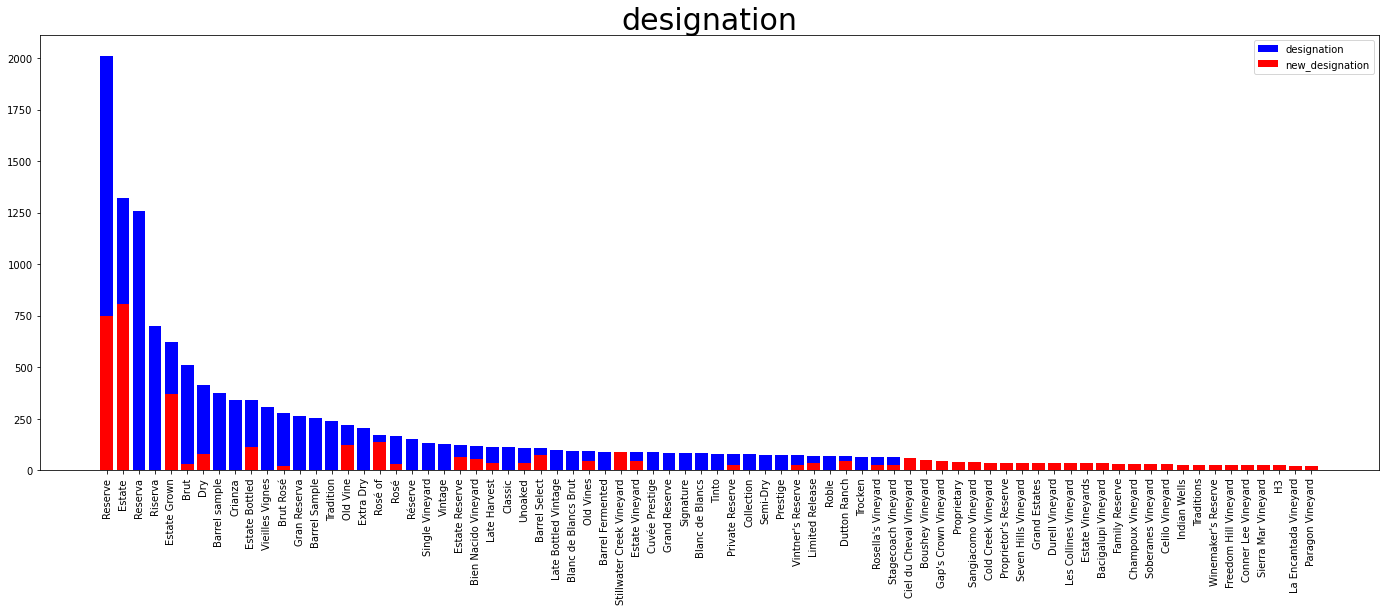

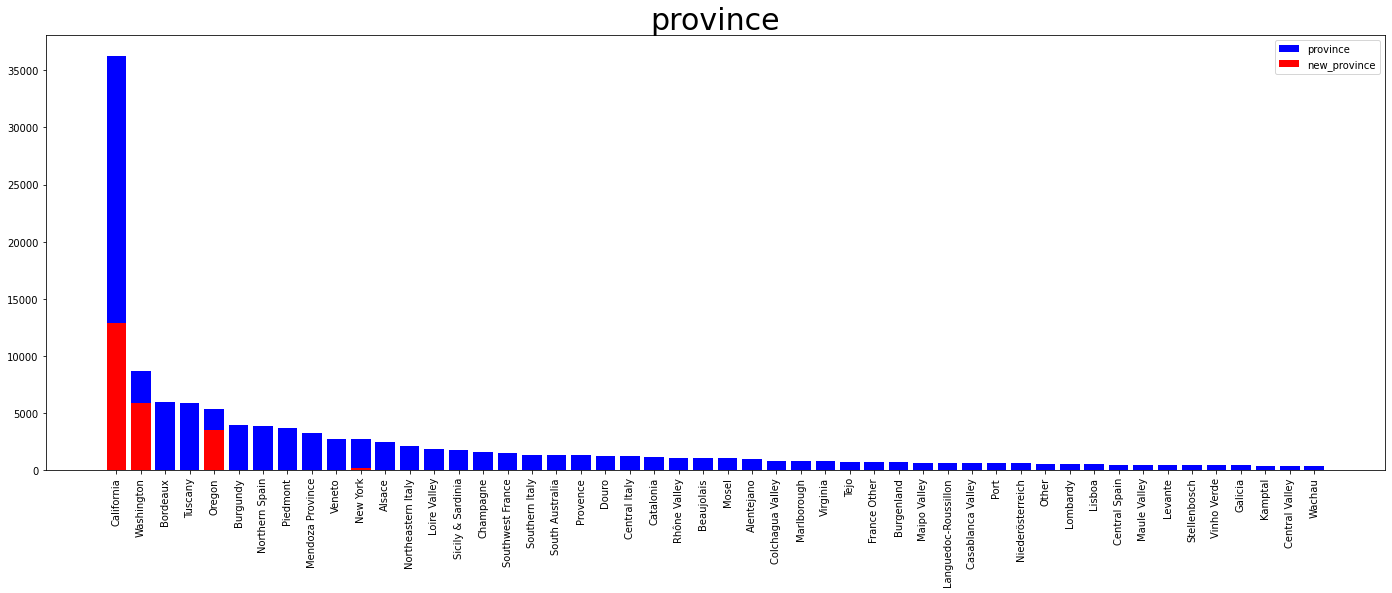

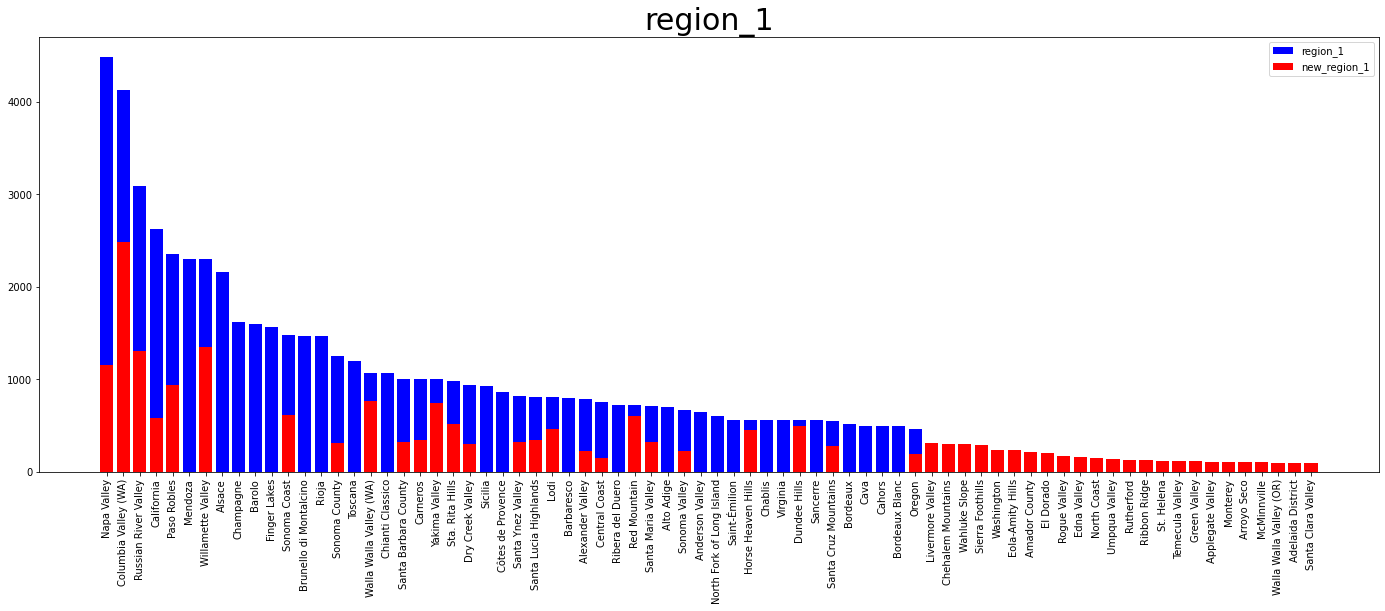

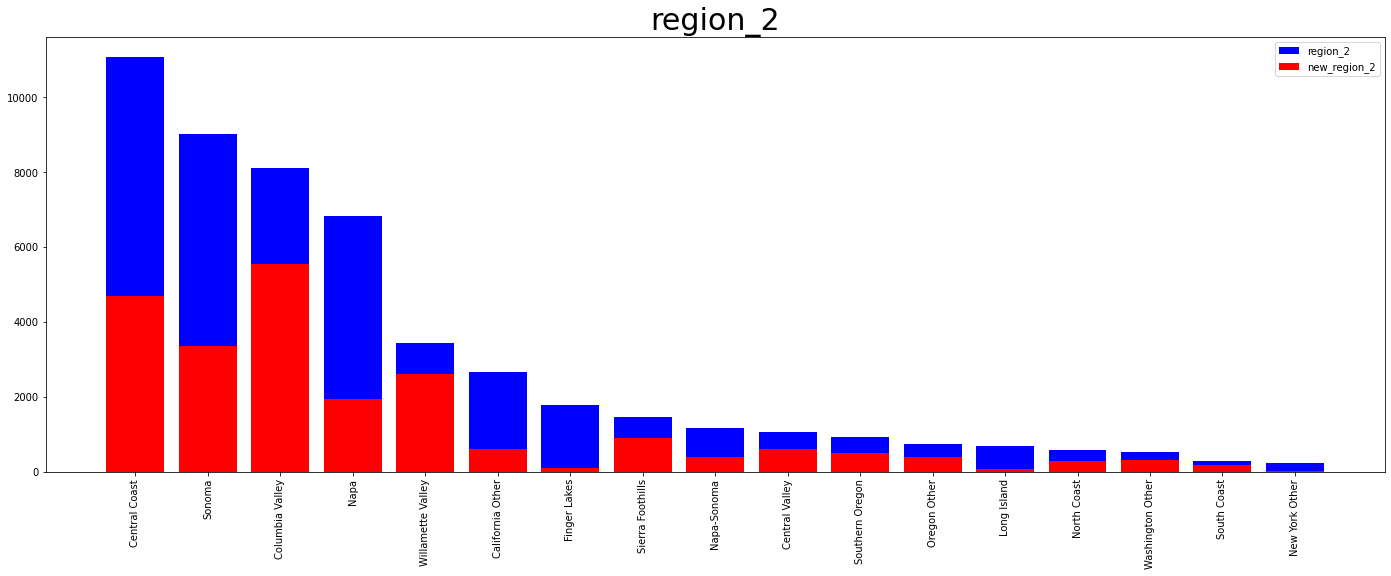

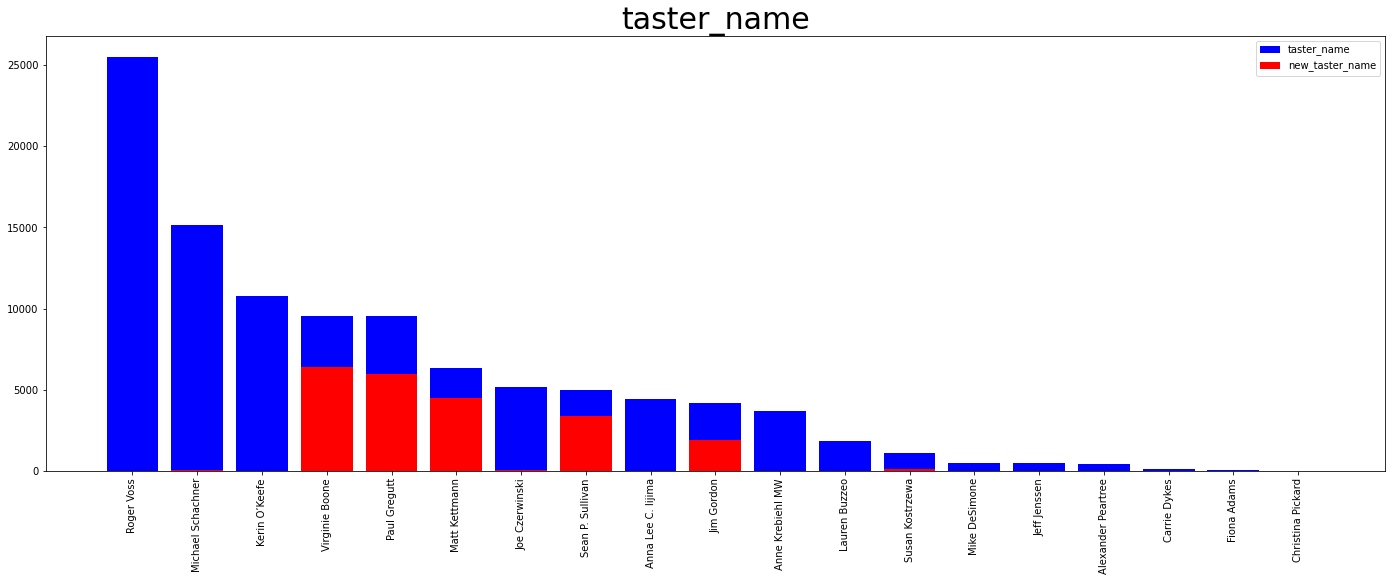

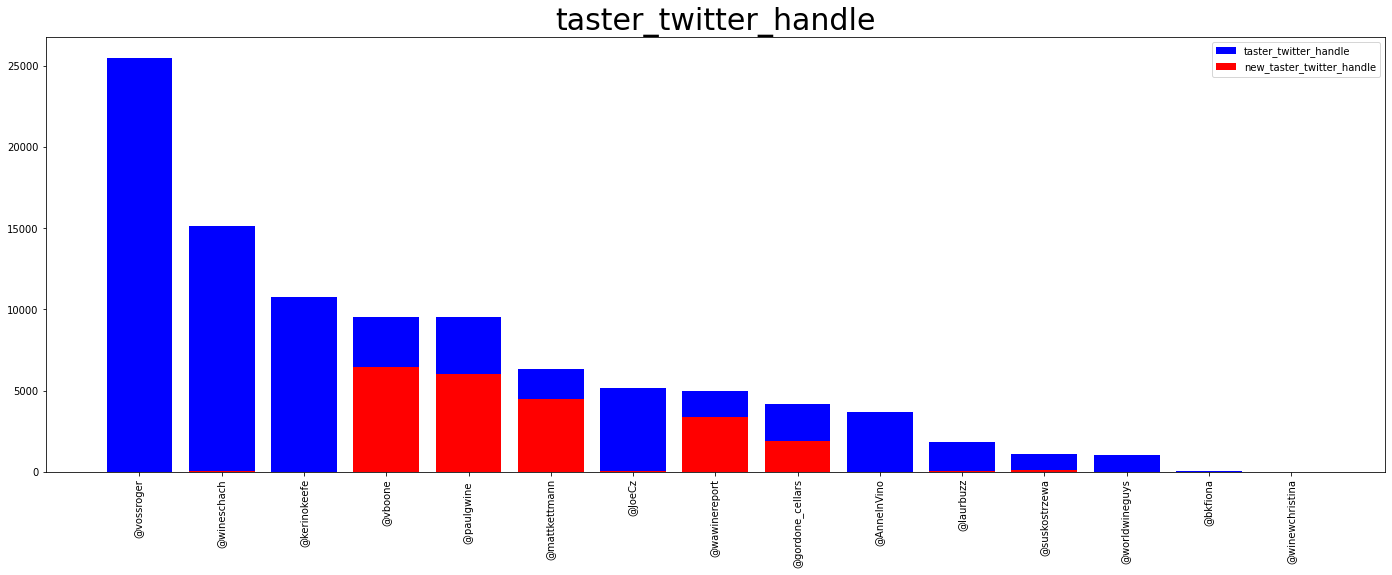

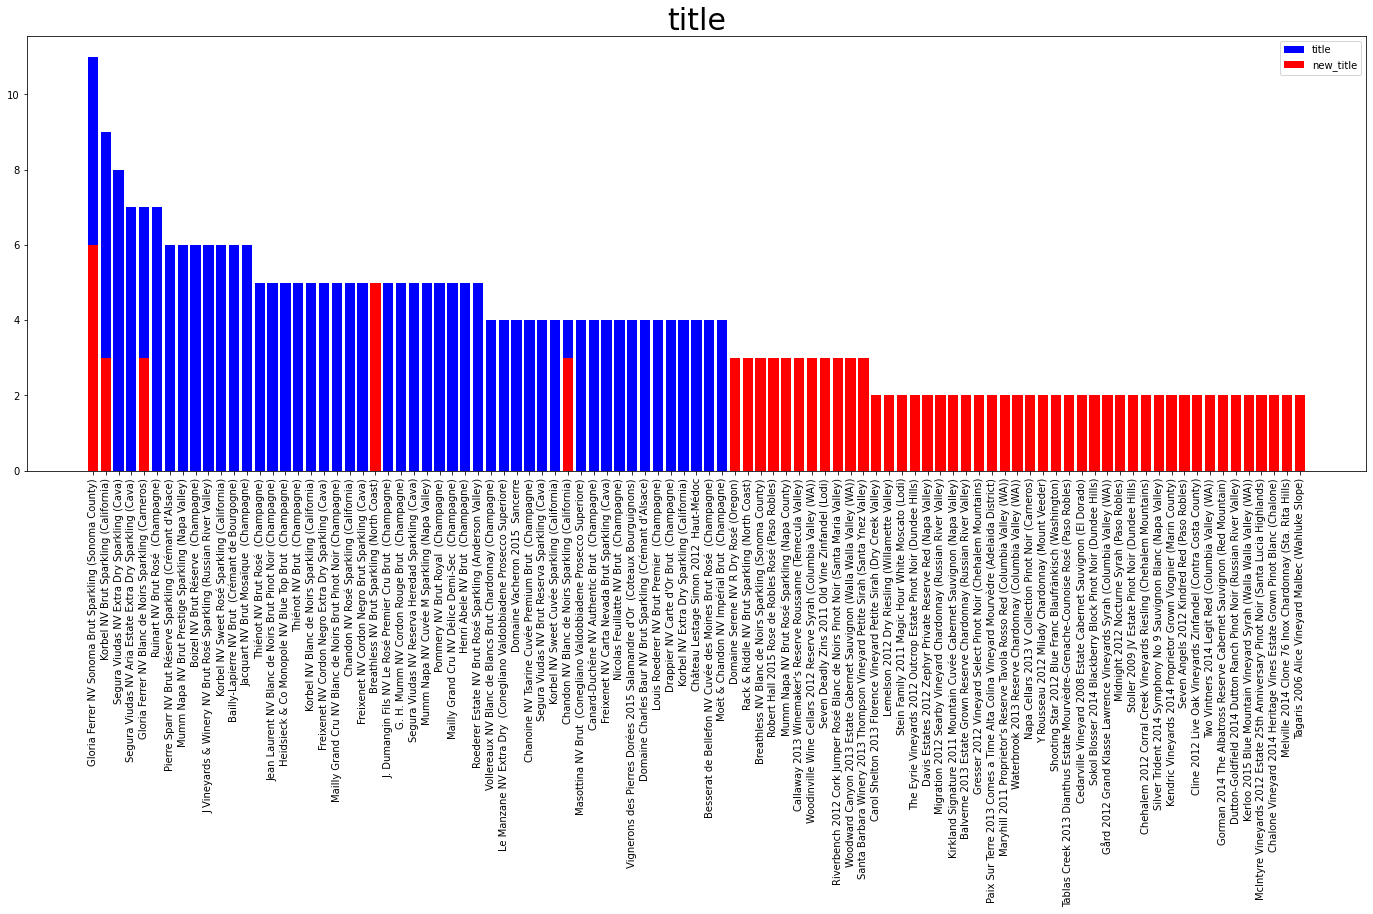

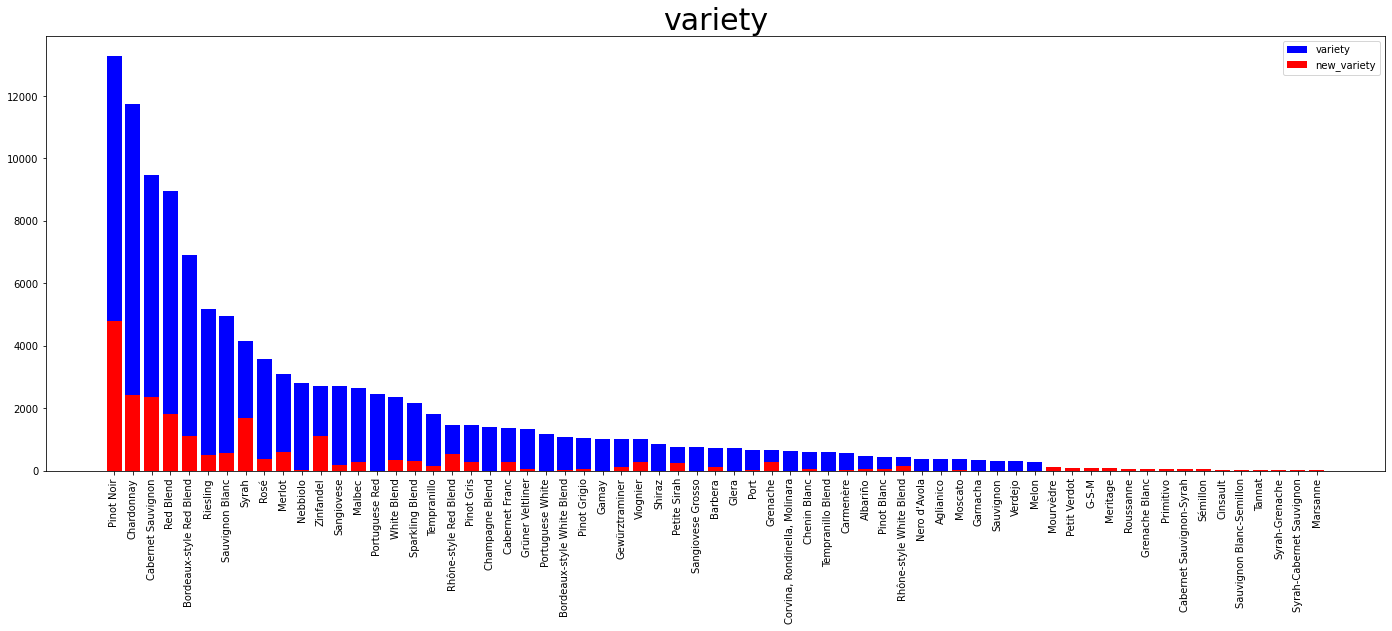

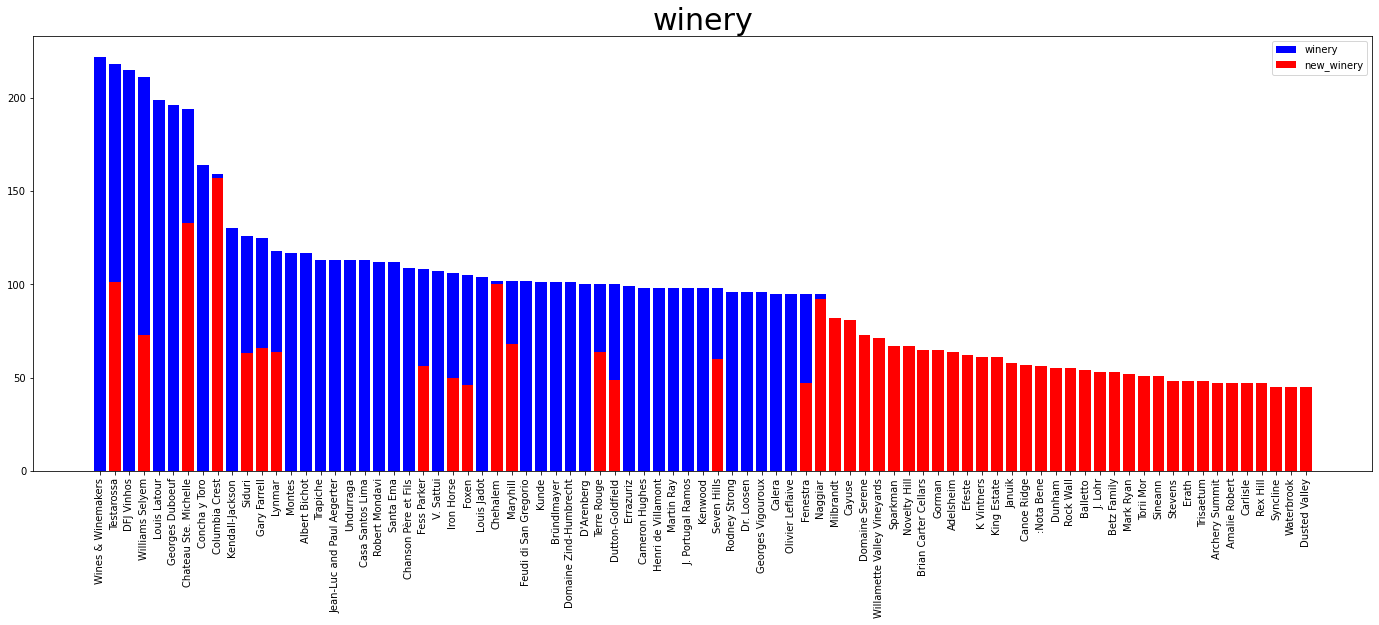

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 88.0000 	Q2(50%): 90.0000 	Q3(75%): 92.0000 	Max: 100.0000 
 new Missing: 107584 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000
Missing: 8996

 new Min: 4.0000	Q1(25%): 25.0000 	Q2(50%): 36.0000 	Q3(75%): 50.0000 	Max: 2013.0000 
 new Missing: 107584 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


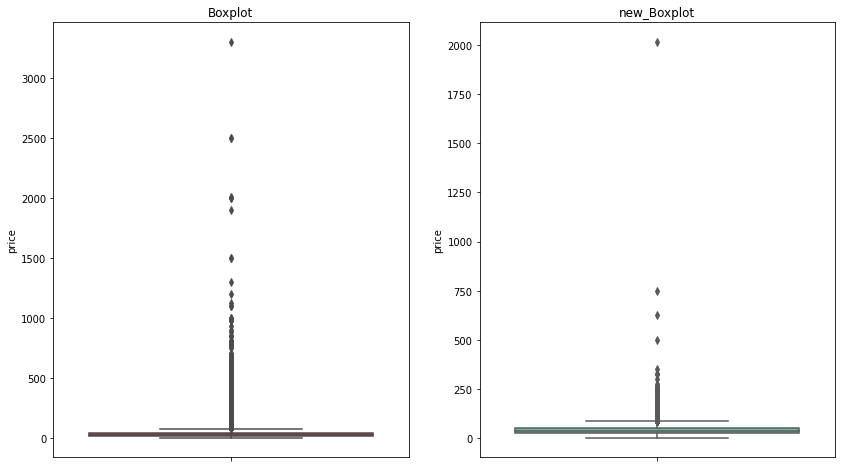

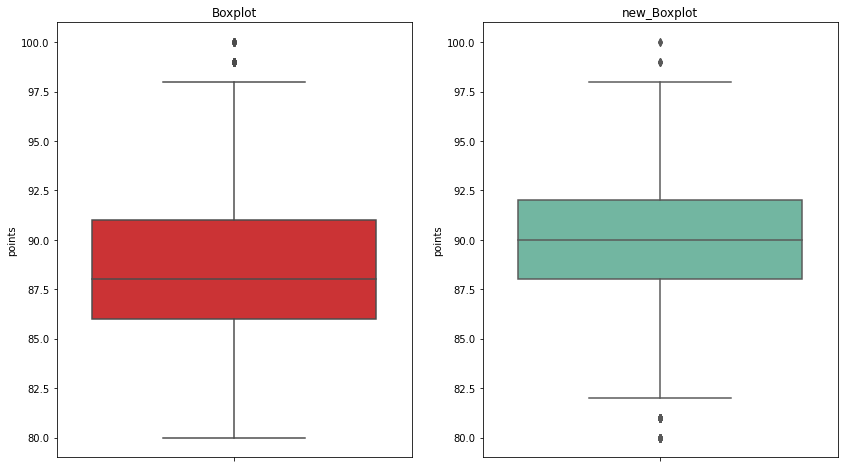

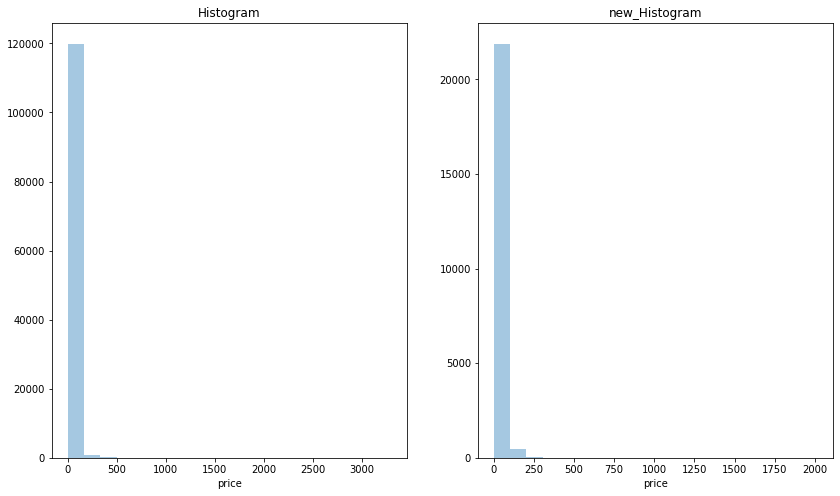

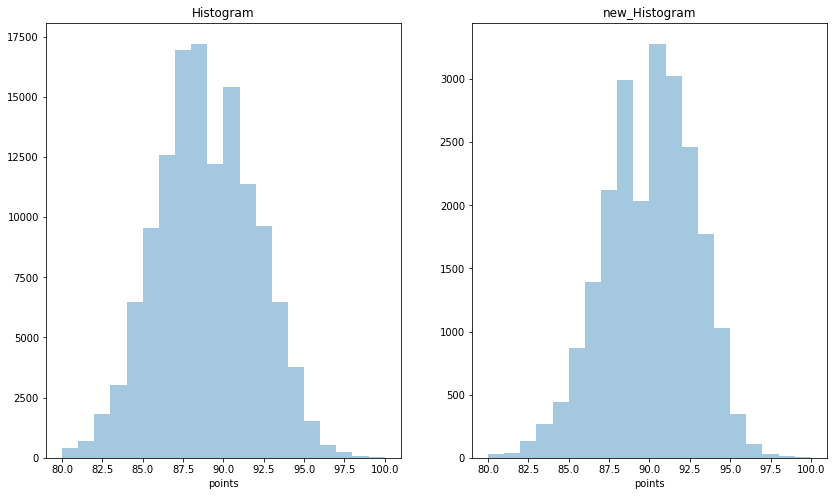

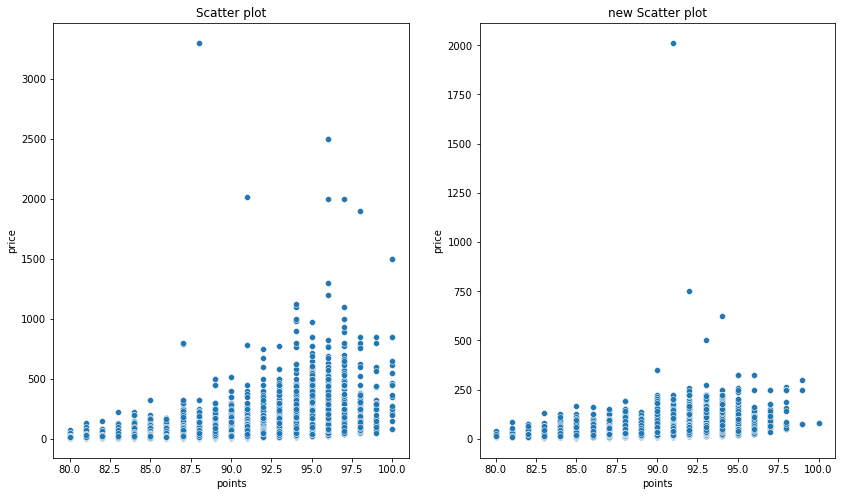

In [69]:
dw130k=miss_drop(winemag130k)
columns_info(winemag130k,show_shape=True,new_df=dw130k)
nominal_summary(winemag130k,nominal_index=nominal_index,head_n=50,new_df=dw130k)
numerical_summary(winemag130k,numerical_index=numerical_index,new_df=dw130k)
viz_pairs(winemag130k,xlabel='points',ylabel='price',bins=20,new_df=dw130k)

#### 2 用最高频率值来填补缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB
None
(129971, 13)

<class 'pan

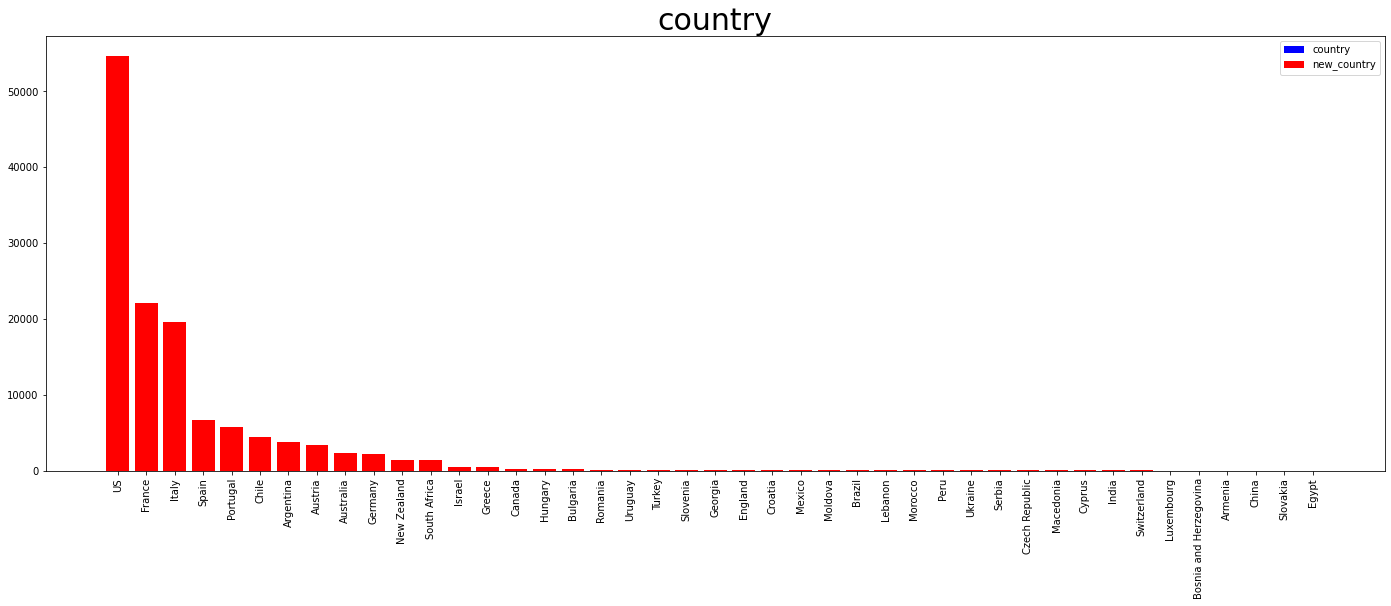

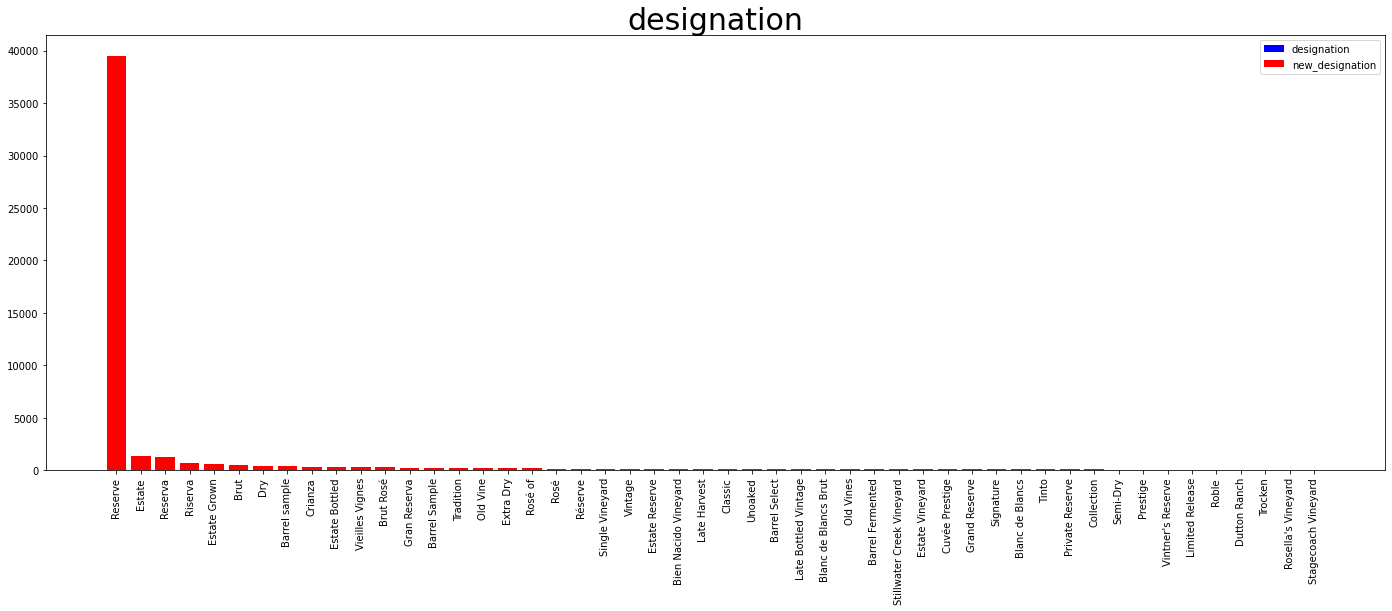

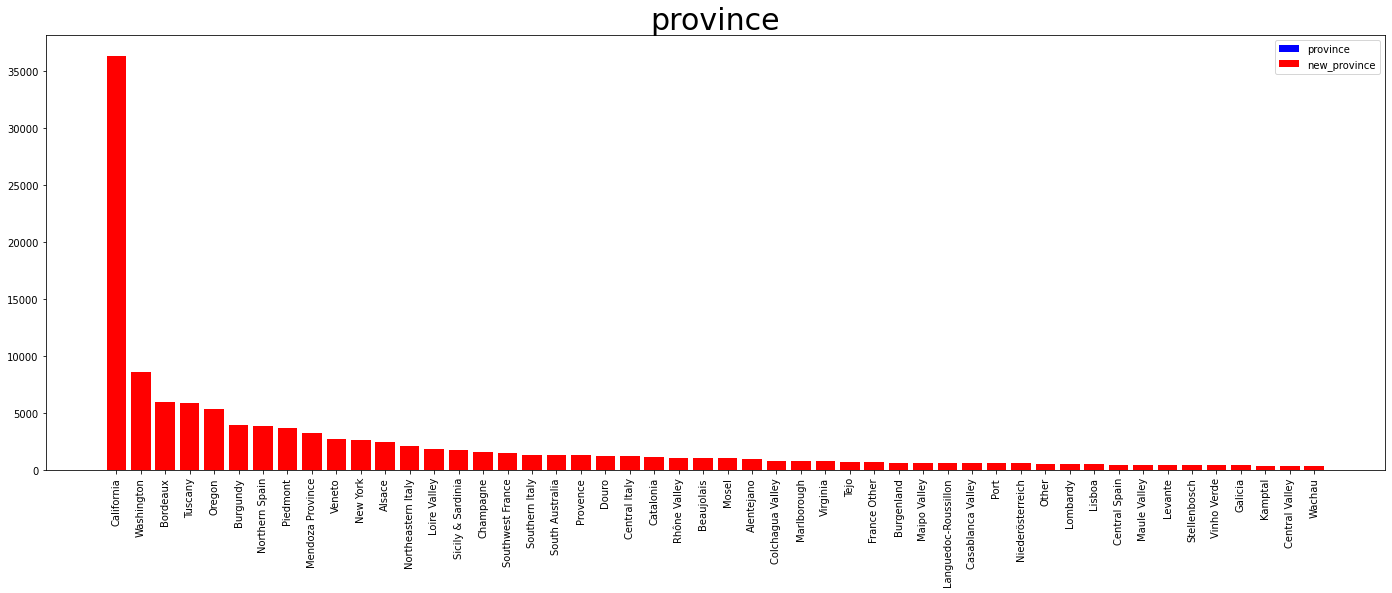

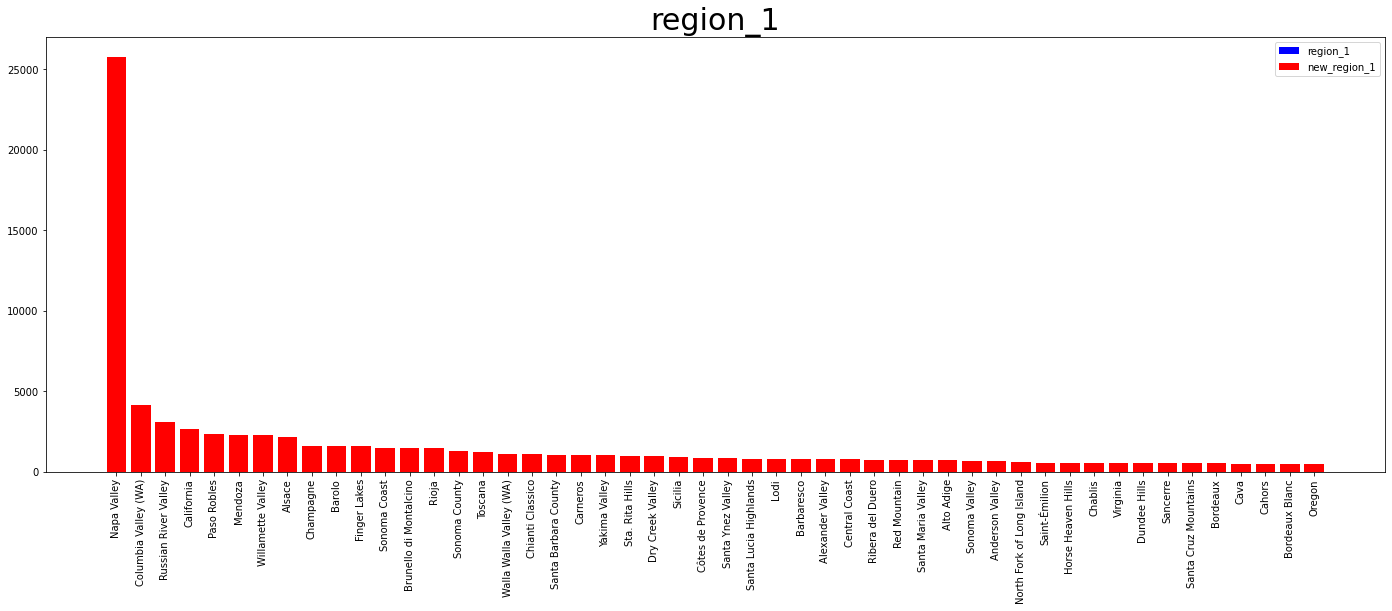

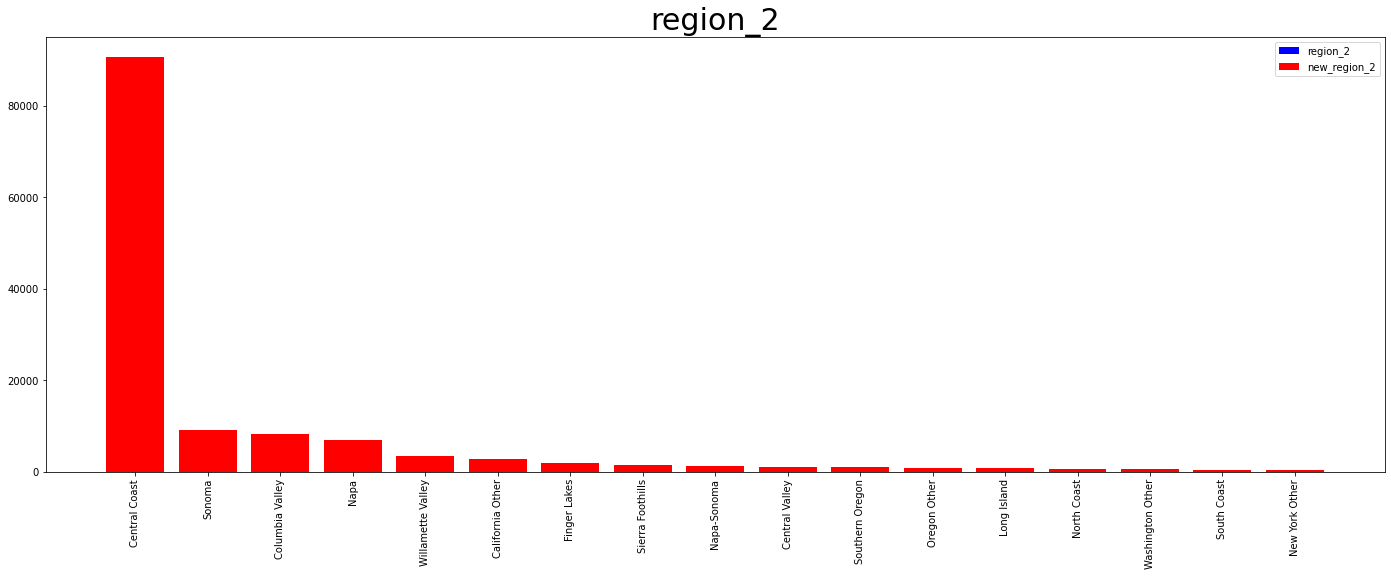

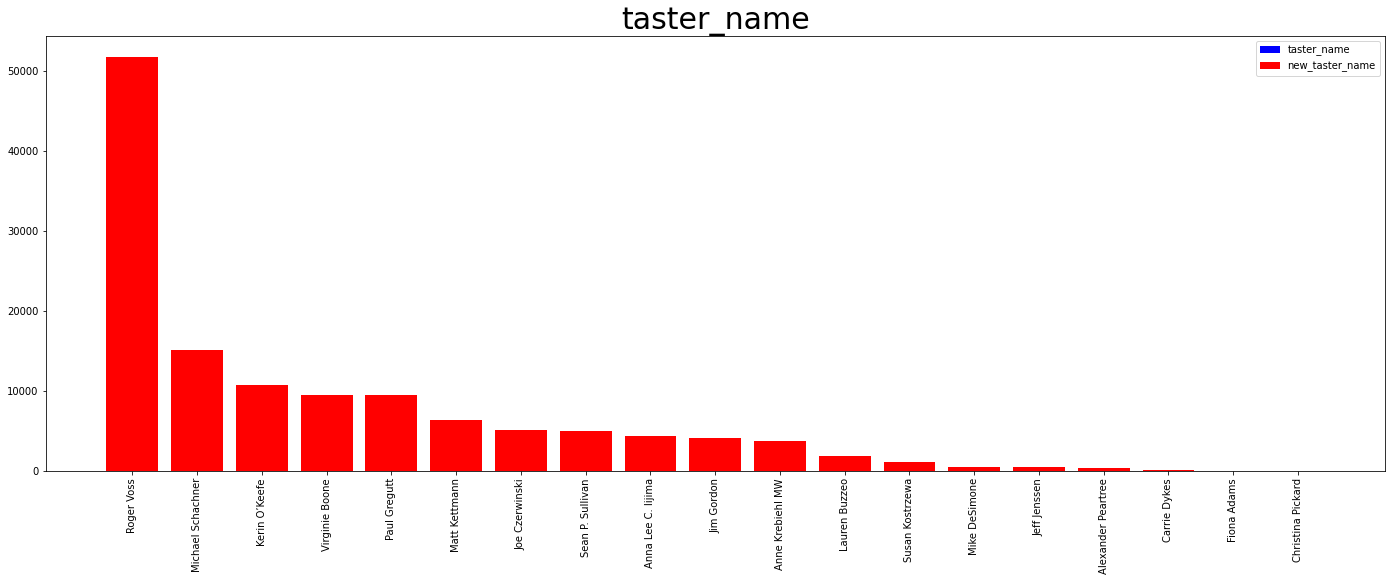

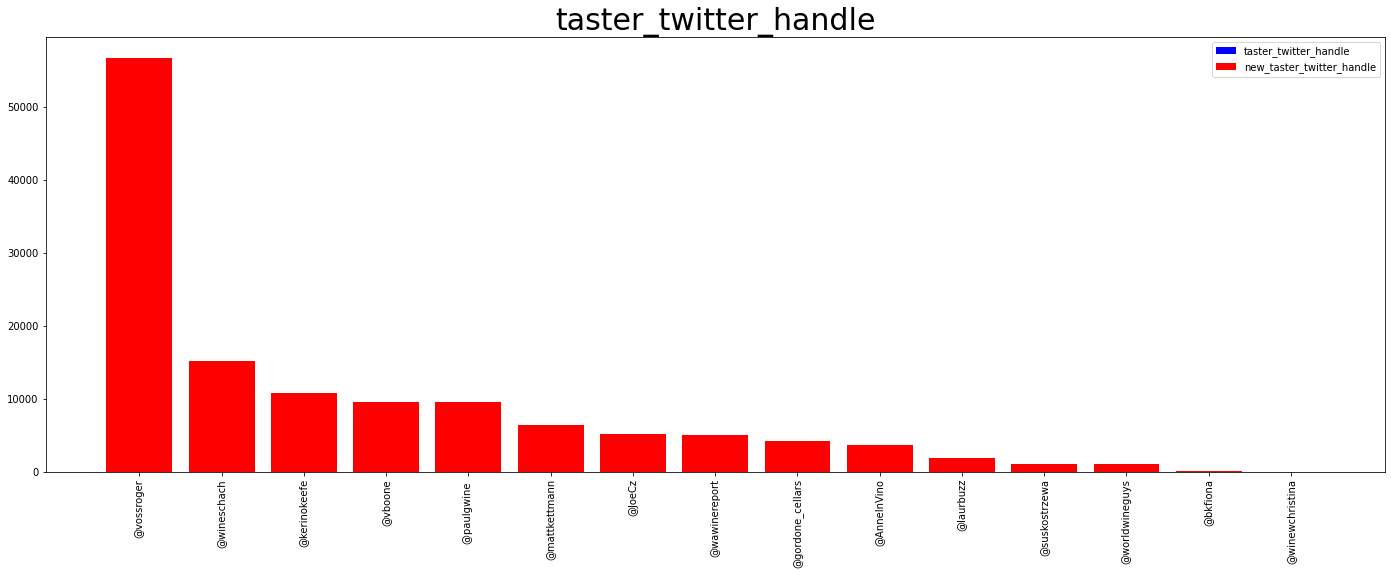

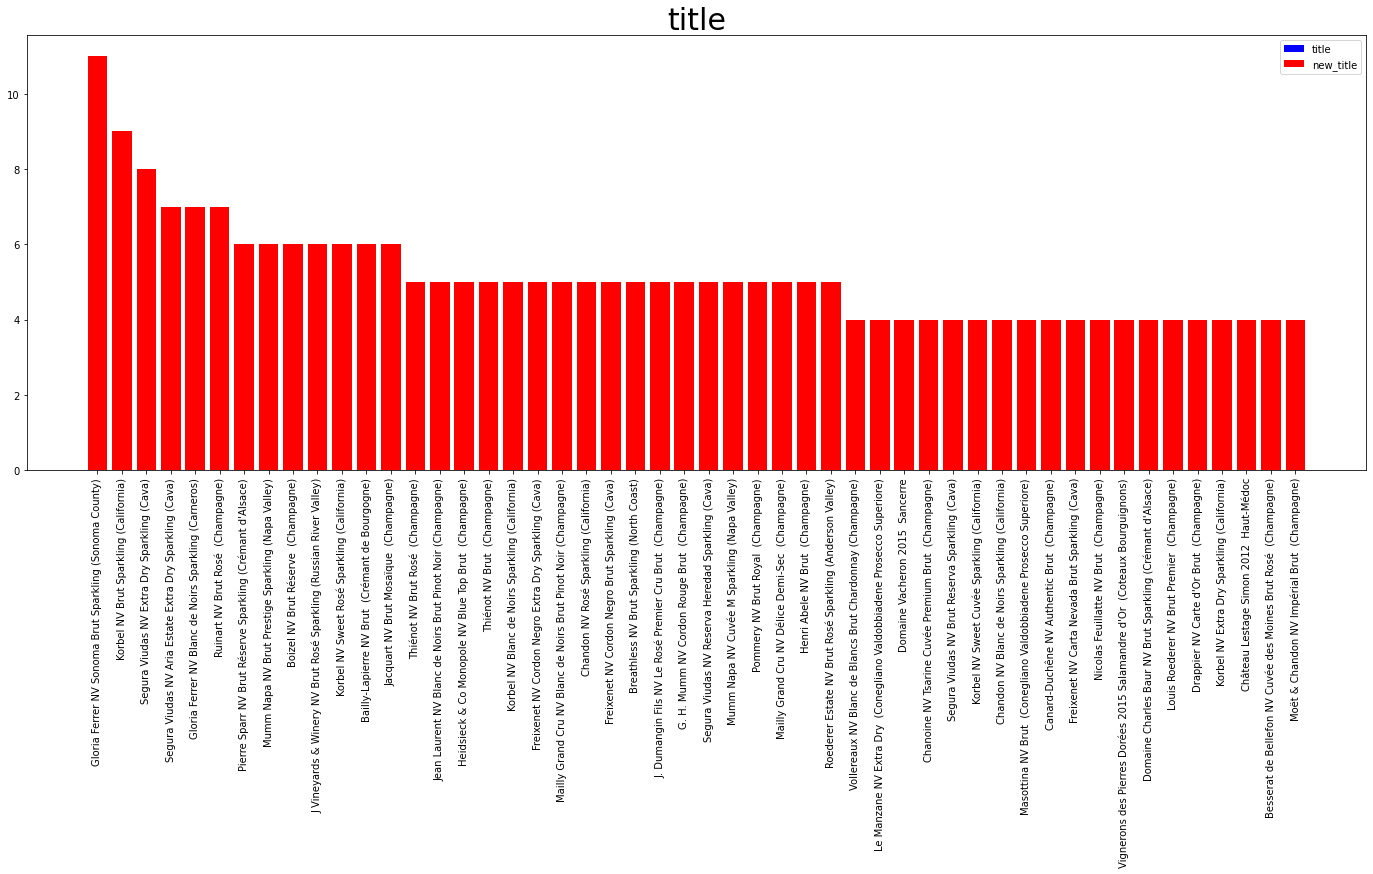

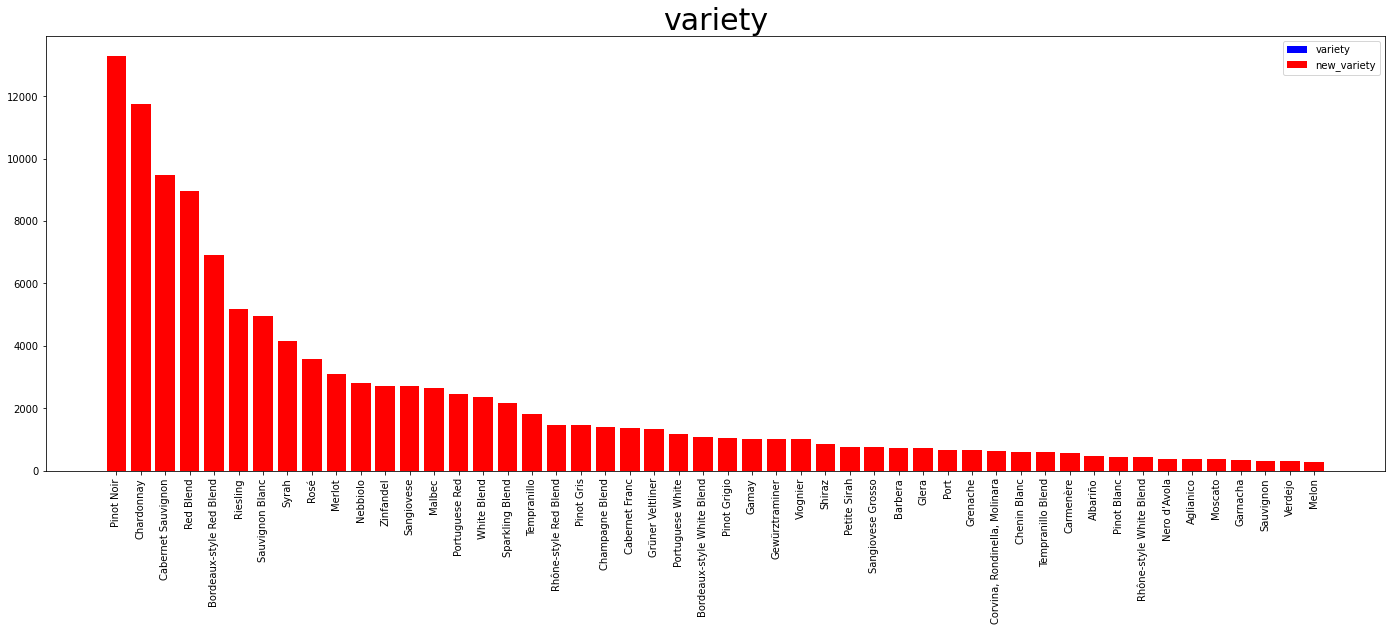

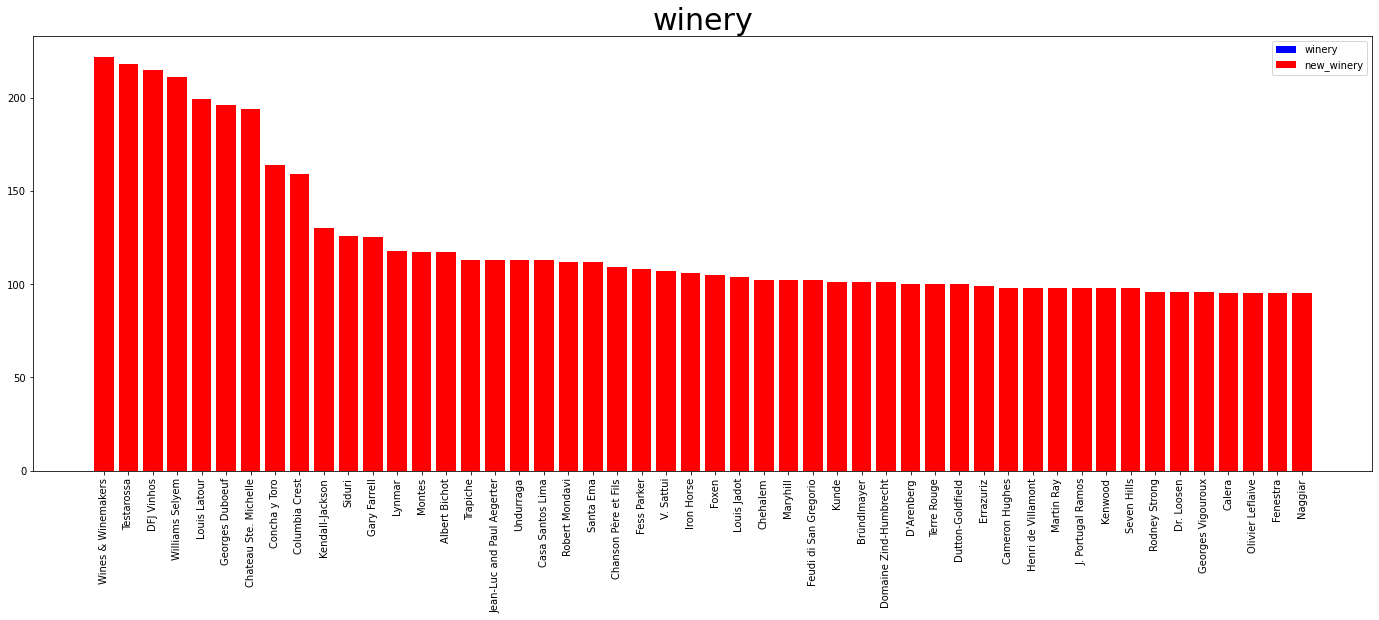

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000 
 new Missing: 0 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000
Missing: 8996

 new Min: 4.0000	Q1(25%): 18.0000 	Q2(50%): 25.0000 	Q3(75%): 40.0000 	Max: 3300.0000 
 new Missing: 0 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


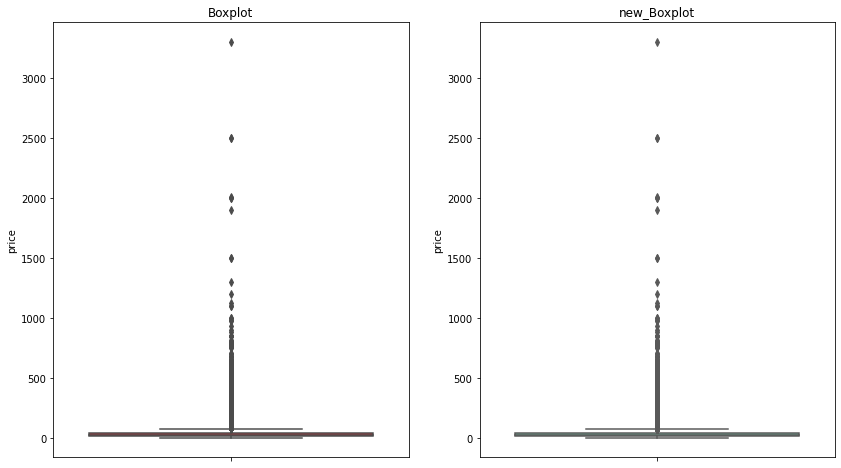

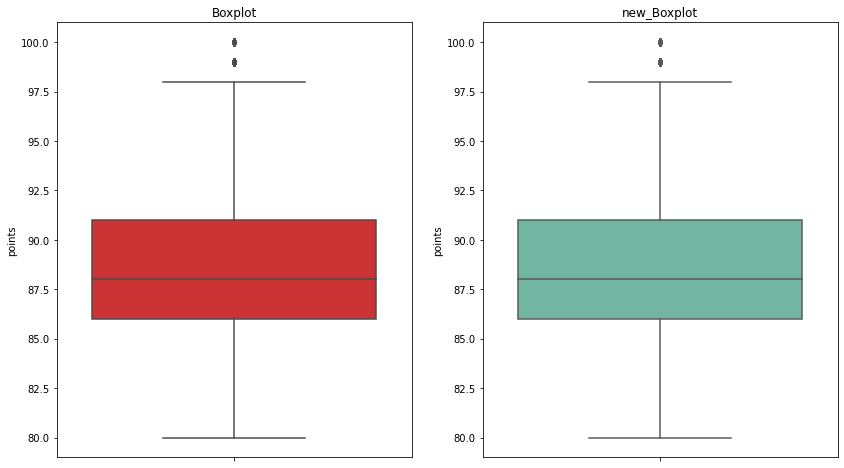

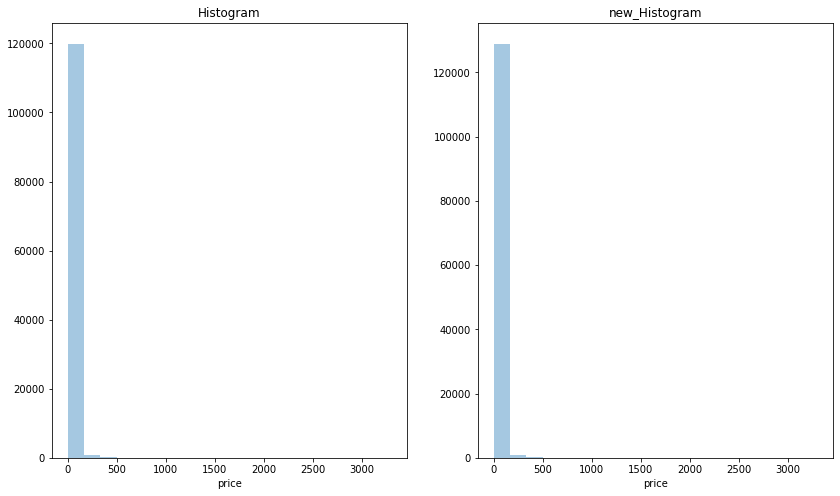

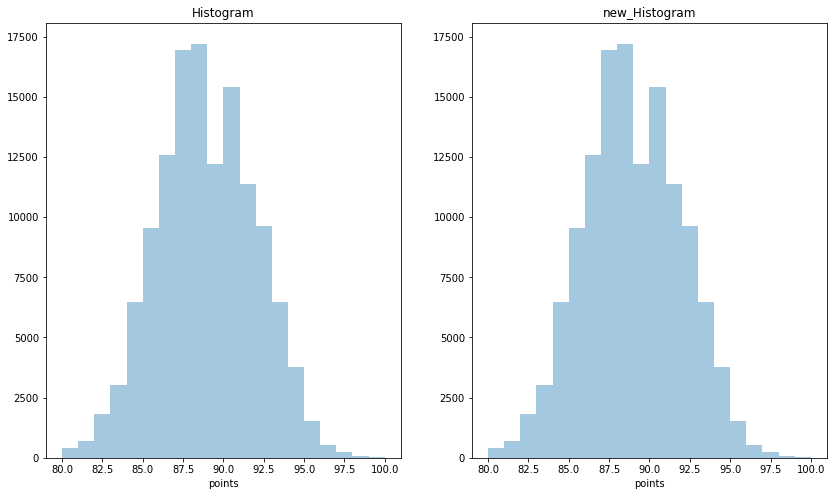

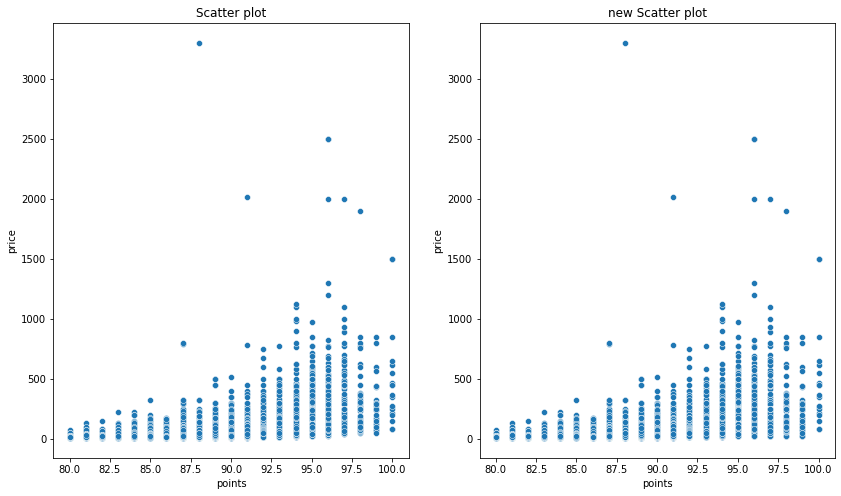

In [70]:
md130k=miss_mode_fill(winemag130k)
columns_info(winemag130k,show_shape=True,new_df=md130k)
nominal_summary(winemag130k,nominal_index=nominal_index,head_n=50,new_df=md130k)
numerical_summary(winemag130k,numerical_index=numerical_index,new_df=md130k)
viz_pairs(winemag130k,xlabel='points',ylabel='price',bins=20,new_df=md130k)

#### 3 通过属性的相关关系来填补缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB
None
(129971, 13)


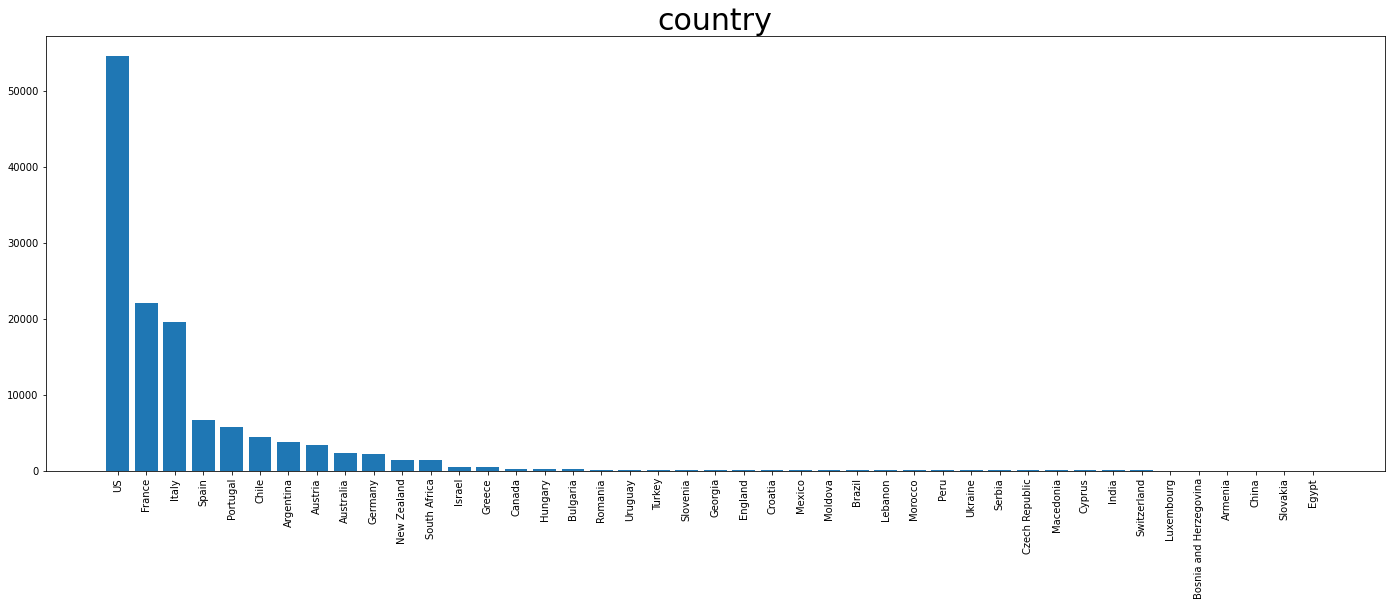

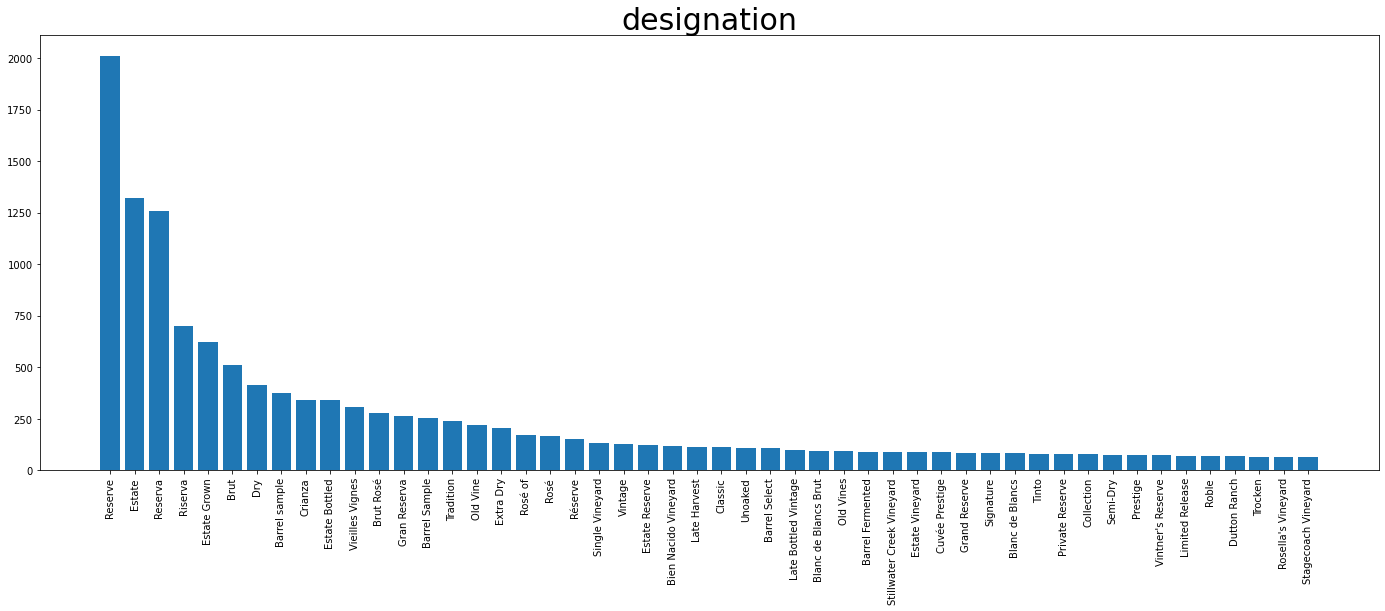

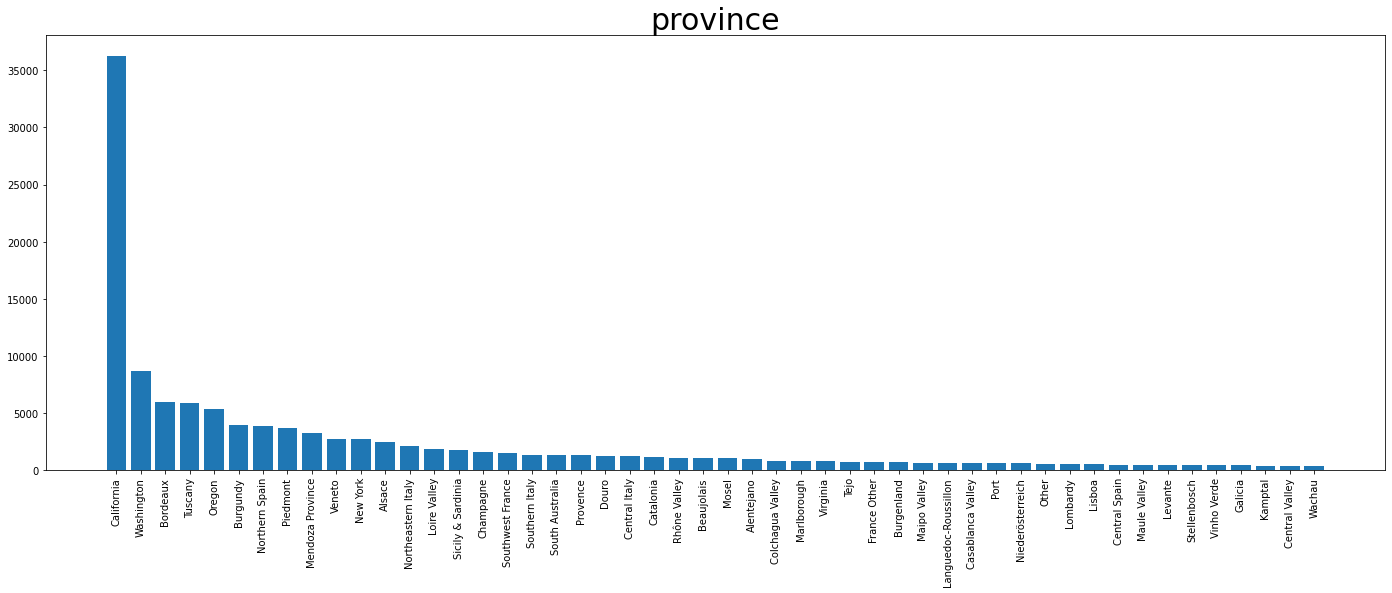

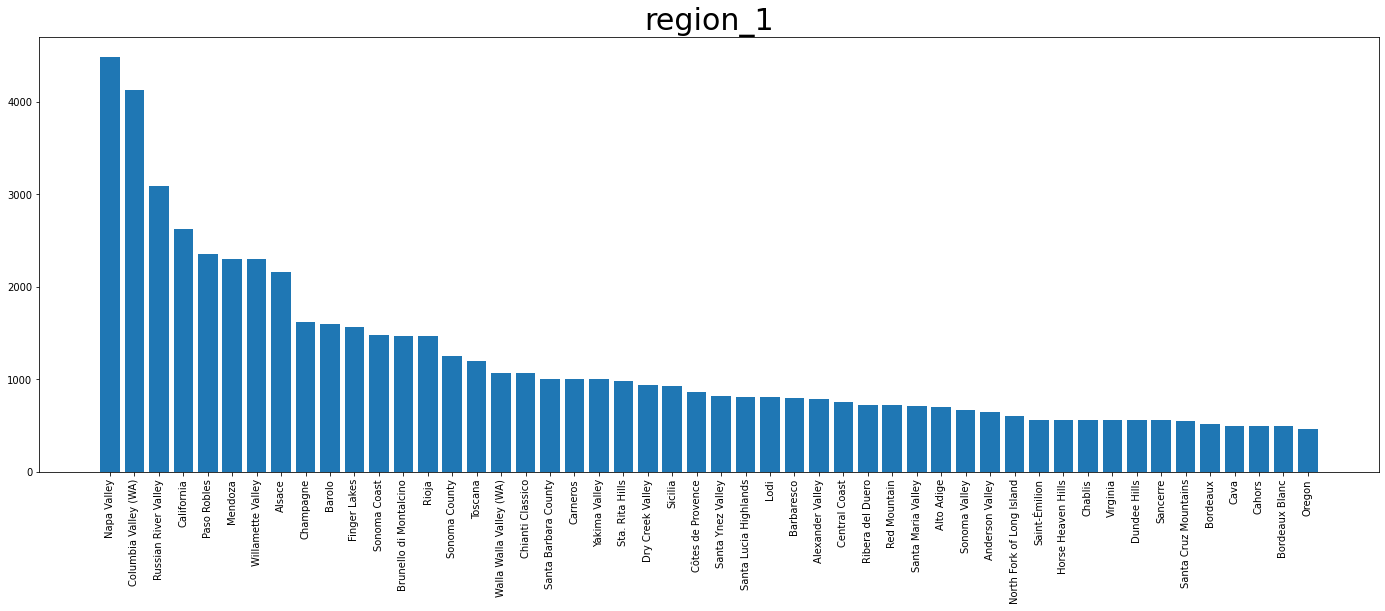

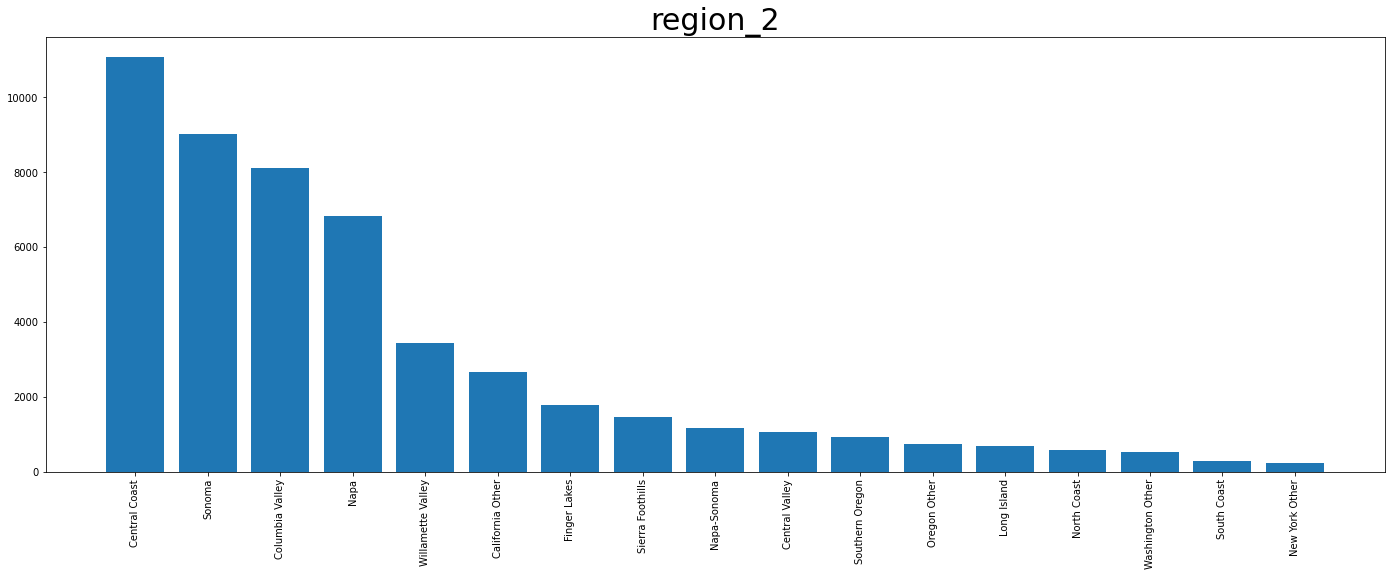

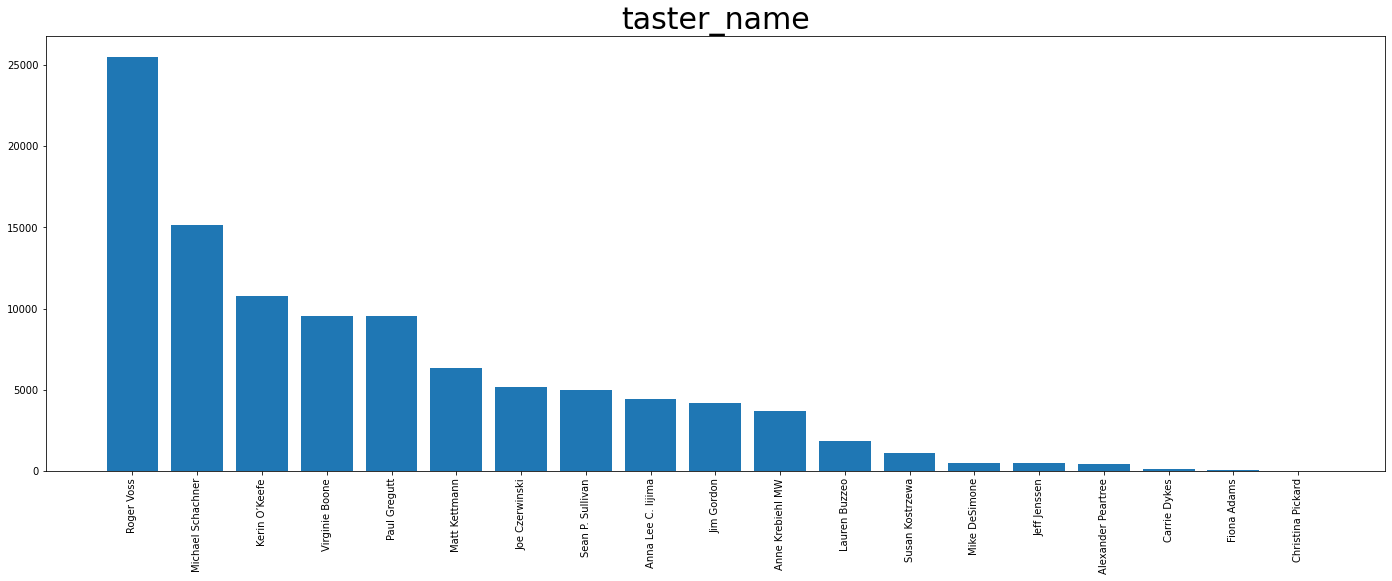

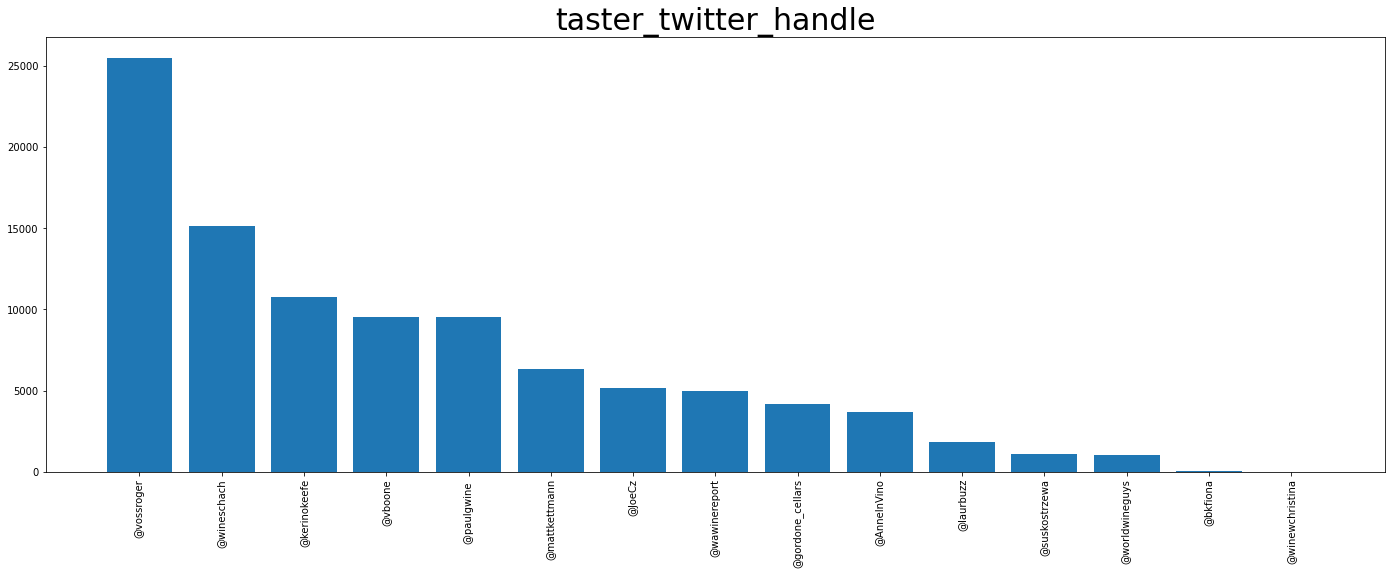

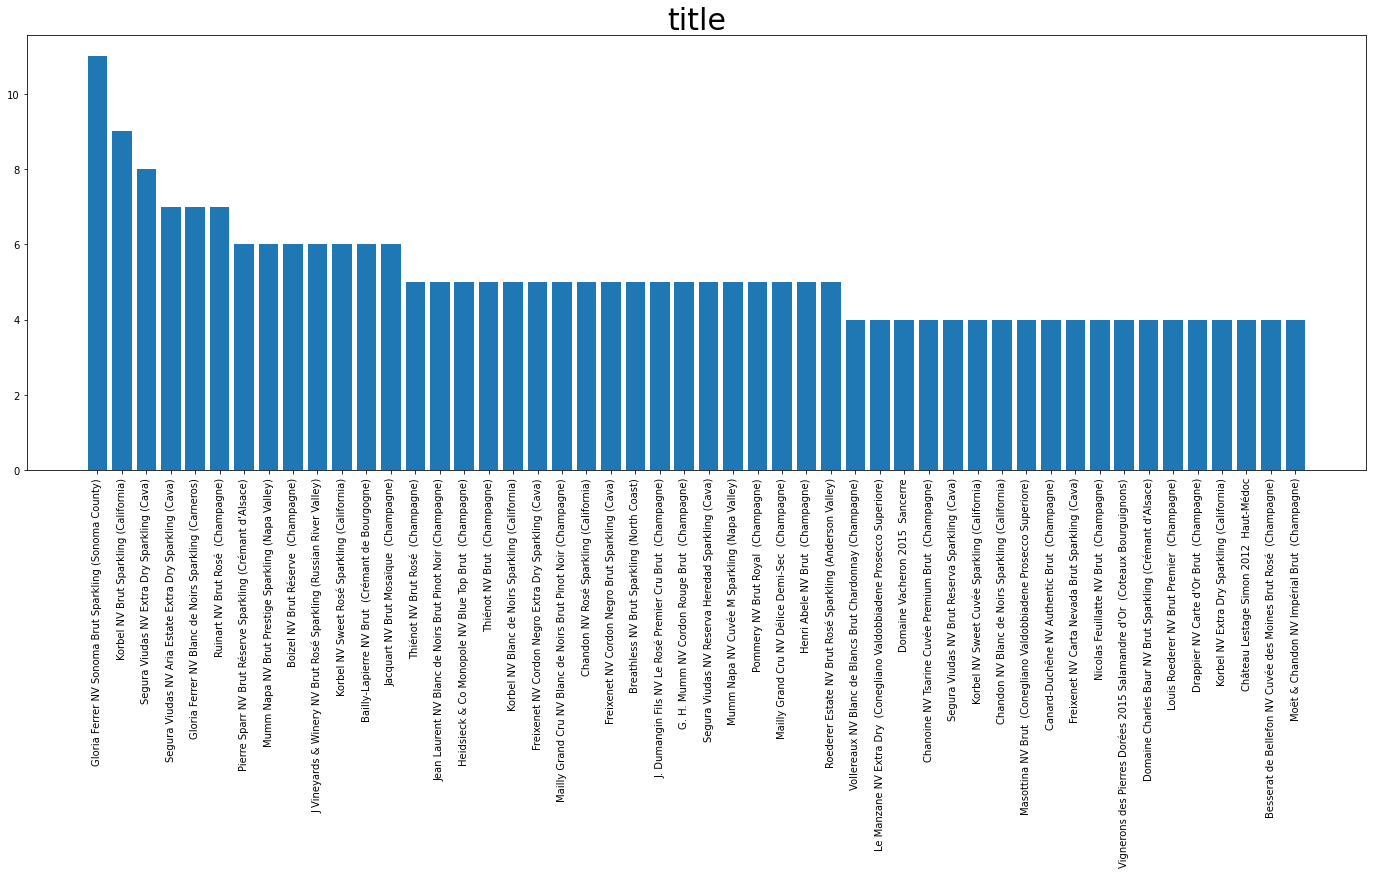

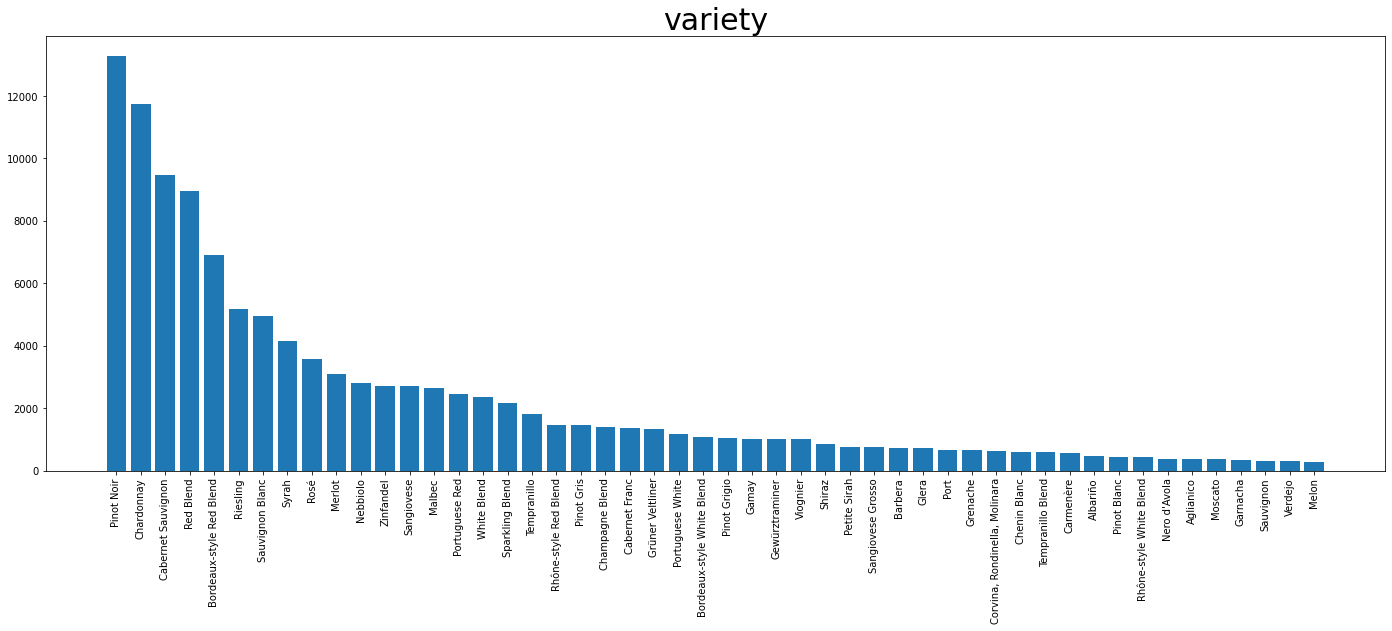

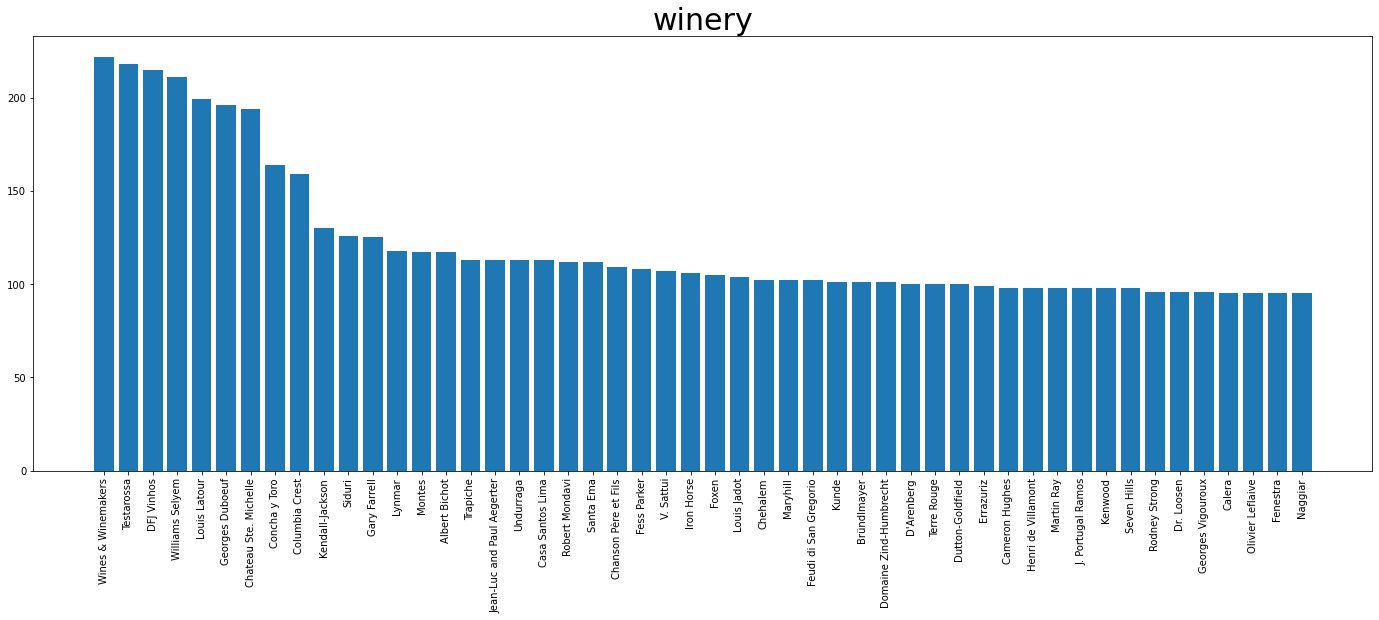

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000
Missing: 0

descriptive statistics (price):
Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000
Missing: 8996



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


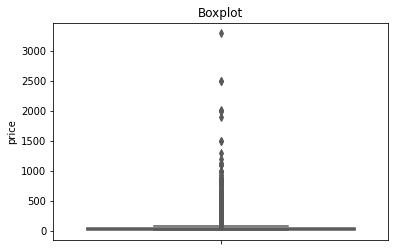

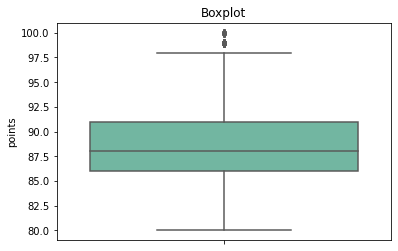

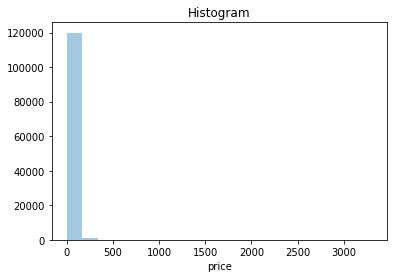

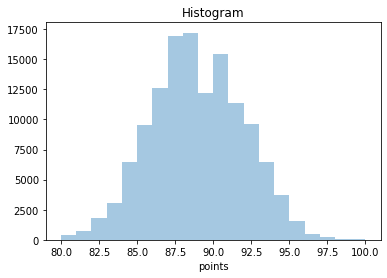

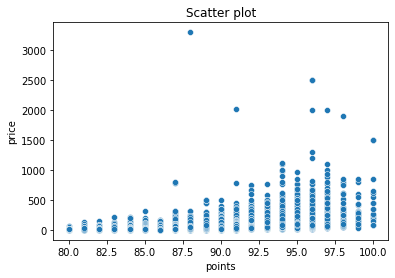

In [55]:
miss_index=['country','designation','price','province','region_1','region_2','taster_name','taster_twitter_handle','variety']
comp_index=['description','points','title','winery']
att130k=attr_corr_fill(winemag130k,miss_index=miss_index,complete_index=comp_index)
columns_info(winemag130k,show_shape=True,new_df=att130k)
nominal_summary(winemag130k,nominal_index=nominal_index,head_n=50,new_df=att130k)
numerical_summary(winemag130k,numerical_index=numerical_index,new_df=att130k)
viz_pairs(winemag130k,xlabel='points',ylabel='price',bins=20,new_df=att130k)

#### 4 通过数据对象之间的相似性来填补缺失值

c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\impyute\imputation\cs\fast_knn.py:113: RuntimeWarning: invalid value encountered in true_divide
  weights = distances/np.sum(distances)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB
None
(129971, 13)

<class 'pan

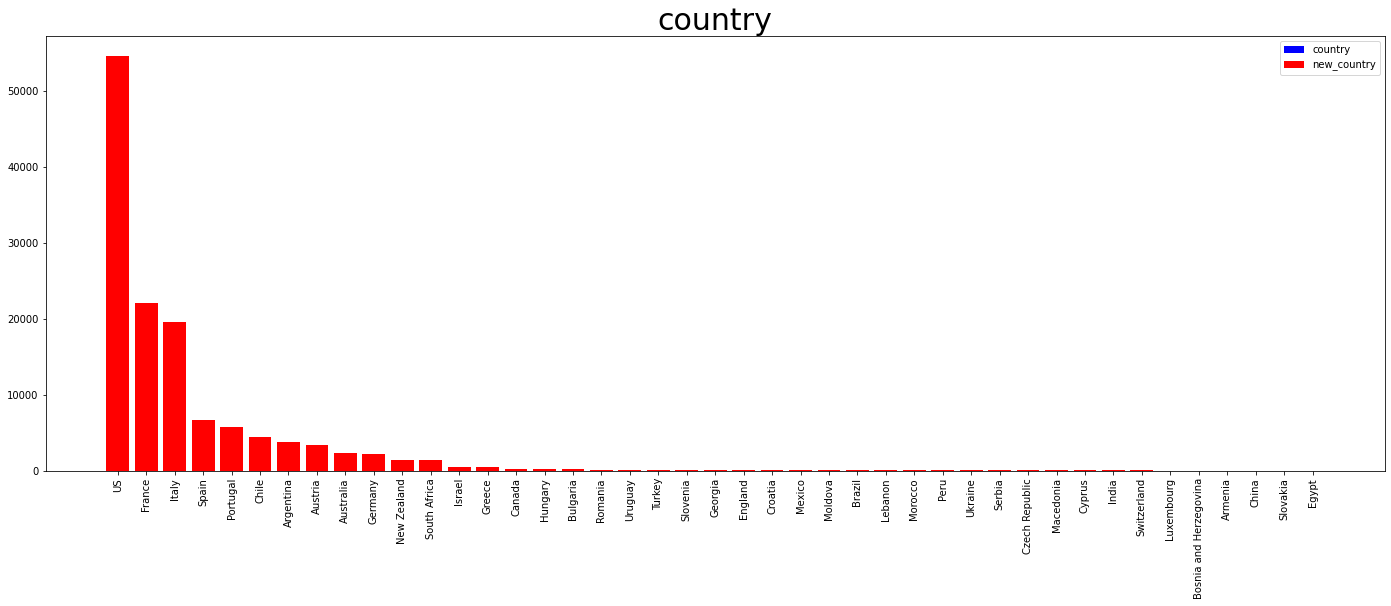

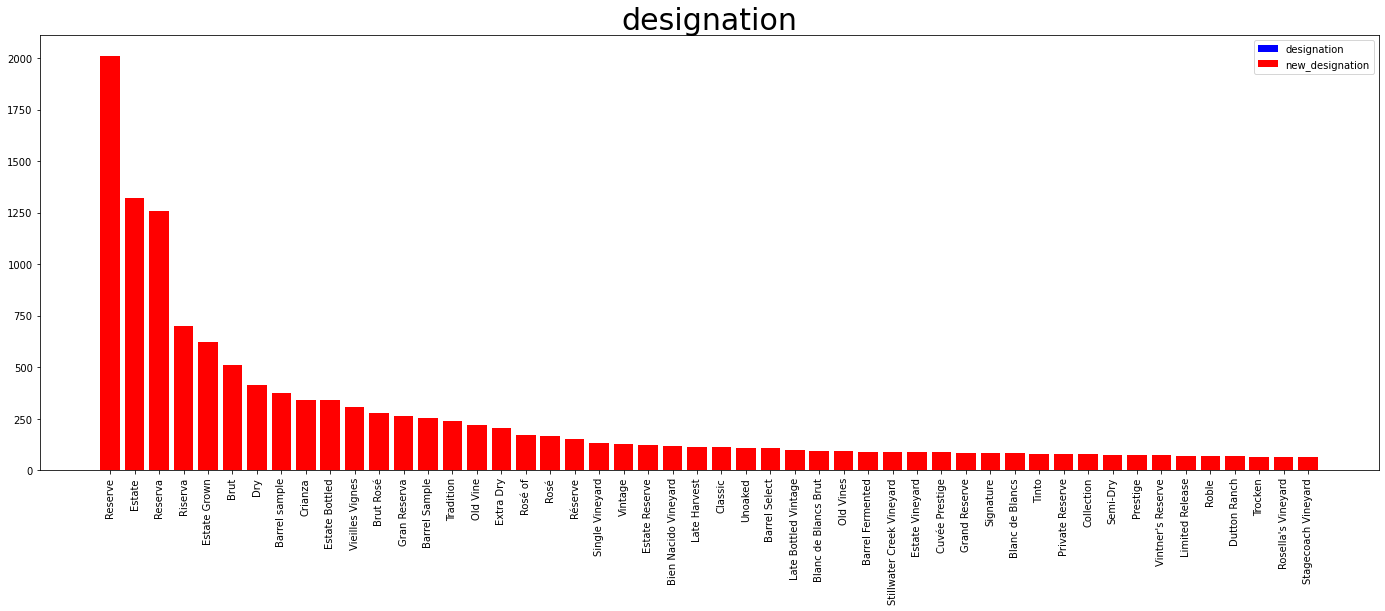

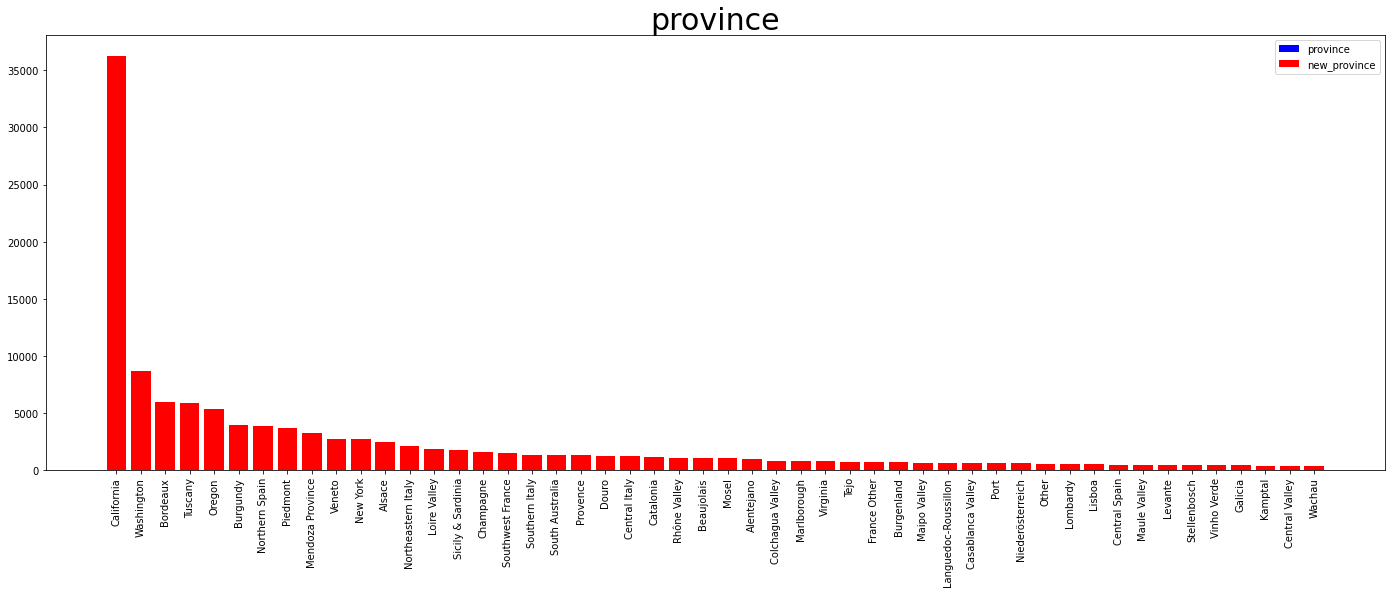

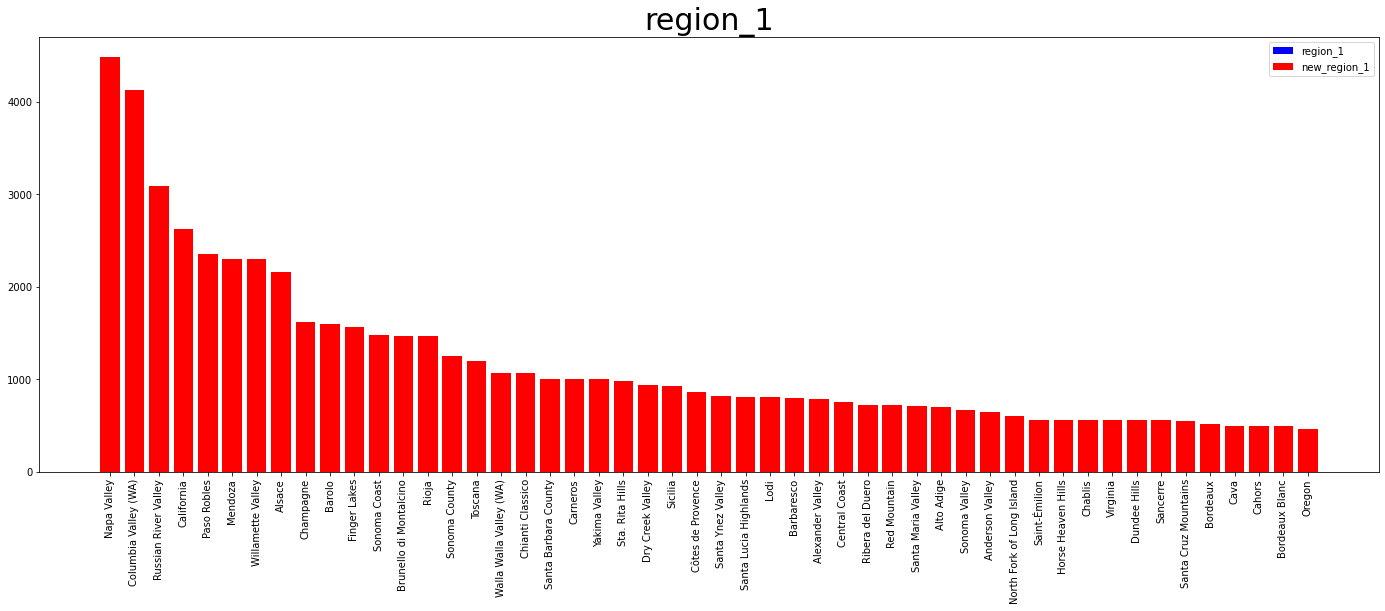

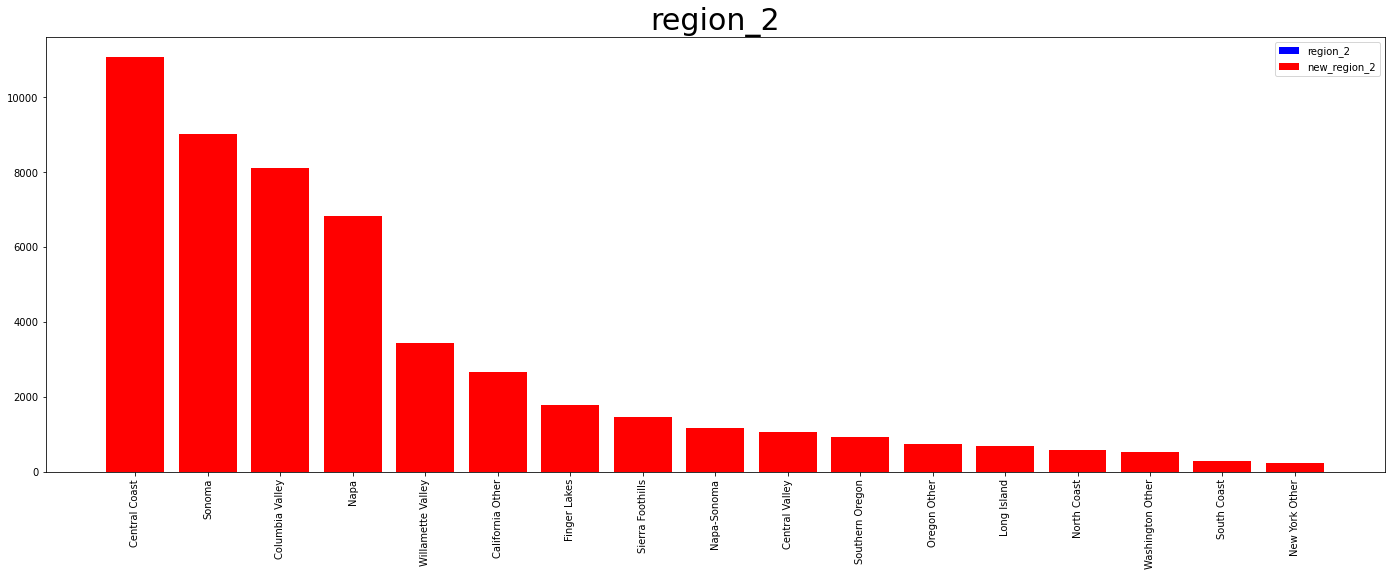

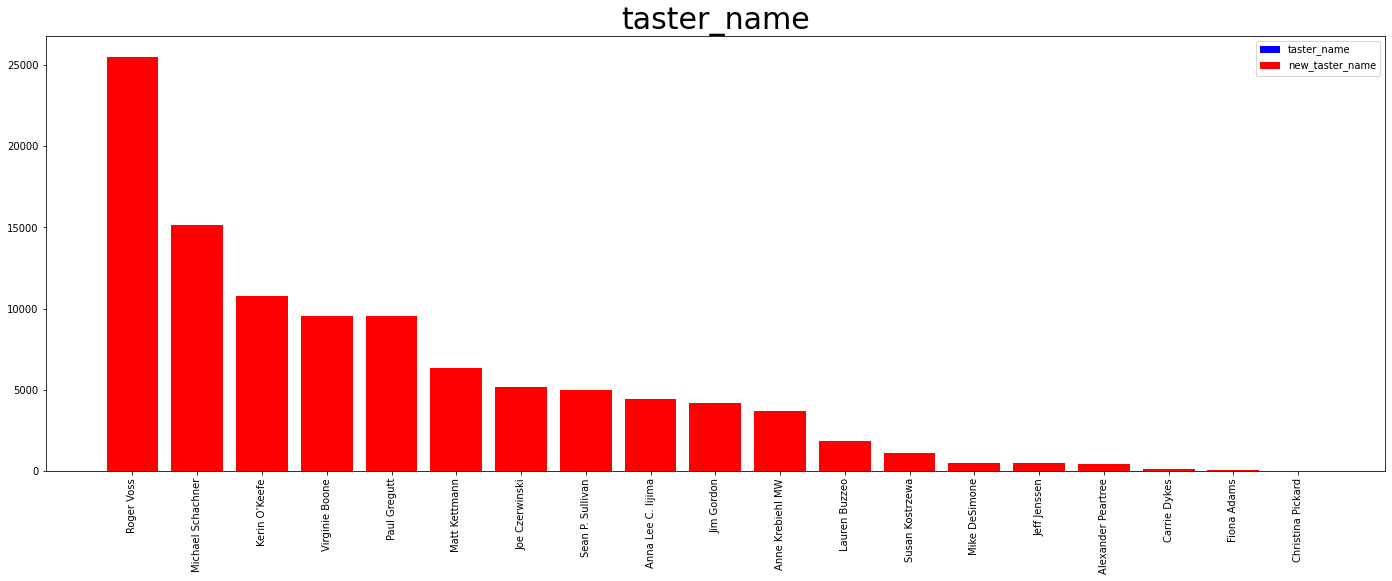

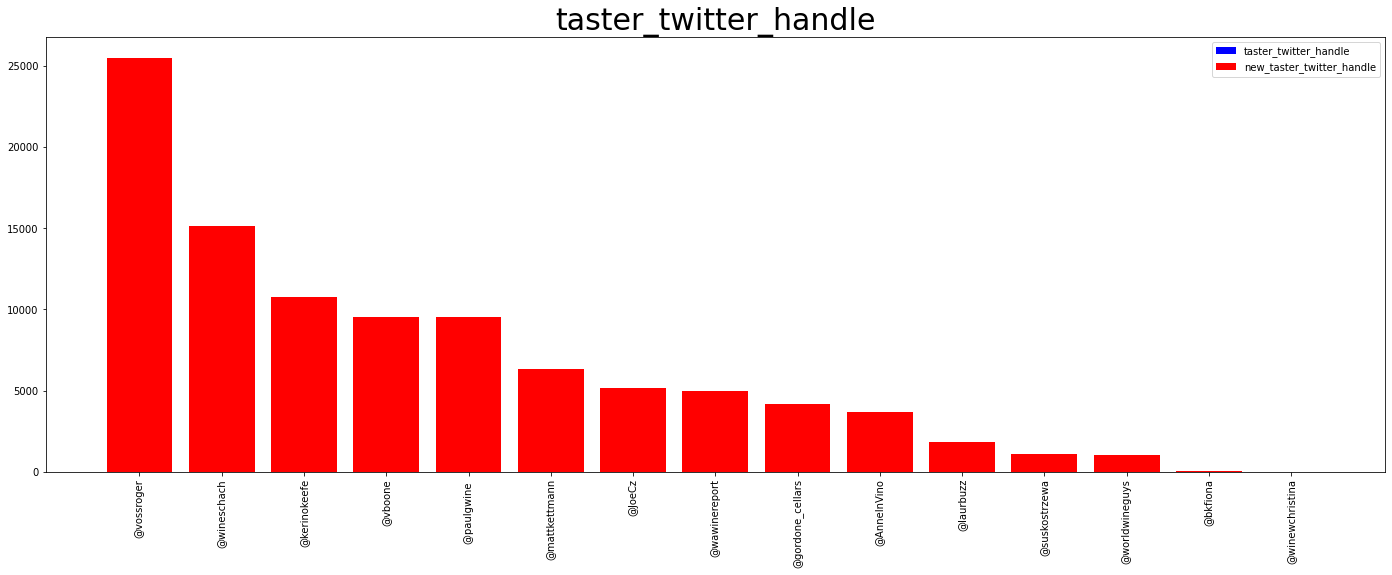

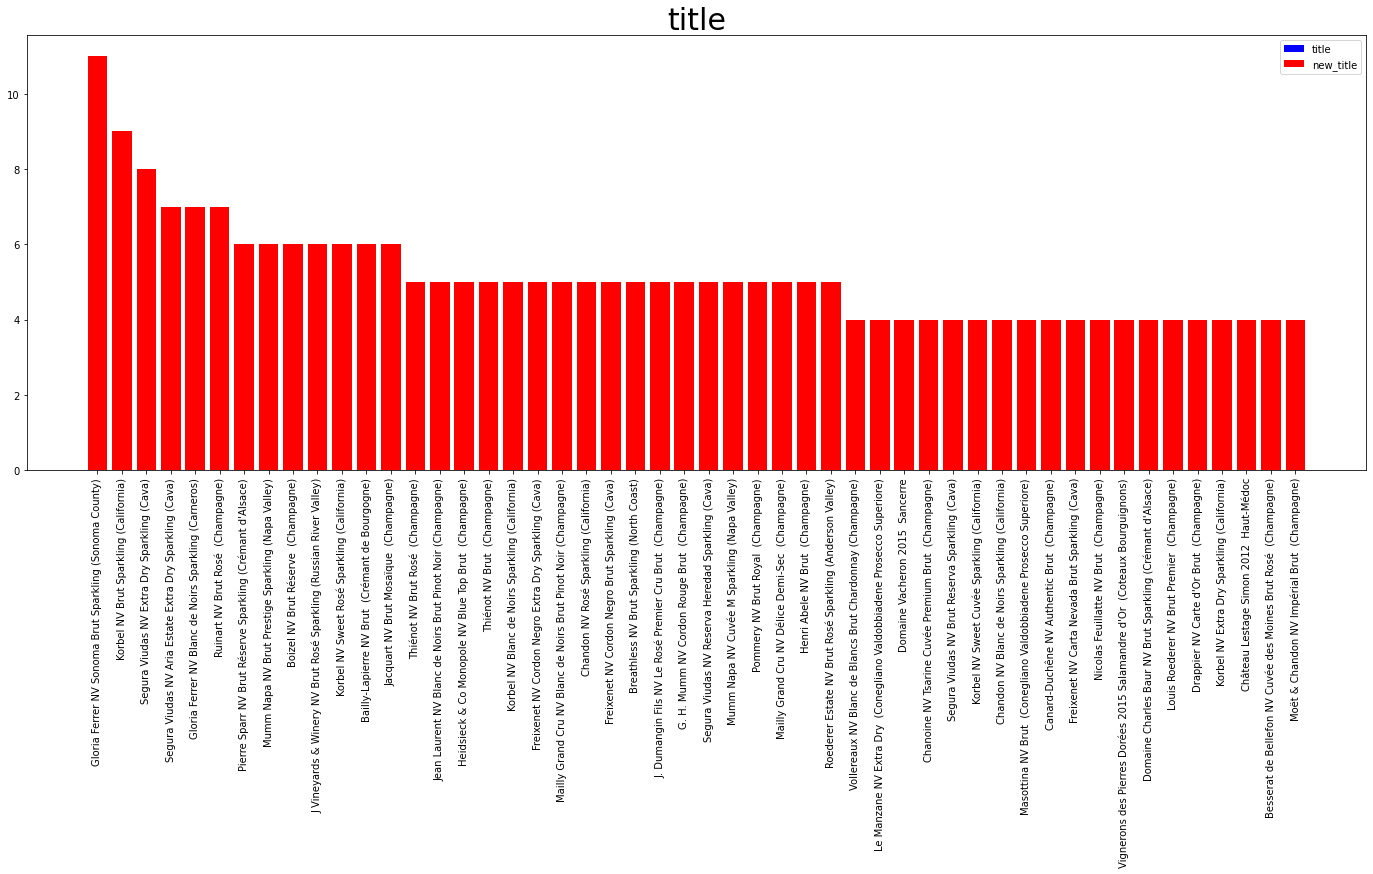

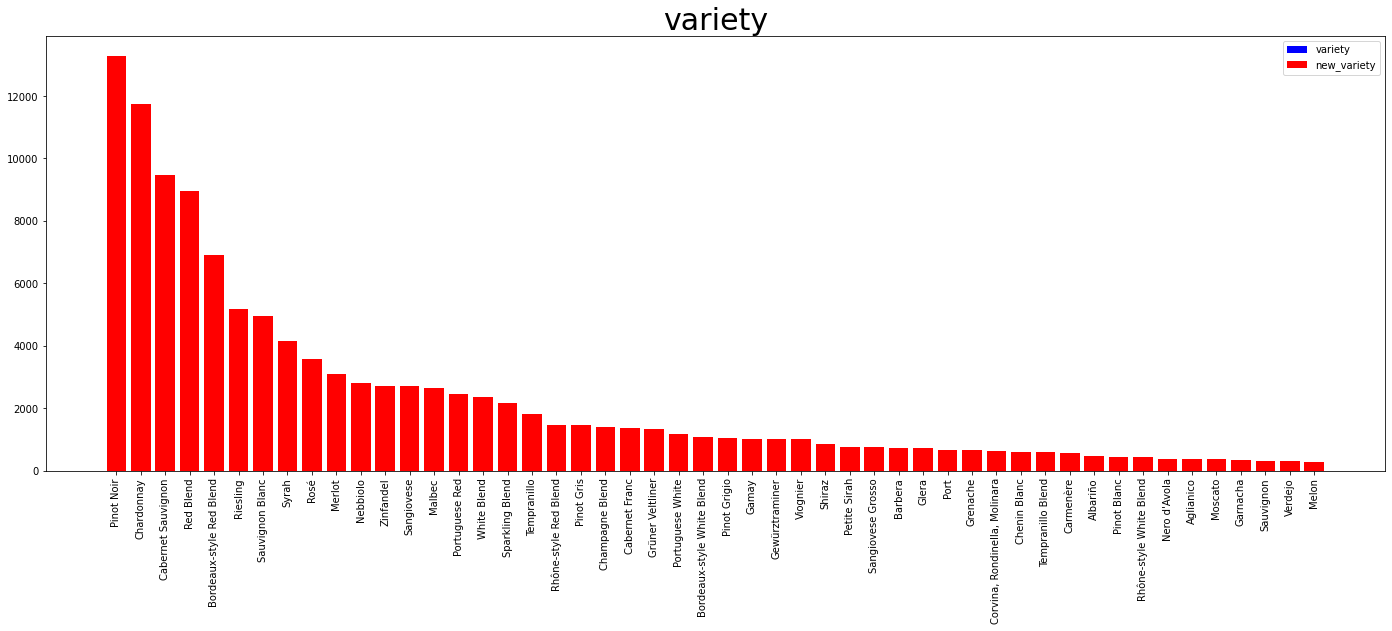

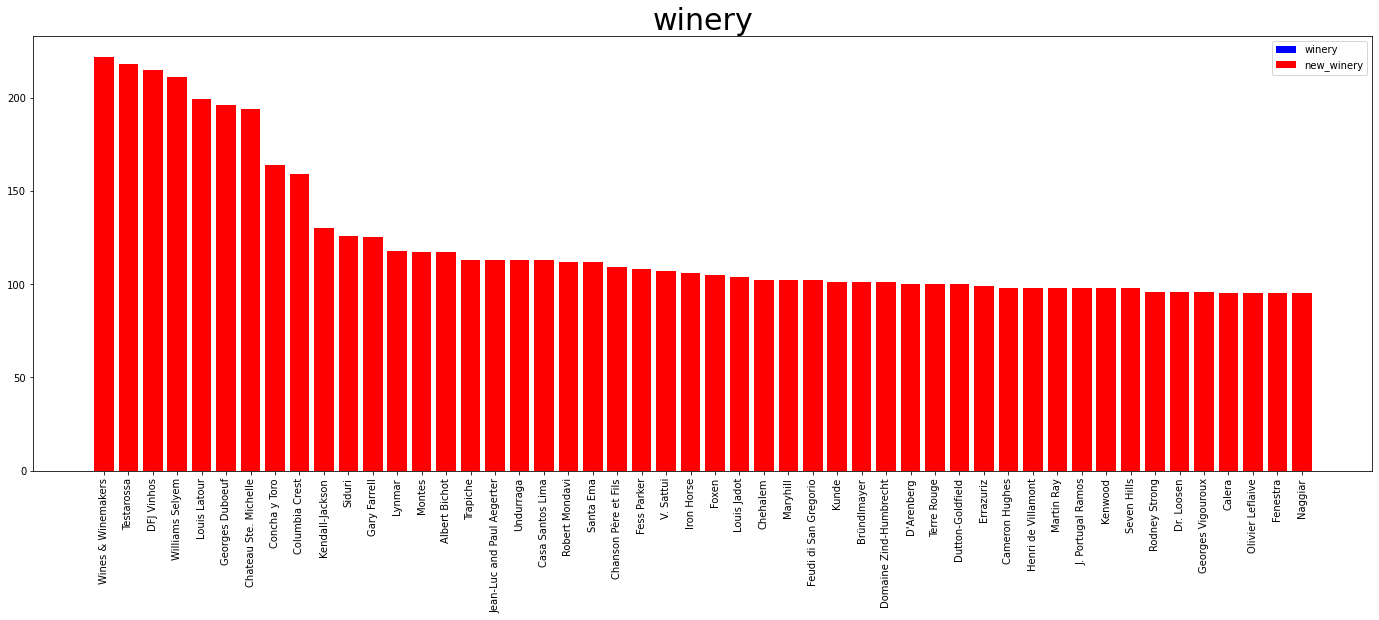

descriptive statistics (points):
Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000
Missing: 0

 new Min: 80.0000	Q1(25%): 86.0000 	Q2(50%): 88.0000 	Q3(75%): 91.0000 	Max: 100.0000 
 new Missing: 0 

descriptive statistics (price):
Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000
Missing: 8996

 new Min: 4.0000	Q1(25%): 17.0000 	Q2(50%): 25.0000 	Q3(75%): 42.0000 	Max: 3300.0000 
 new Missing: 8946 



c:\users\liuxiaochen\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


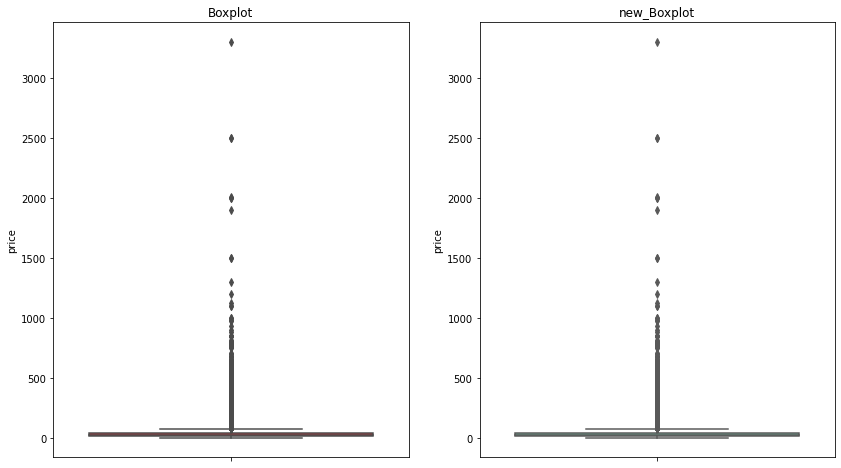

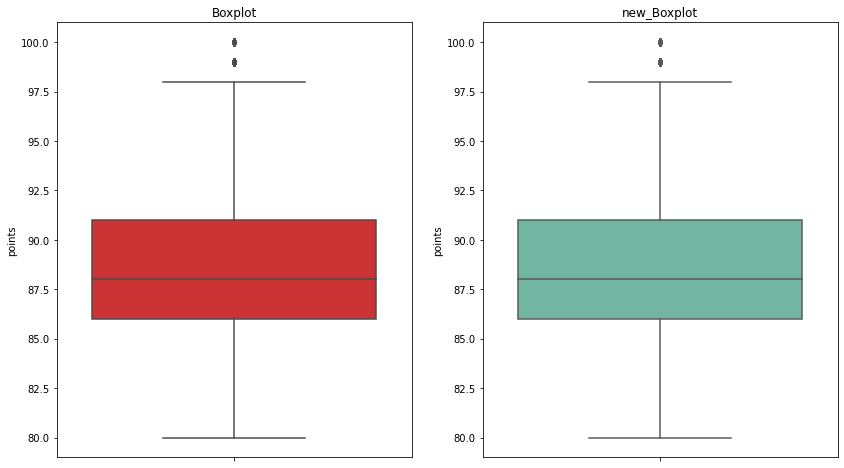

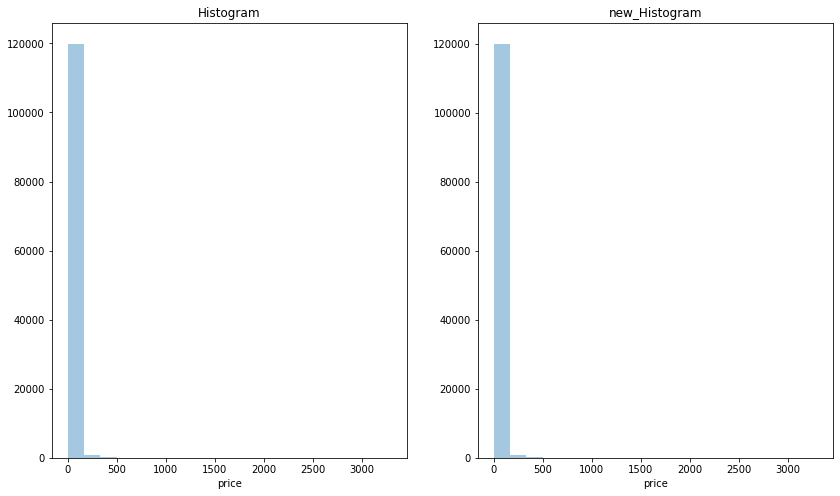

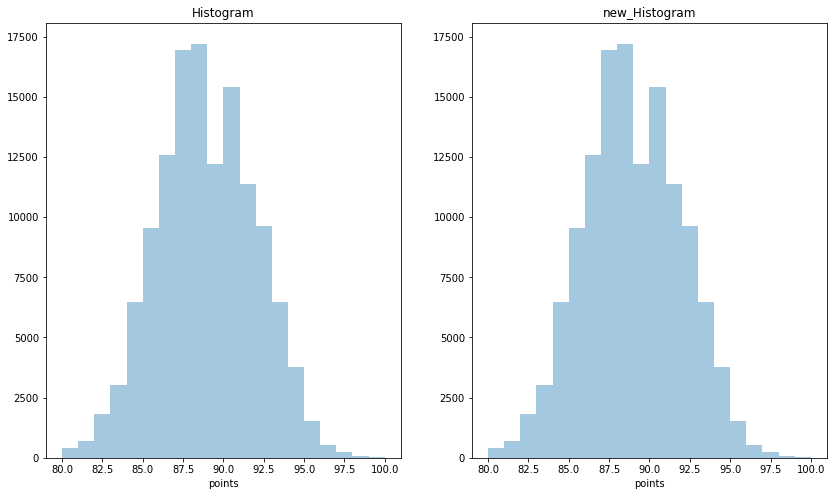

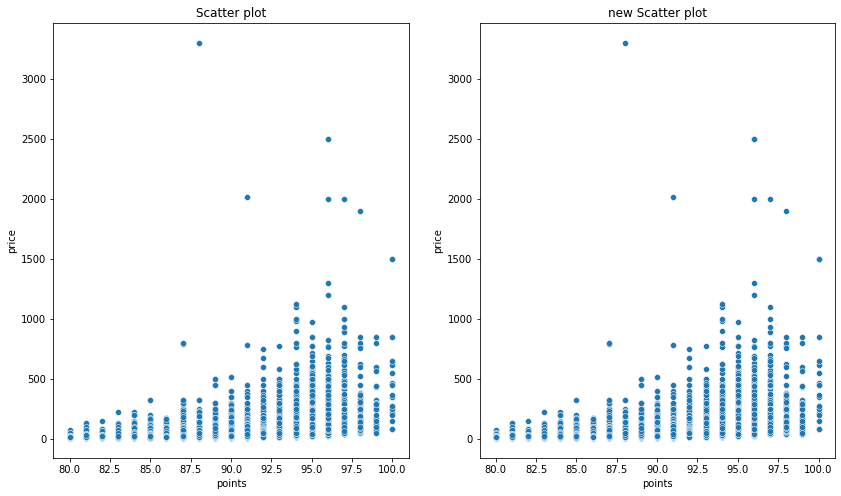

In [56]:
obj130k=obj_corr_fill(winemag130k,numerical_index=numerical_index,k=10)
columns_info(winemag130k,show_shape=True,new_df=obj130k)
nominal_summary(winemag130k,nominal_index=nominal_index,head_n=50,new_df=obj130k)
numerical_summary(winemag130k,numerical_index=numerical_index,new_df=obj130k)
viz_pairs(winemag130k,xlabel='points',ylabel='price',bins=20,new_df=obj130k)

# 数据集2 - Chicago Building Violations
From City of Chicago Open Data
* building-violations

## building-violations.csv

In [71]:
# 读取文件
build_dir = "C:/Users/liuxiaochen/Desktop/DM-work1/2building"
building=pd.read_csv(build_dir + "/building-violations.csv",sep=',',header='infer') 

In [72]:
columns_info(building)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677788 entries, 0 to 1677787
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   ID                            1677788 non-null  int64  
 1   VIOLATION LAST MODIFIED DATE  1677788 non-null  object 
 2   VIOLATION DATE                1677788 non-null  object 
 3   VIOLATION CODE                1677788 non-null  object 
 4   VIOLATION STATUS              1677788 non-null  object 
 5   VIOLATION STATUS DATE         641589 non-null   object 
 6   VIOLATION DESCRIPTION         1667020 non-null  object 
 7   VIOLATION LOCATION            780506 non-null   object 
 8   VIOLATION INSPECTOR COMMENTS  1502325 non-null  object 
 9   VIOLATION ORDINANCE           1630207 non-null  object 
 10  INSPECTOR ID                  1677788 non-null  object 
 11  INSPECTION NUMBER             1677788 non-null  int64  
 12  INSPECTION STATUS           

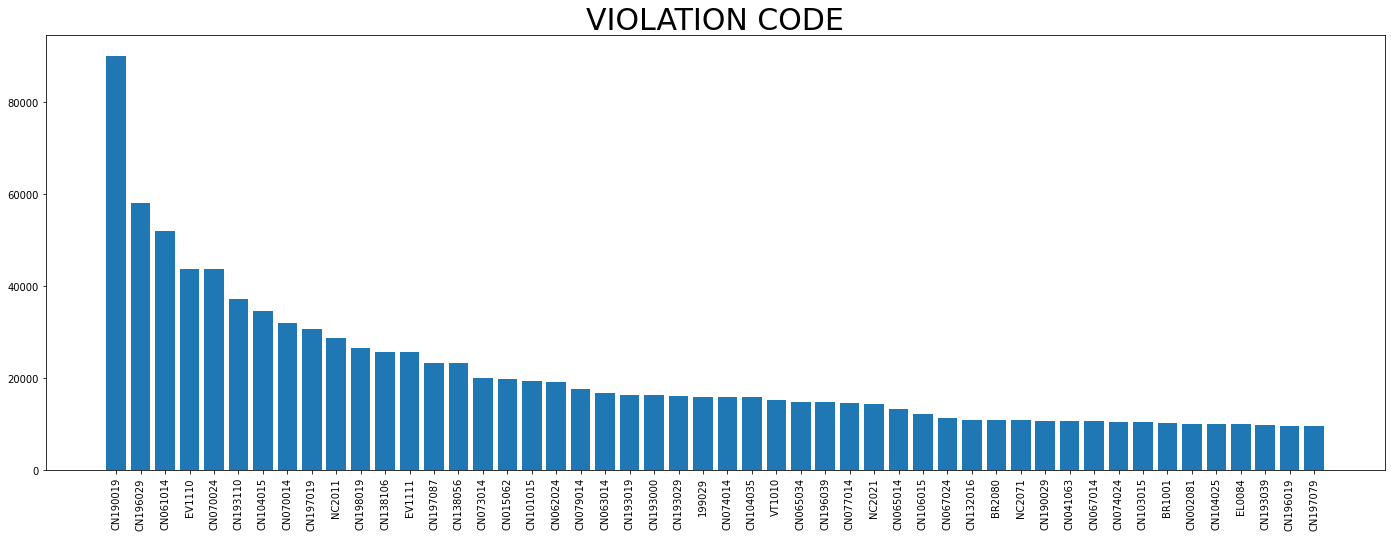

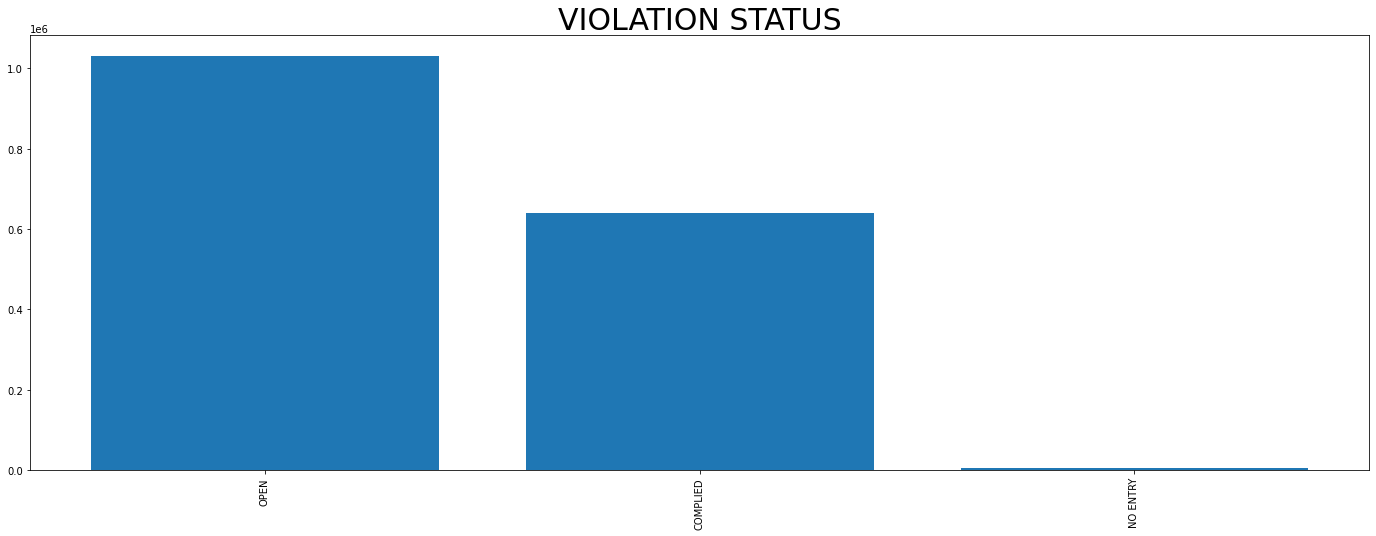

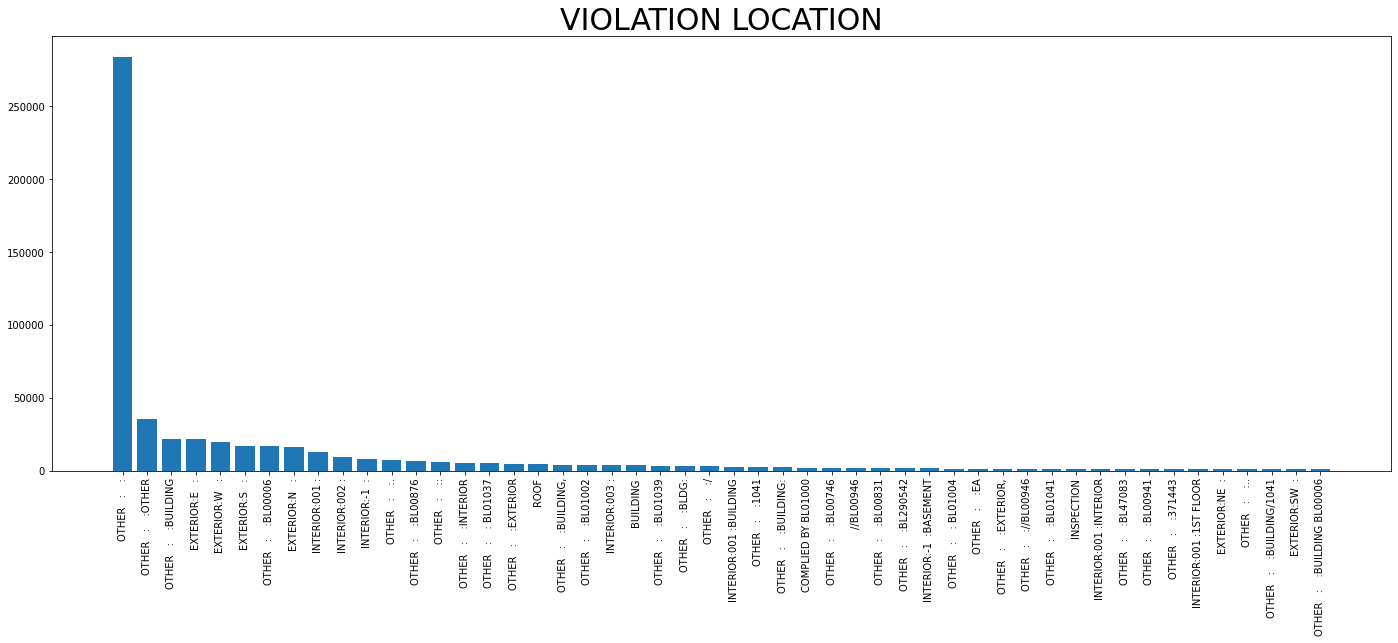

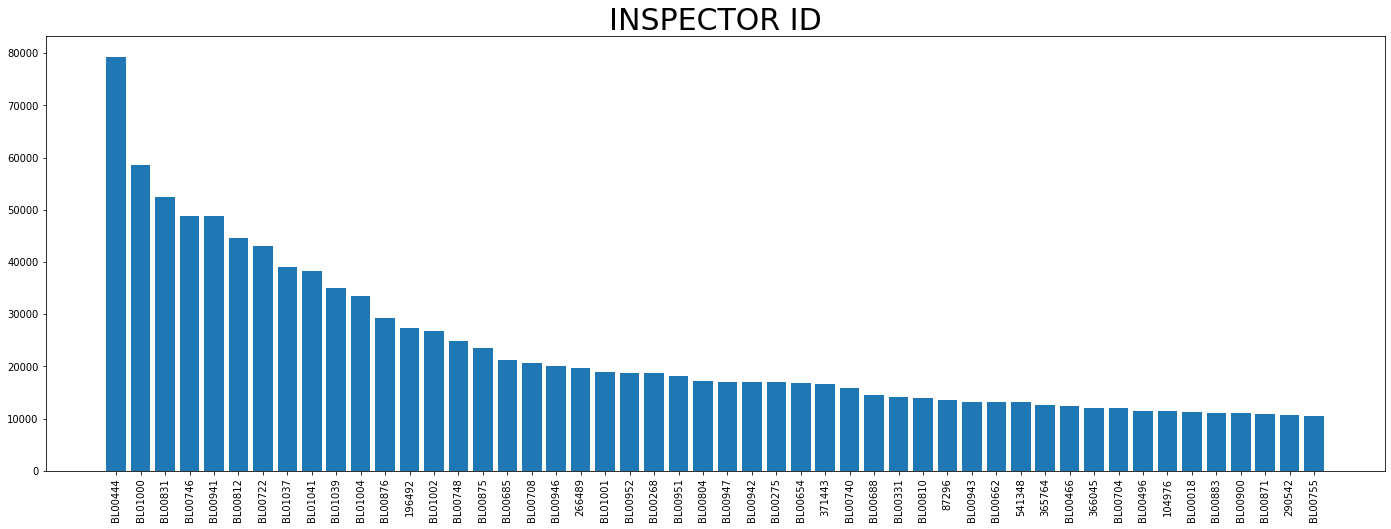

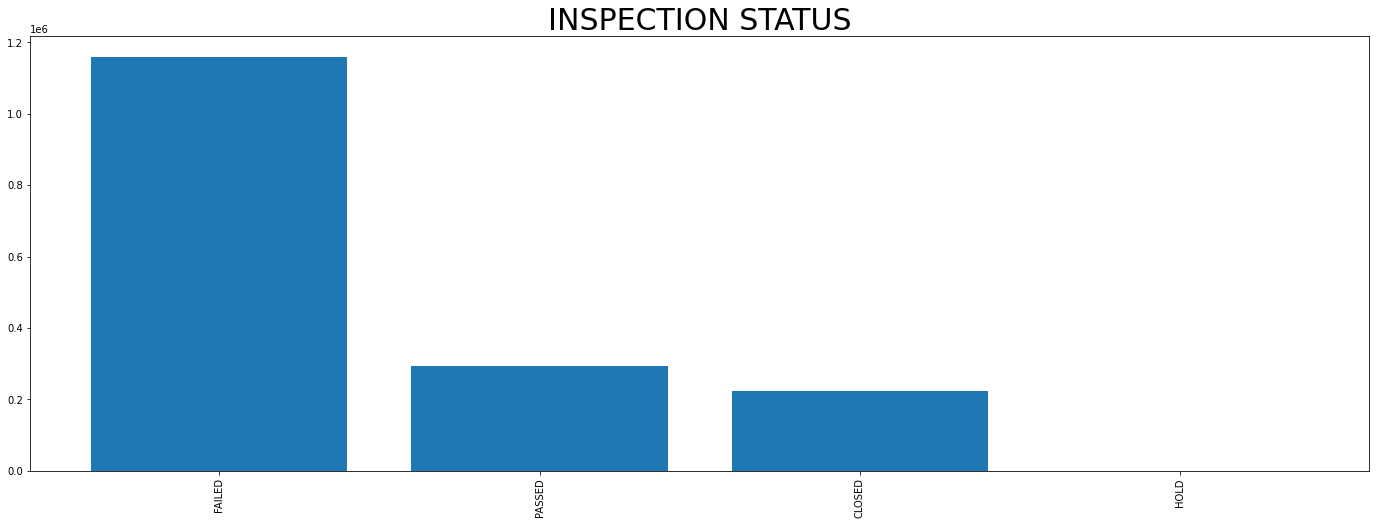

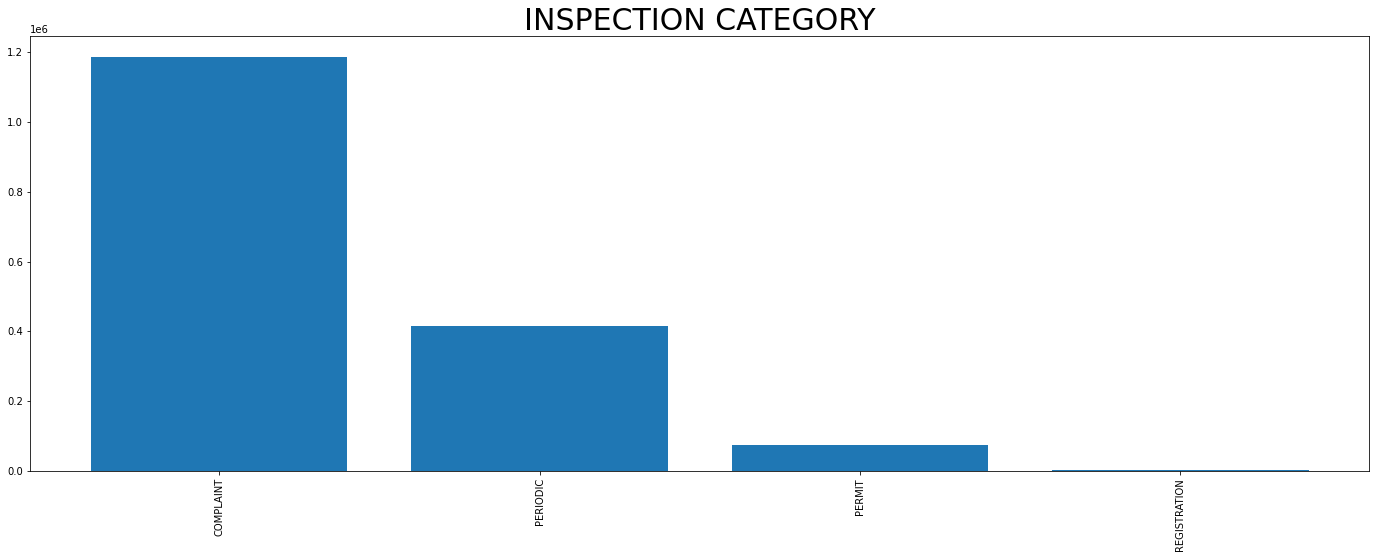

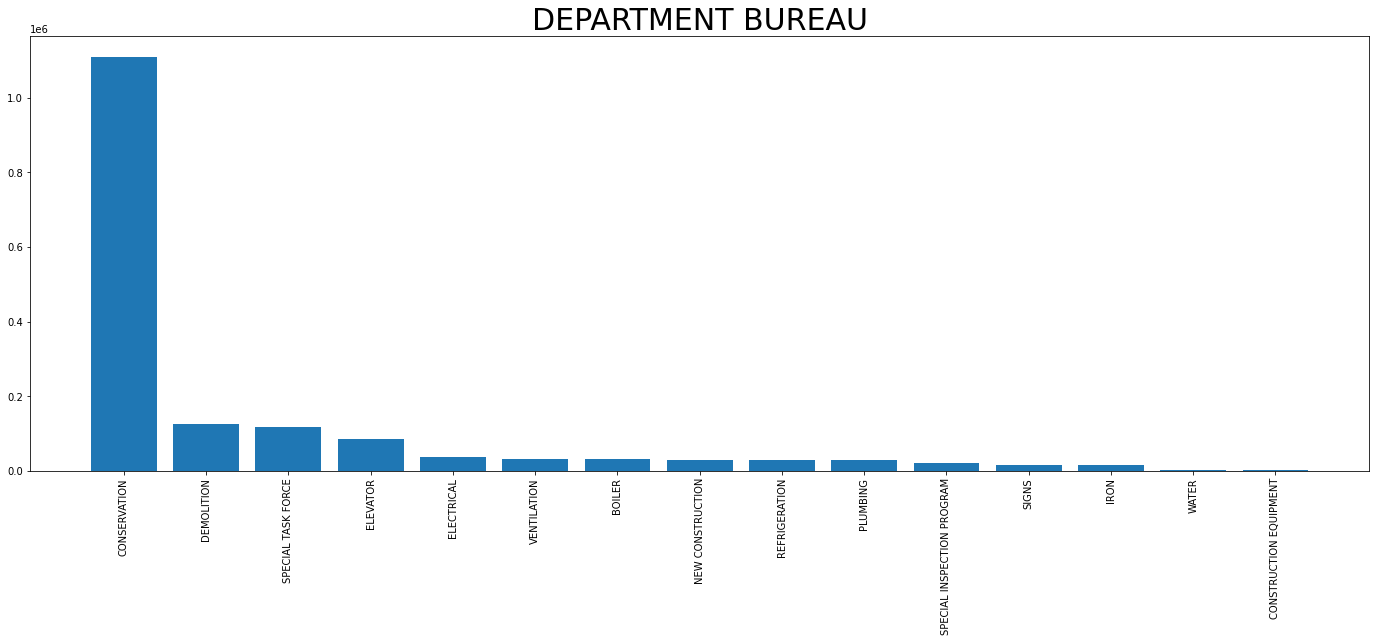

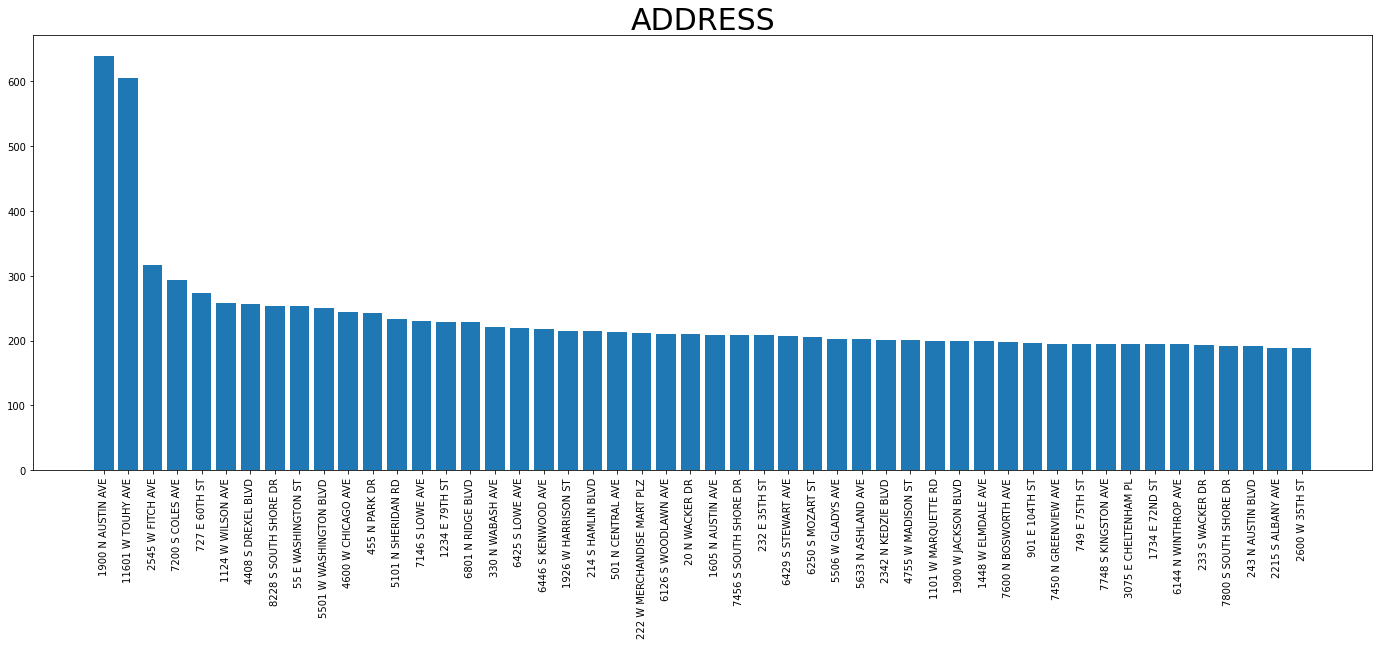

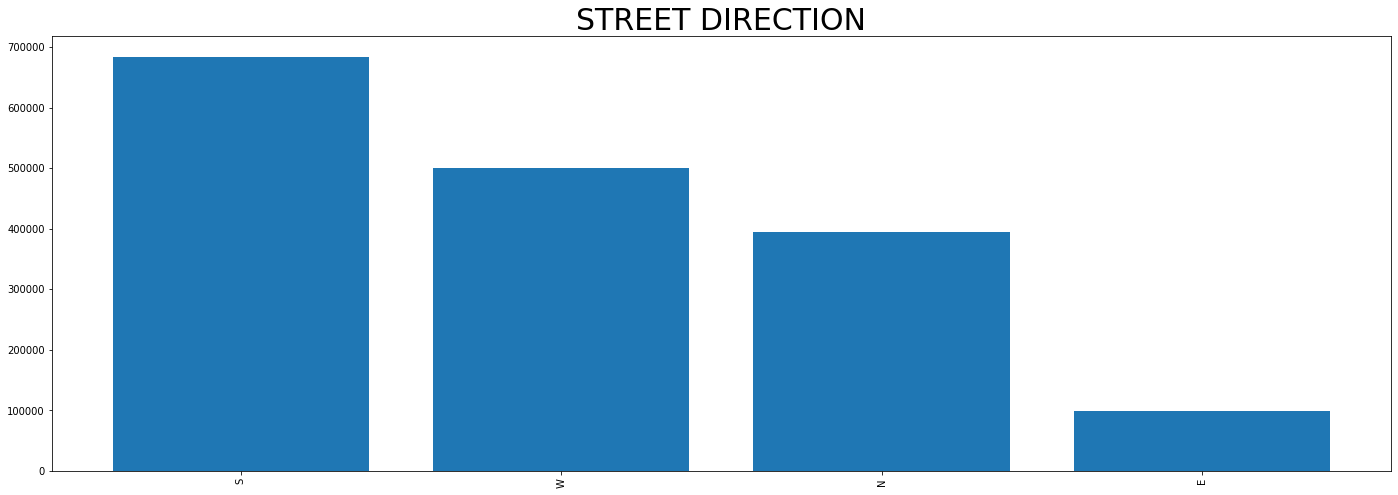

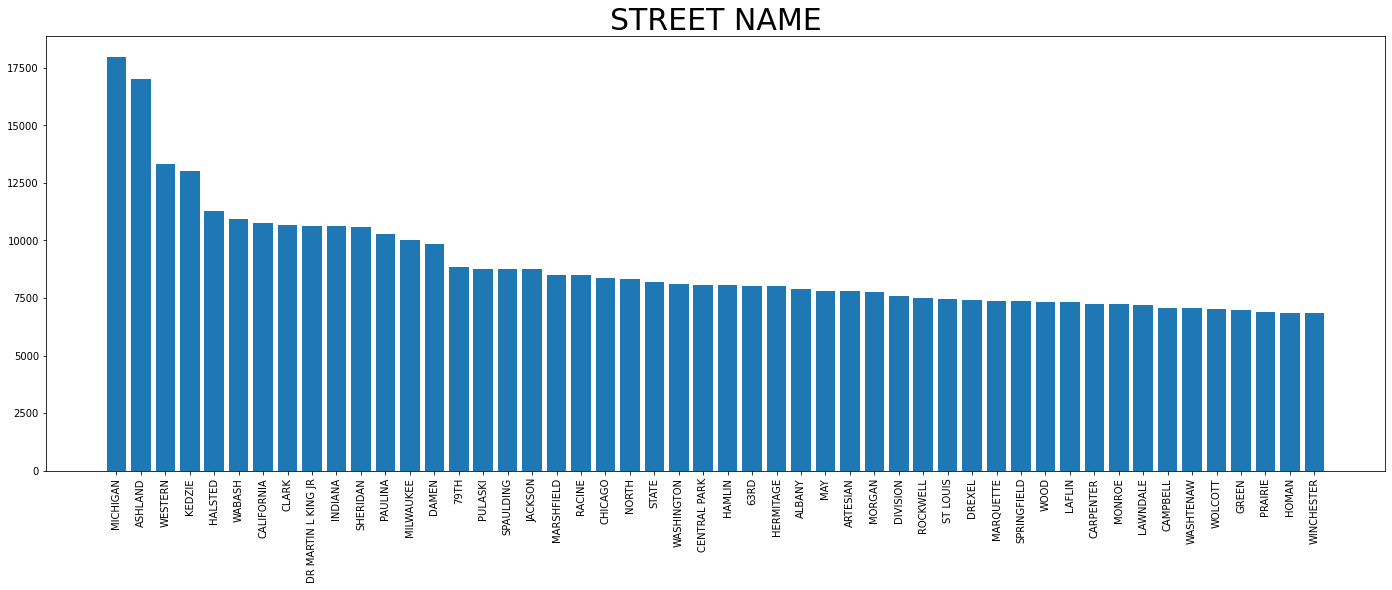

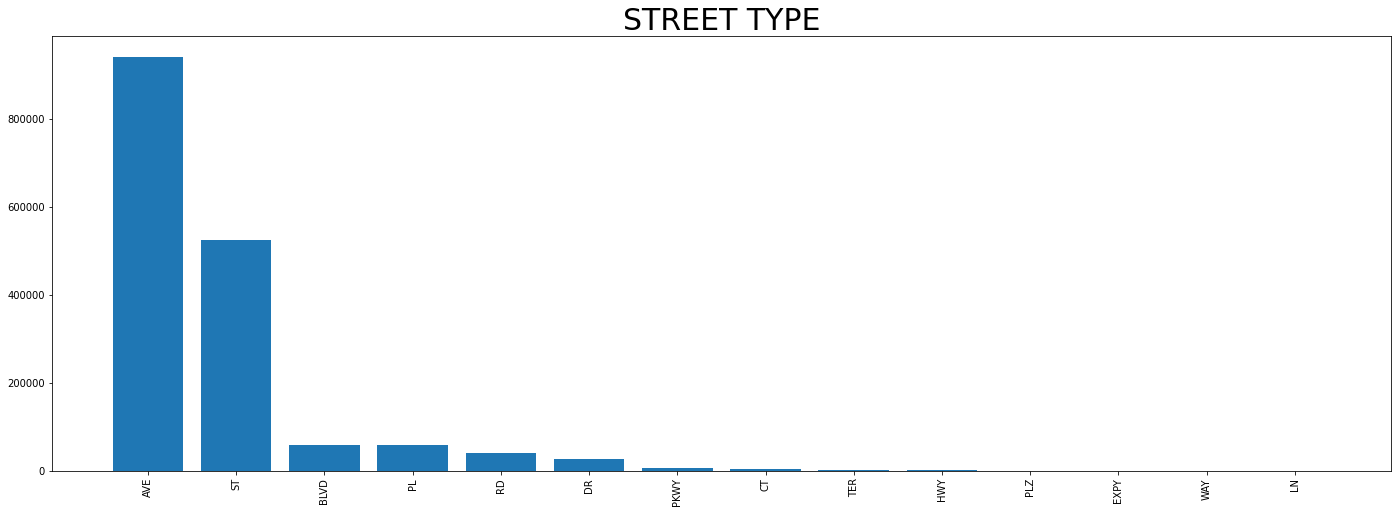

descriptive statistics (INSPECTION NUMBER):
Min: 265575.0000	Q1(25%): 2304416.0000 	Q2(50%): 10418746.0000 	Q3(75%): 11687280.0000 	Max: 13050915.0000
Missing: 0

descriptive statistics (STREET NUMBER):
Min: 1.0000	Q1(25%): 1648.0000 	Q2(50%): 3747.0000 	Q3(75%): 6228.0000 	Max: 13770.0000
Missing: 0

descriptive statistics (PROPERTY GROUP):
Min: 1000.0000	Q1(25%): 20560.0000 	Q2(50%): 154323.0000 	Q3(75%): 366984.0000 	Max: 677975.0000
Missing: 0

descriptive statistics (SSA):
Min: 1.0000	Q1(25%): 22.0000 	Q2(50%): 34.0000 	Q3(75%): 49.0000 	Max: 69.0000
Missing: 1356267

descriptive statistics (LATITUDE):
Min: 41.6447	Q1(25%): 41.7709 	Q2(50%): 41.8540 	Q3(75%): 41.9135 	Max: 42.0227
Missing: 1510

descriptive statistics (LONGITUDE):
Min: -87.9144	Q1(25%): -87.7139 	Q2(50%): -87.6699 	Q3(75%): -87.6329 	Max: -87.5247
Missing: 1510

descriptive statistics (Community Areas):
Min: 1.0000	Q1(25%): 24.0000 	Q2(50%): 36.0000 	Q3(75%): 58.0000 	Max: 77.0000
Missing: 2279

descriptive statis

In [73]:
# 标称属性
nominal_index = ['VIOLATION CODE', 'VIOLATION STATUS',
                 'VIOLATION LOCATION', 'INSPECTOR ID','INSPECTION STATUS','INSPECTION CATEGORY',
                 'DEPARTMENT BUREAU','ADDRESS','STREET DIRECTION','STREET NAME', 'STREET TYPE']
# 数值属性
numerical_index = ['INSPECTION NUMBER','STREET NUMBER','PROPERTY GROUP','SSA','LATITUDE','LONGITUDE',
                   'Community Areas','Zip Codes','Boundaries - ZIP Codes','Census Tracts','Wards',
                   'Historical Wards 2003-2015']
nominal_summary(building,nominal_index,head_n=50)
numerical_summary(building,numerical_index)

### 缺失值处理与对比

#### 1 将缺失部分剔除

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677788 entries, 0 to 1677787
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   ID                            1677788 non-null  int64  
 1   VIOLATION LAST MODIFIED DATE  1677788 non-null  object 
 2   VIOLATION DATE                1677788 non-null  object 
 3   VIOLATION CODE                1677788 non-null  object 
 4   VIOLATION STATUS              1677788 non-null  object 
 5   VIOLATION STATUS DATE         641589 non-null   object 
 6   VIOLATION DESCRIPTION         1667020 non-null  object 
 7   VIOLATION LOCATION            780506 non-null   object 
 8   VIOLATION INSPECTOR COMMENTS  1502325 non-null  object 
 9   VIOLATION ORDINANCE           1630207 non-null  object 
 10  INSPECTOR ID                  1677788 non-null  object 
 11  INSPECTION NUMBER             1677788 non-null  int64  
 12  INSPECTION STATUS           

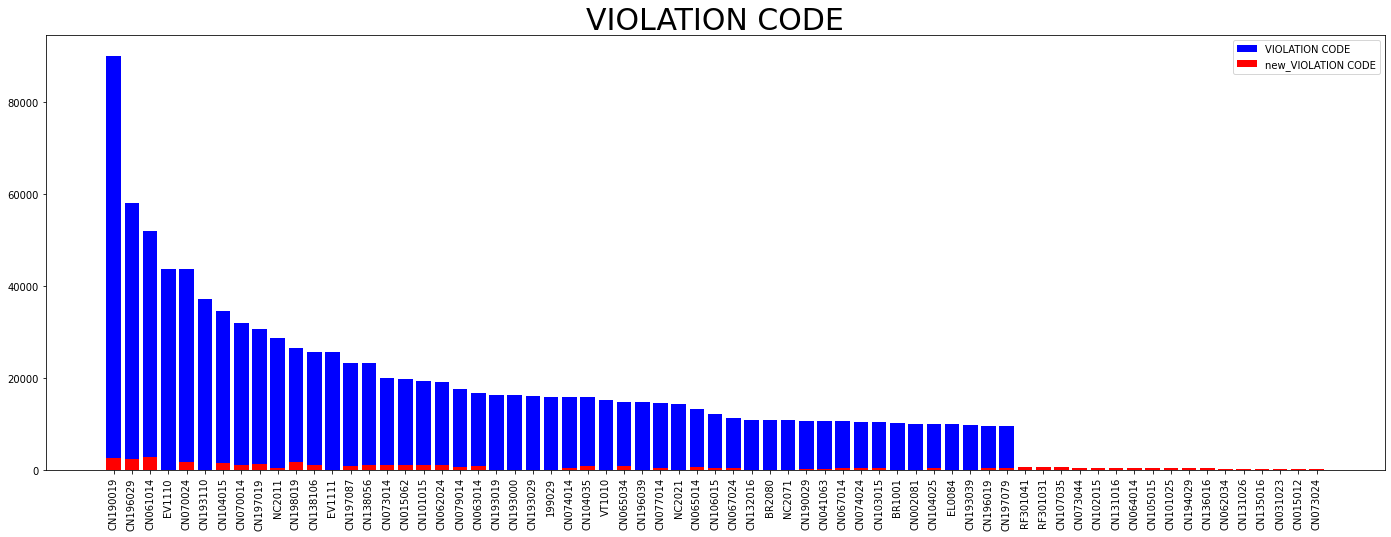

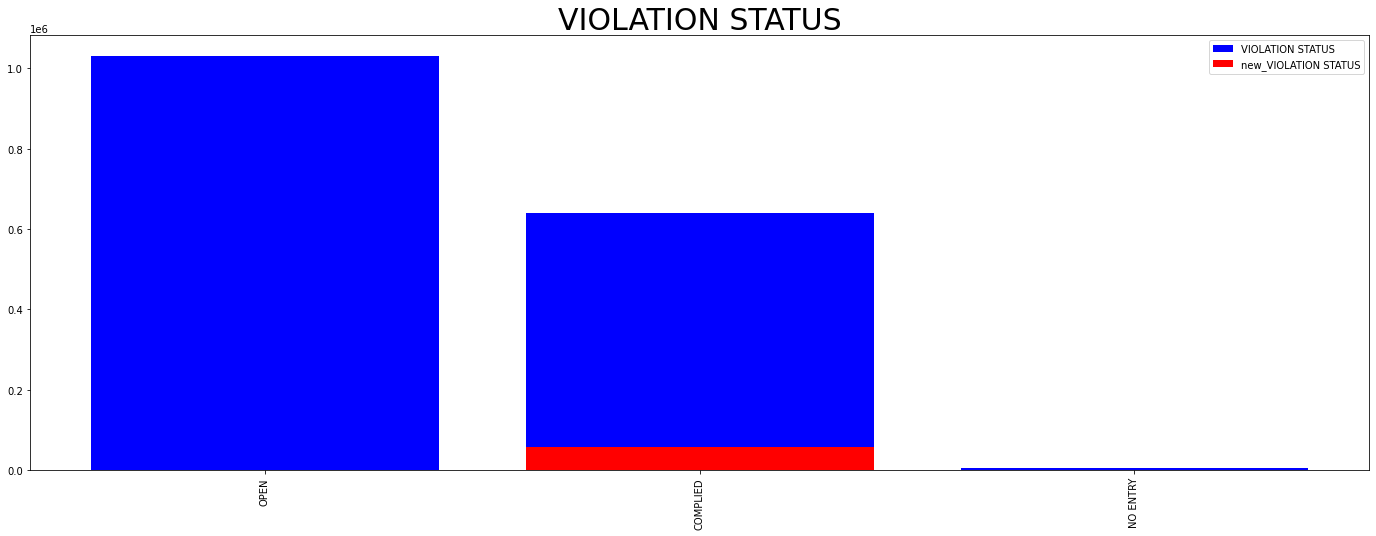

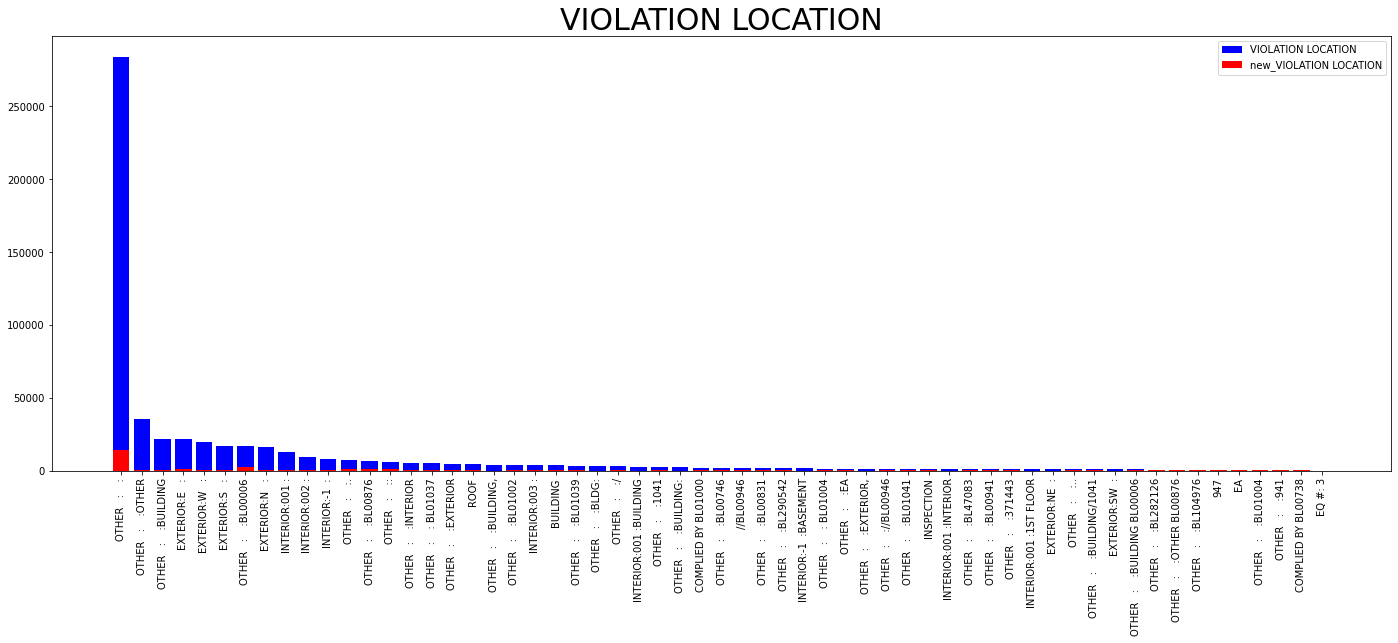

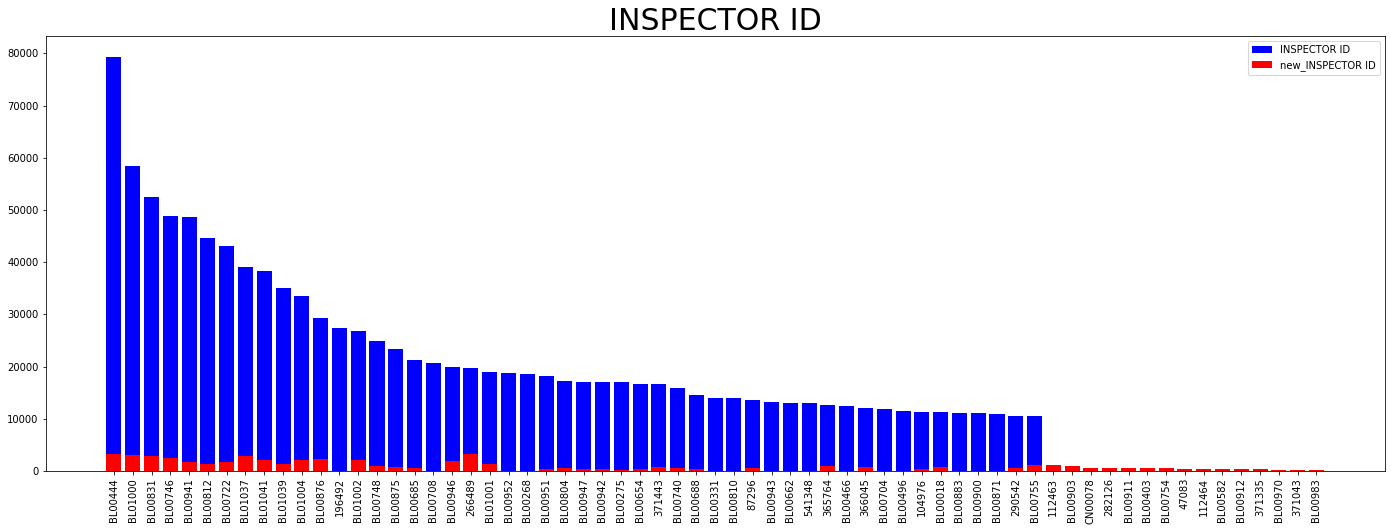

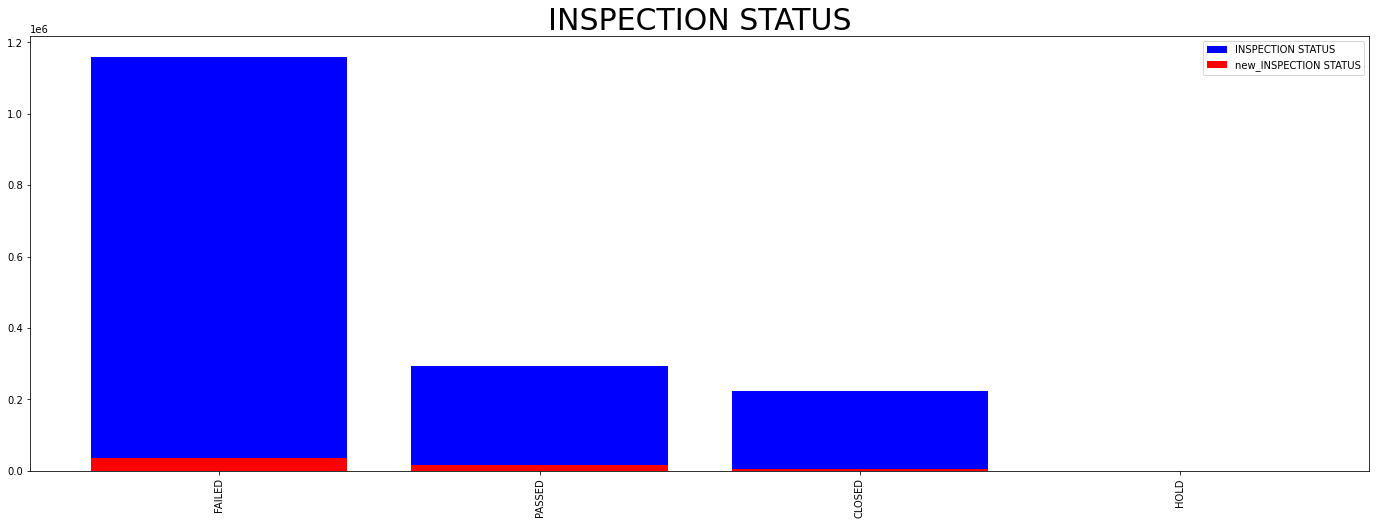

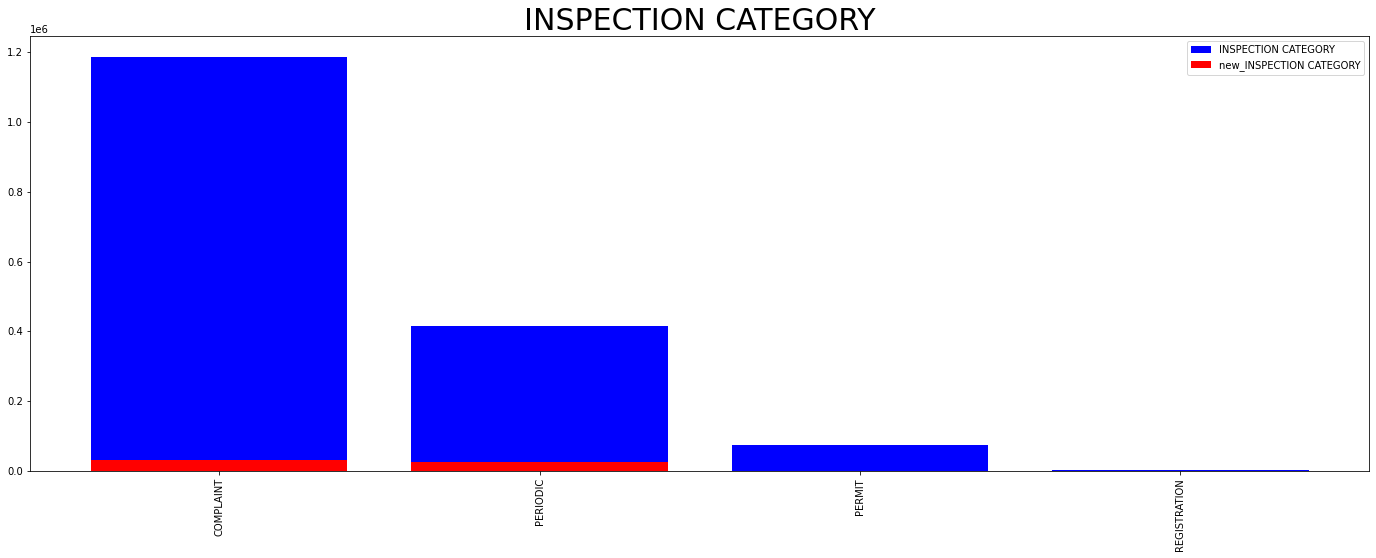

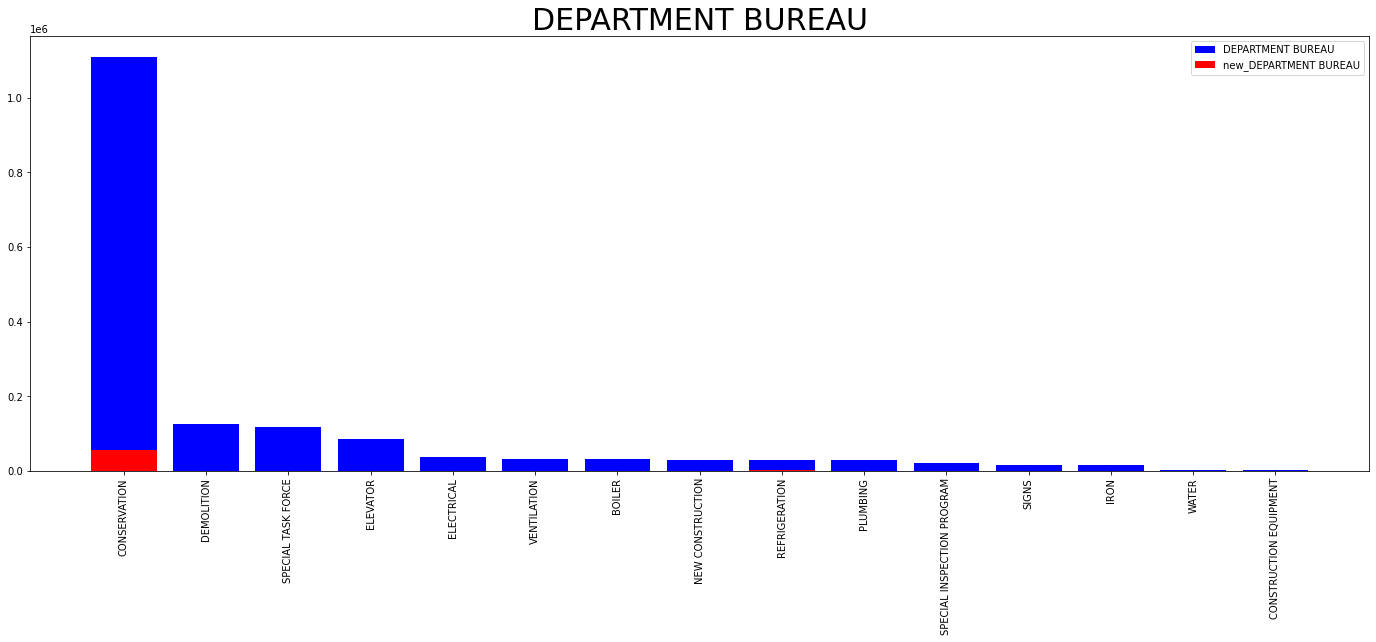

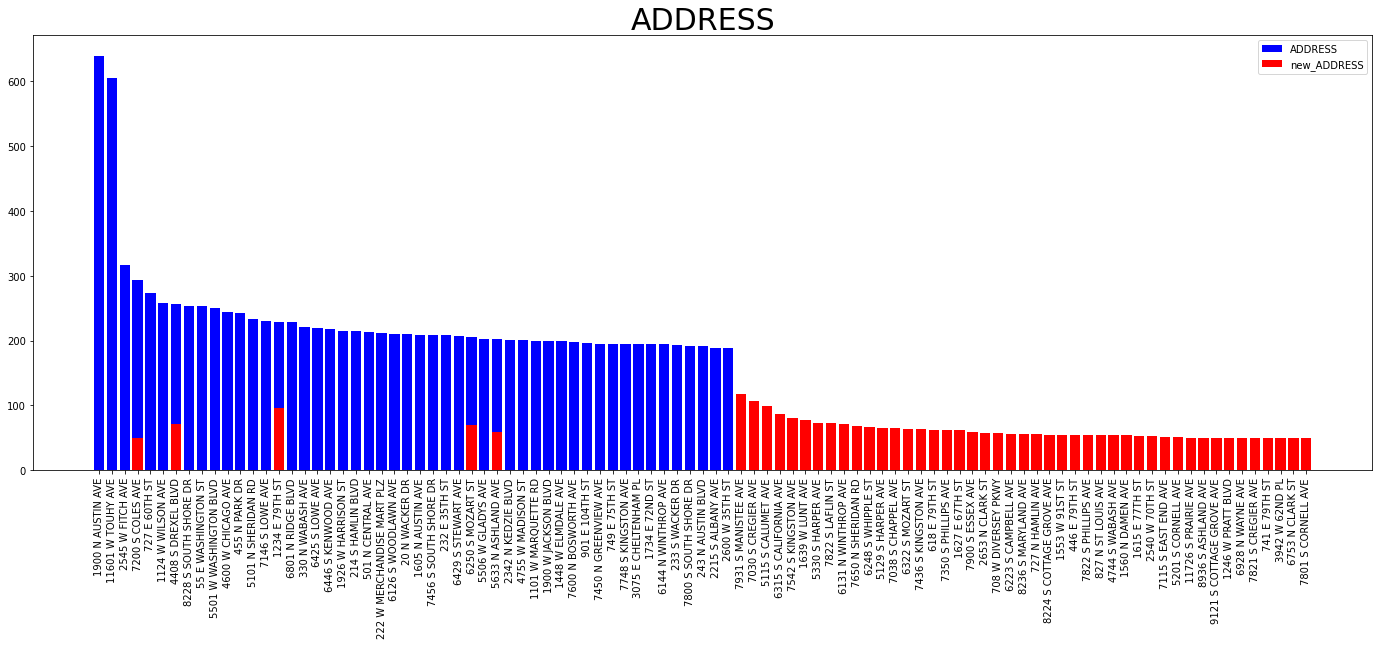

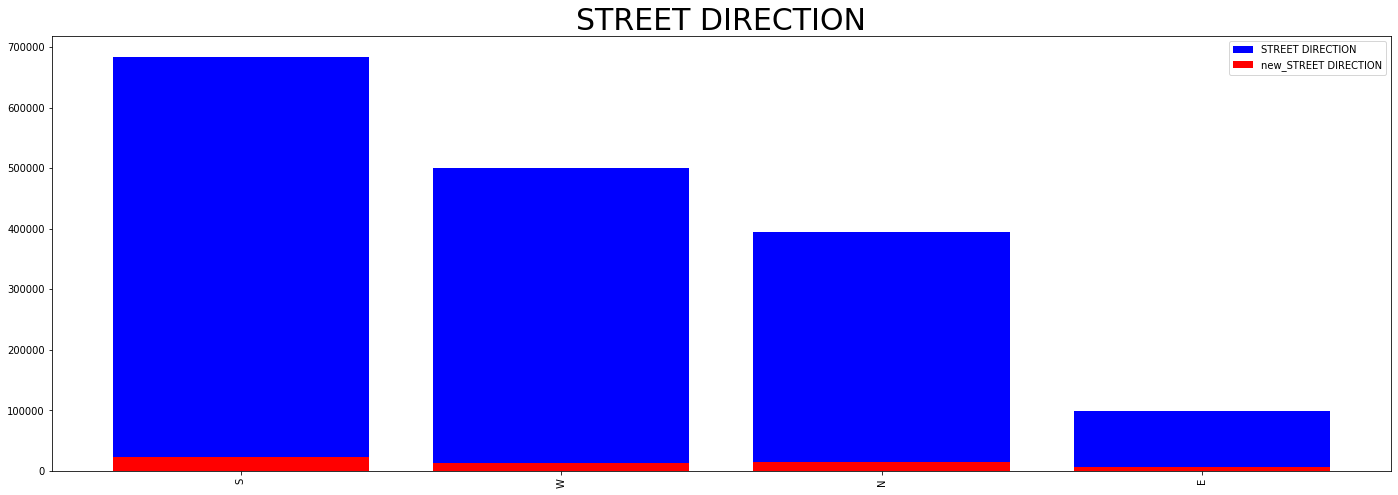

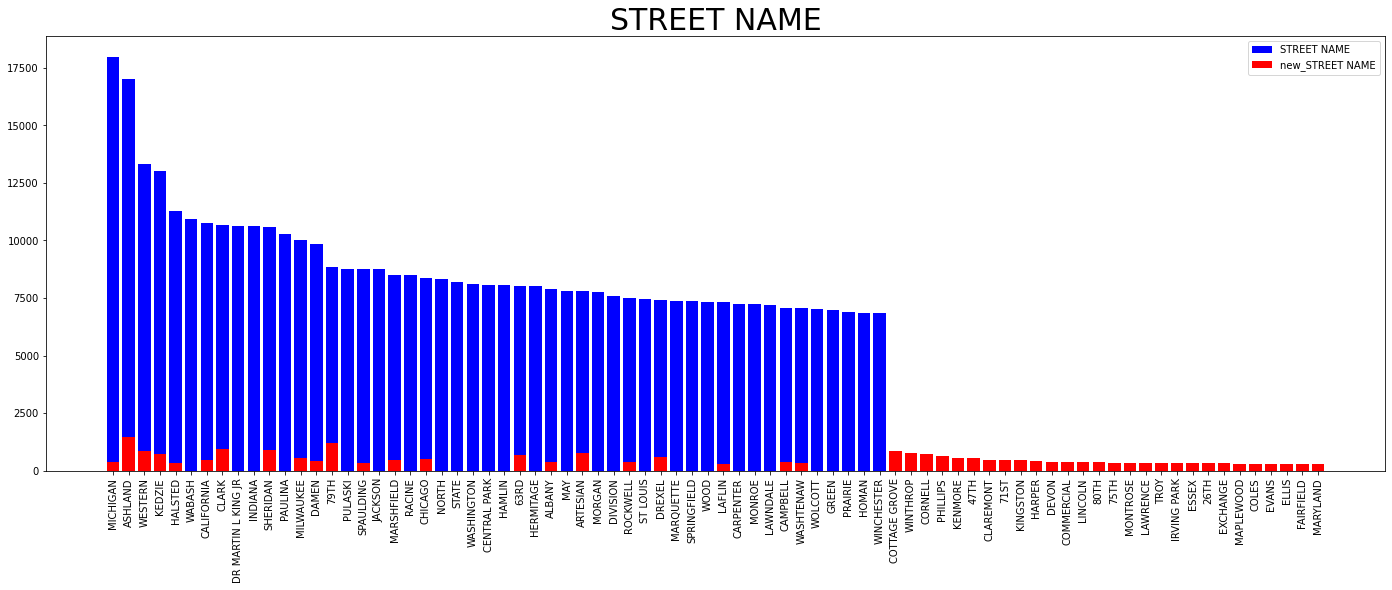

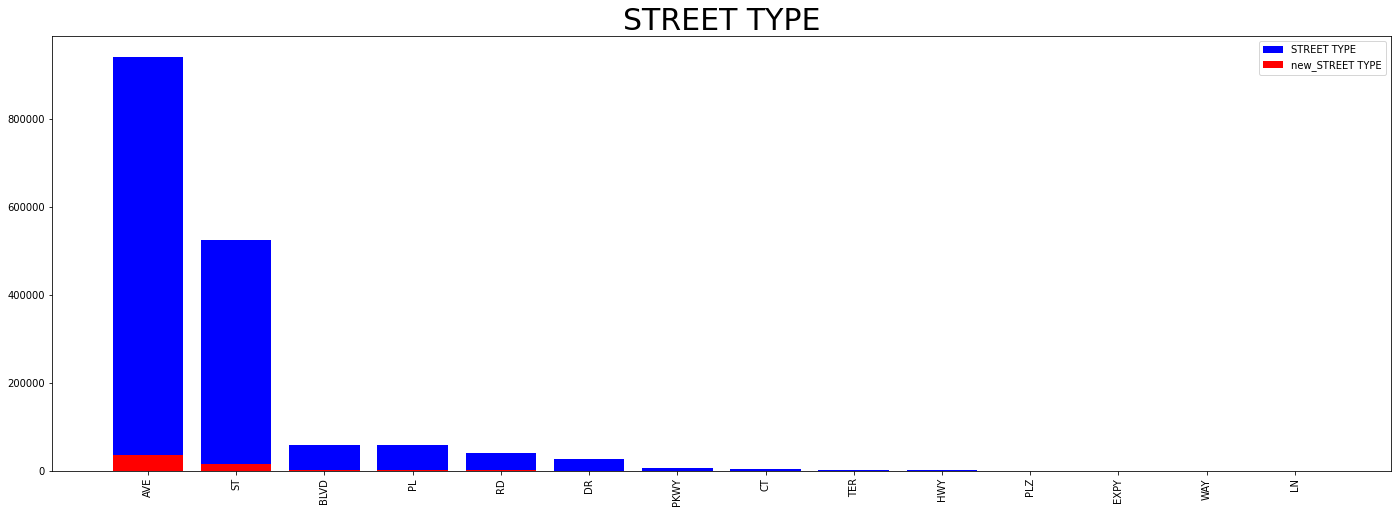

descriptive statistics (INSPECTION NUMBER):
Min: 265575.0000	Q1(25%): 2304416.0000 	Q2(50%): 10418746.0000 	Q3(75%): 11687280.0000 	Max: 13050915.0000
Missing: 0

 new Min: 1061448.0000	Q1(25%): 9929462.0000 	Q2(50%): 10707030.0000 	Q3(75%): 11716234.0000 	Max: 13035353.0000 
 new Missing: 1620185 

descriptive statistics (STREET NUMBER):
Min: 1.0000	Q1(25%): 1648.0000 	Q2(50%): 3747.0000 	Q3(75%): 6228.0000 	Max: 13770.0000
Missing: 0

 new Min: 1.0000	Q1(25%): 1758.0000 	Q2(50%): 4431.0000 	Q3(75%): 7025.0000 	Max: 11750.0000 
 new Missing: 1620185 

descriptive statistics (PROPERTY GROUP):
Min: 1000.0000	Q1(25%): 20560.0000 	Q2(50%): 154323.0000 	Q3(75%): 366984.0000 	Max: 677975.0000
Missing: 0

 new Min: 1000.0000	Q1(25%): 18144.0000 	Q2(50%): 26200.0000 	Q3(75%): 350611.0000 	Max: 674421.0000 
 new Missing: 1620185 

descriptive statistics (SSA):
Min: 1.0000	Q1(25%): 22.0000 	Q2(50%): 34.0000 	Q3(75%): 49.0000 	Max: 69.0000
Missing: 1356267

 new Min: 1.0000	Q1(25%): 23.0000 	Q2(

In [74]:
dwbuilding=miss_drop(building)
columns_info(building,show_shape=True,new_df=dwbuilding)
nominal_summary(building,nominal_index=nominal_index,head_n=50,new_df=dwbuilding)
numerical_summary(building,numerical_index=numerical_index,new_df=dwbuilding)

#### 2 用最高频率值来填补缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677788 entries, 0 to 1677787
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   ID                            1677788 non-null  int64  
 1   VIOLATION LAST MODIFIED DATE  1677788 non-null  object 
 2   VIOLATION DATE                1677788 non-null  object 
 3   VIOLATION CODE                1677788 non-null  object 
 4   VIOLATION STATUS              1677788 non-null  object 
 5   VIOLATION STATUS DATE         641589 non-null   object 
 6   VIOLATION DESCRIPTION         1667020 non-null  object 
 7   VIOLATION LOCATION            780506 non-null   object 
 8   VIOLATION INSPECTOR COMMENTS  1502325 non-null  object 
 9   VIOLATION ORDINANCE           1630207 non-null  object 
 10  INSPECTOR ID                  1677788 non-null  object 
 11  INSPECTION NUMBER             1677788 non-null  int64  
 12  INSPECTION STATUS           

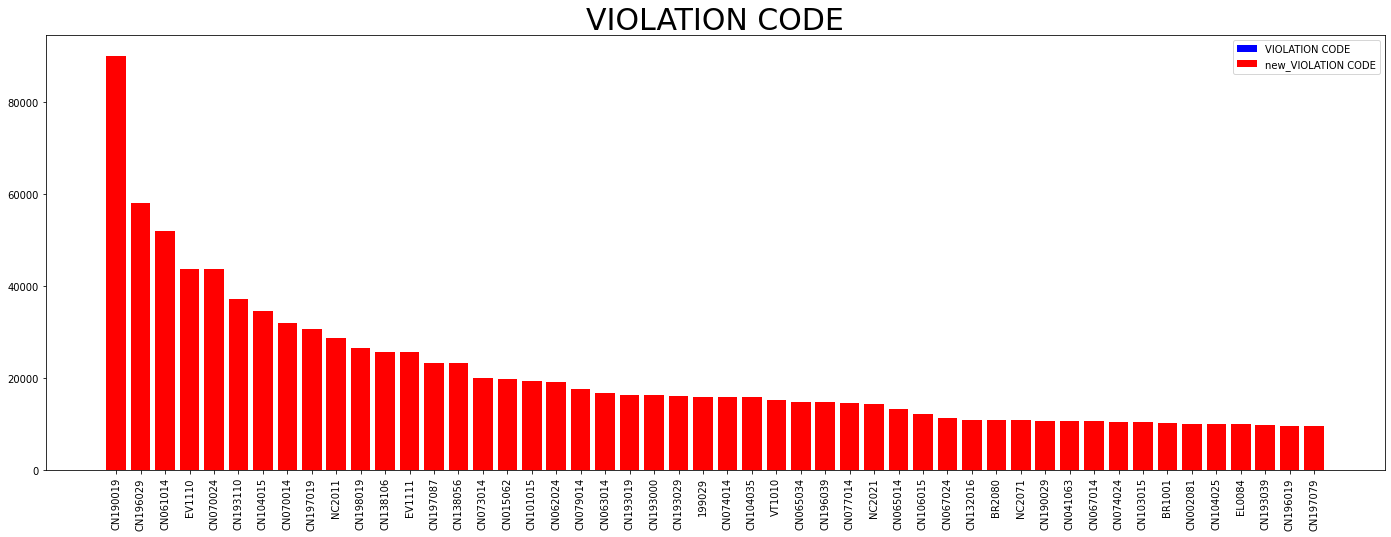

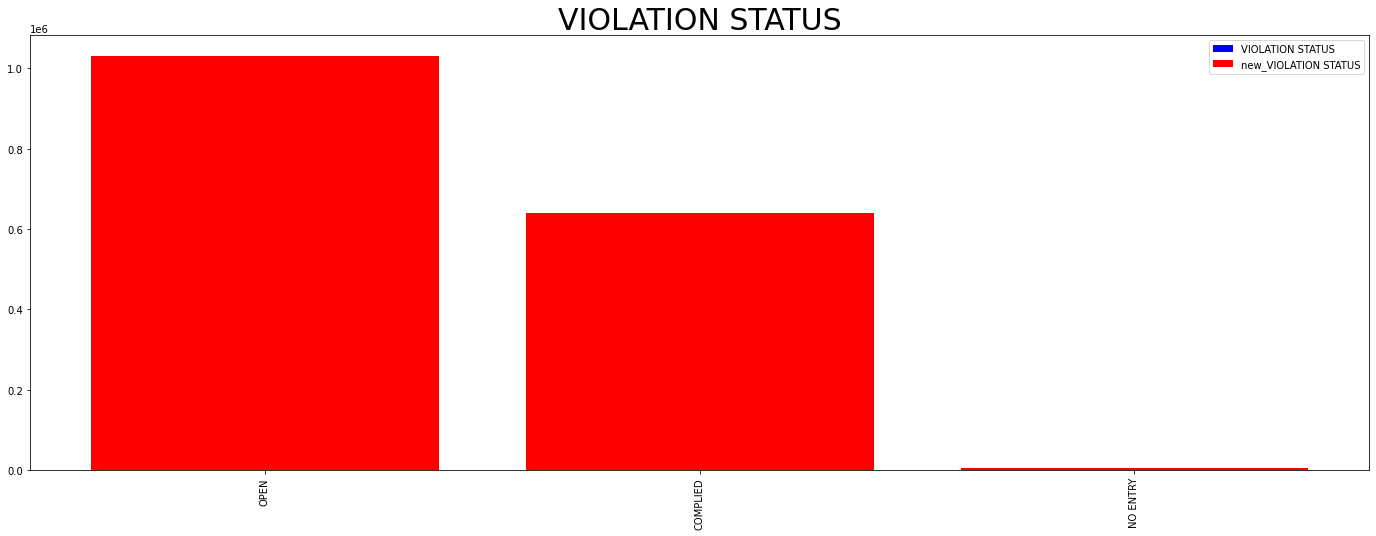

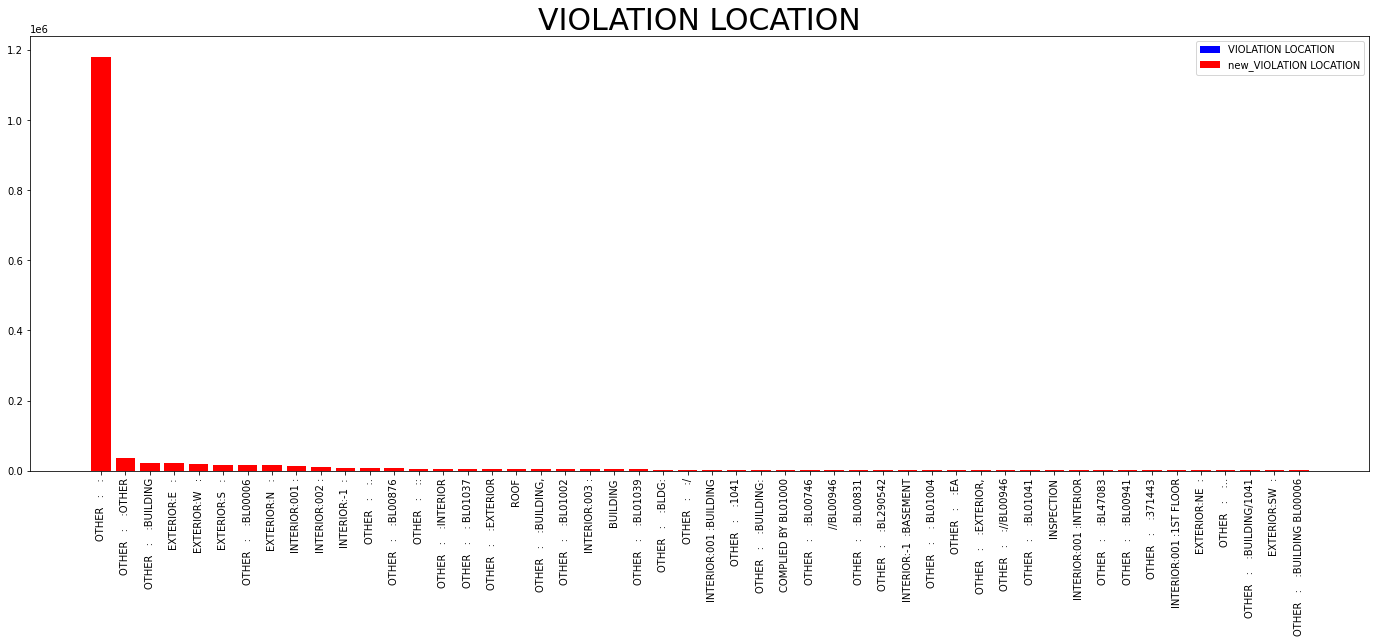

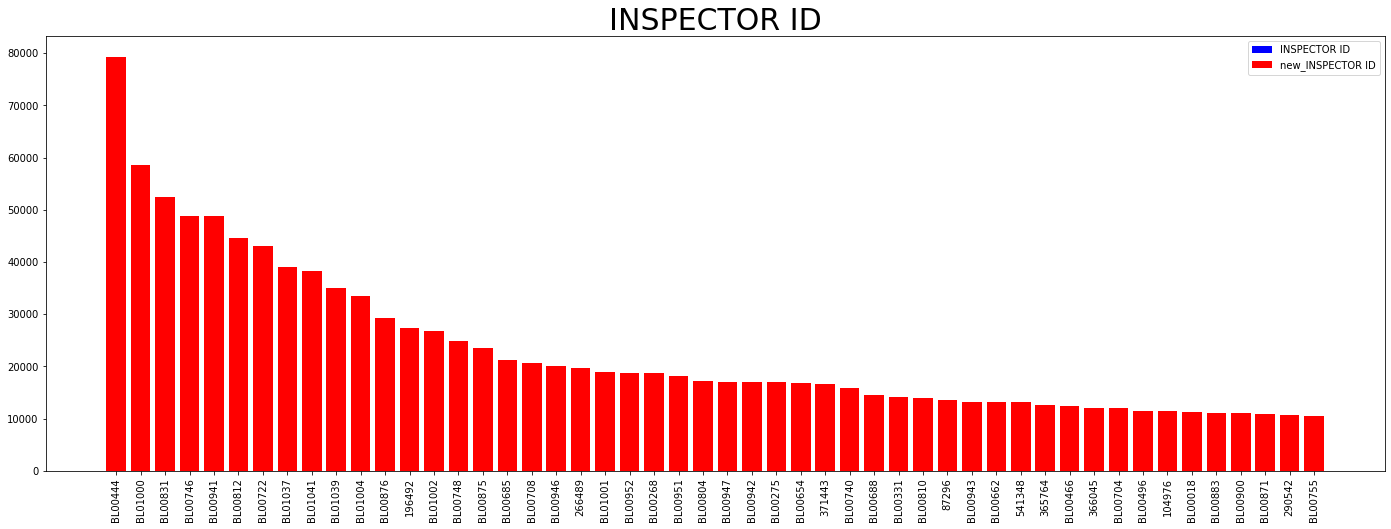

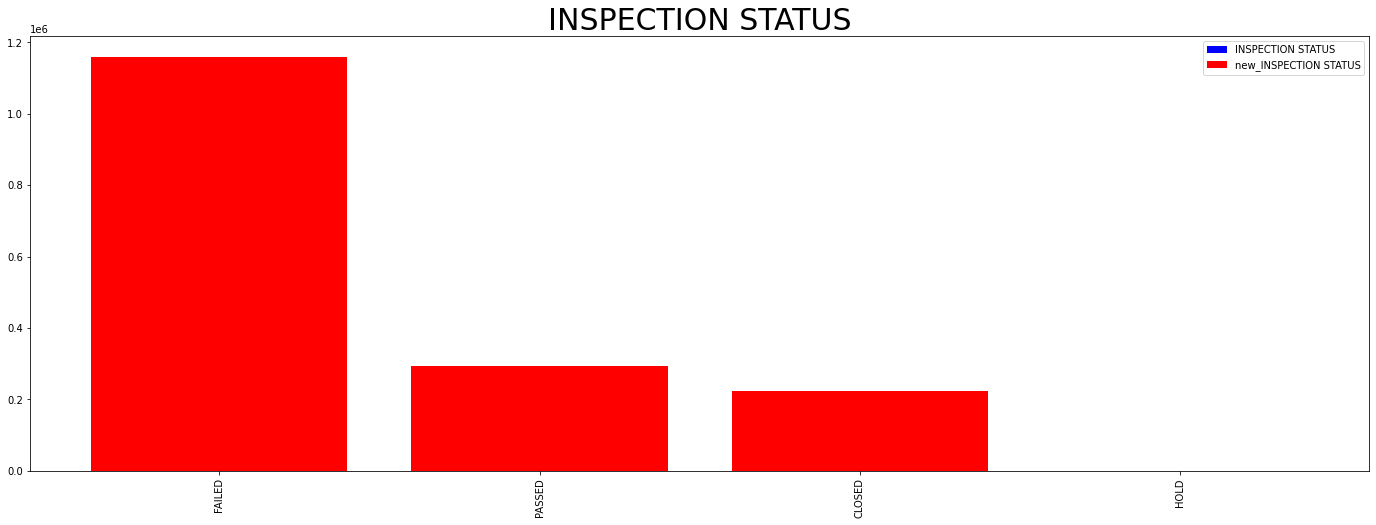

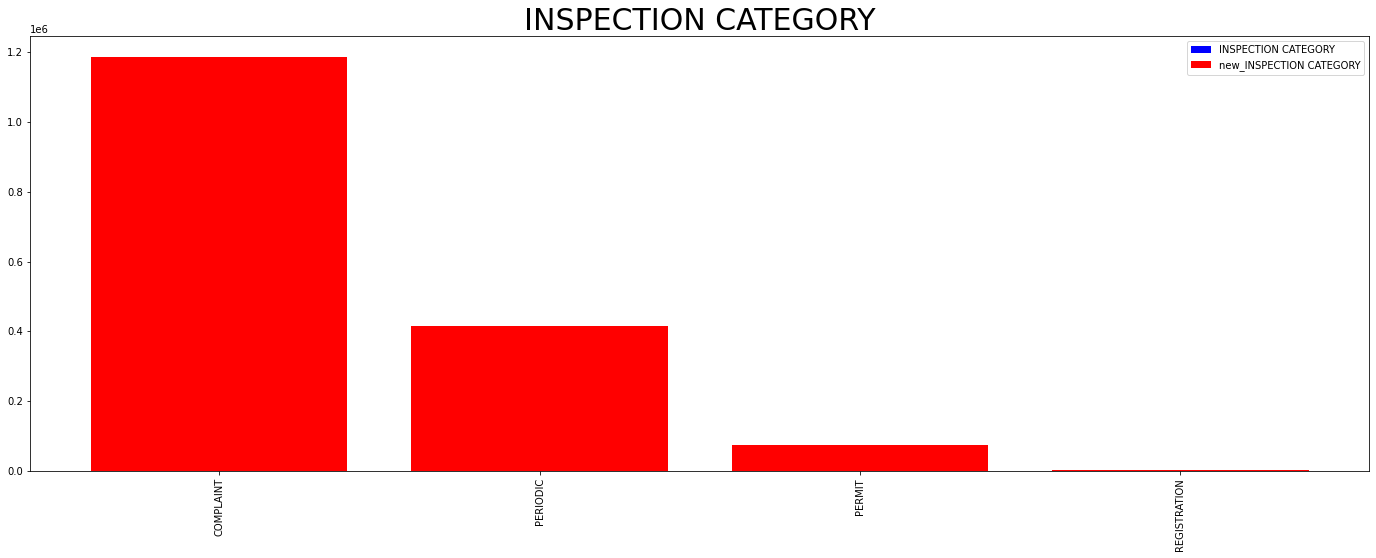

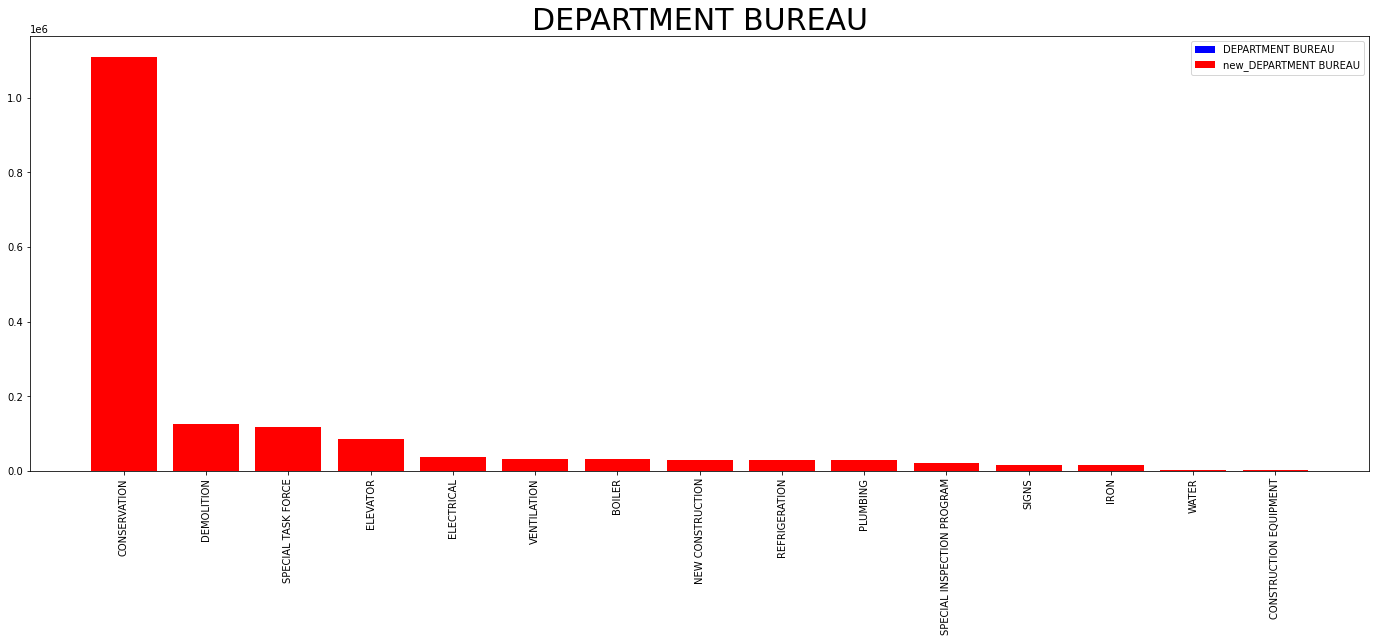

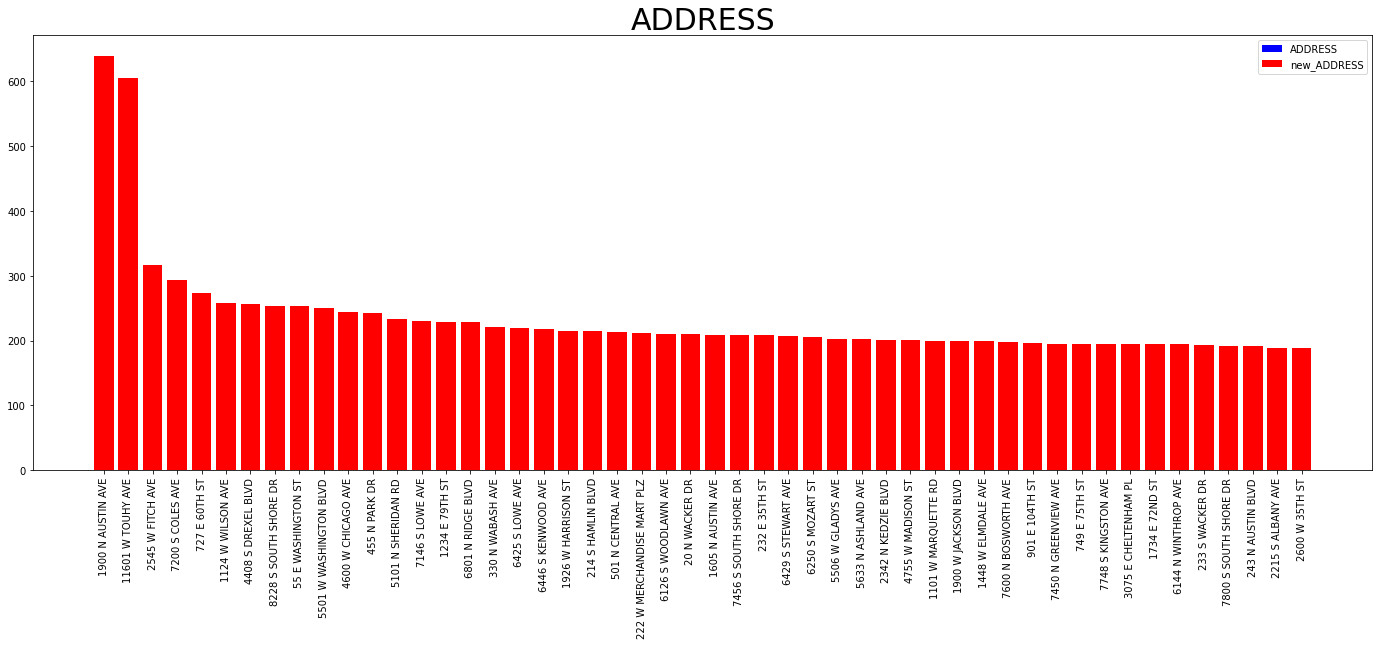

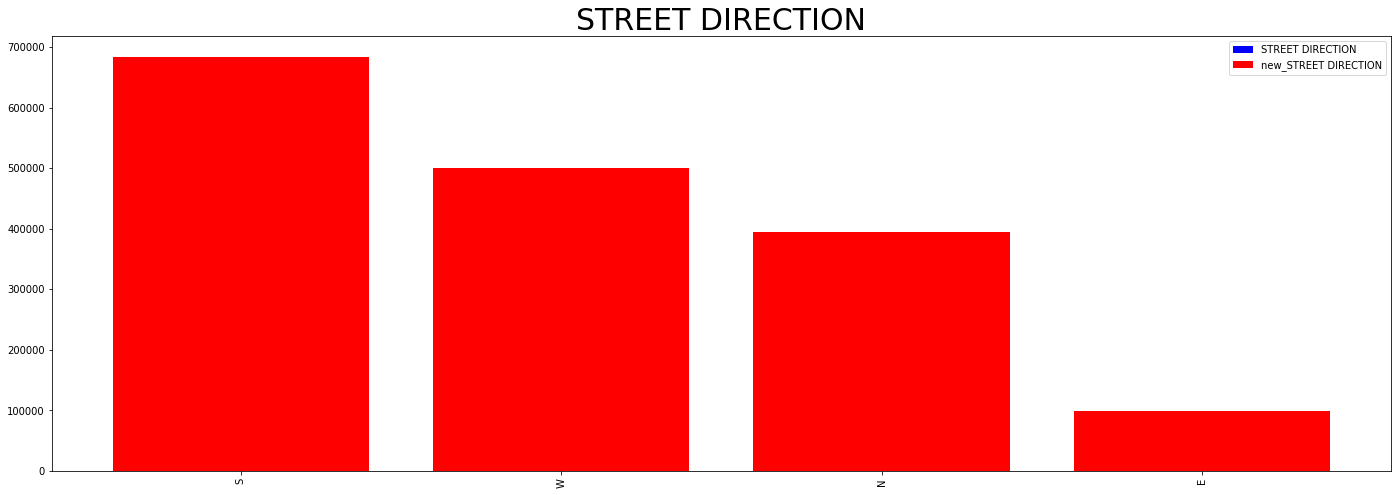

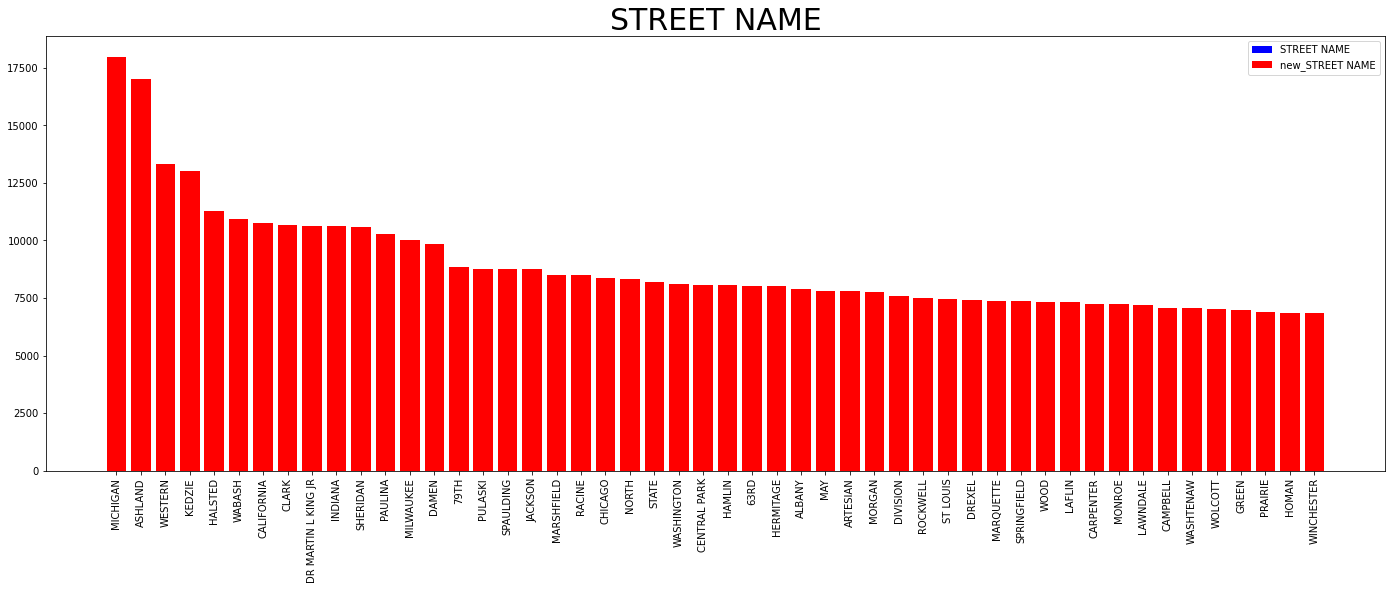

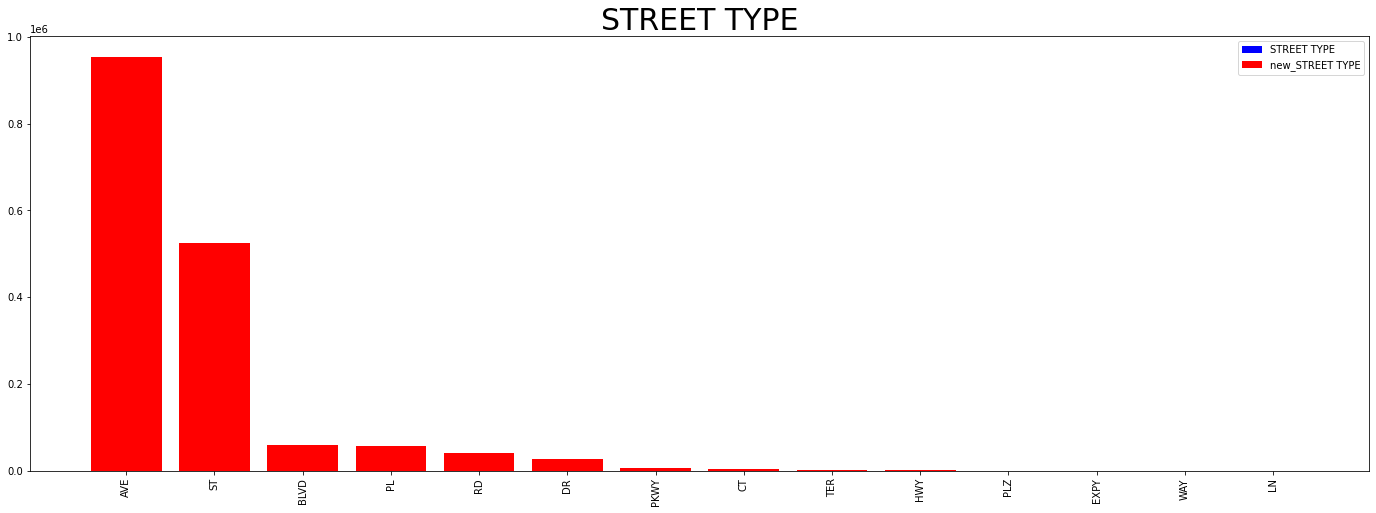

descriptive statistics (INSPECTION NUMBER):
Min: 265575.0000	Q1(25%): 2304416.0000 	Q2(50%): 10418746.0000 	Q3(75%): 11687280.0000 	Max: 13050915.0000
Missing: 0

 new Min: 265575.0000	Q1(25%): 2304416.0000 	Q2(50%): 10418746.0000 	Q3(75%): 11687280.0000 	Max: 13050915.0000 
 new Missing: 0 

descriptive statistics (STREET NUMBER):
Min: 1.0000	Q1(25%): 1648.0000 	Q2(50%): 3747.0000 	Q3(75%): 6228.0000 	Max: 13770.0000
Missing: 0

 new Min: 1.0000	Q1(25%): 1648.0000 	Q2(50%): 3747.0000 	Q3(75%): 6228.0000 	Max: 13770.0000 
 new Missing: 0 

descriptive statistics (PROPERTY GROUP):
Min: 1000.0000	Q1(25%): 20560.0000 	Q2(50%): 154323.0000 	Q3(75%): 366984.0000 	Max: 677975.0000
Missing: 0

 new Min: 1000.0000	Q1(25%): 20560.0000 	Q2(50%): 154323.0000 	Q3(75%): 366984.0000 	Max: 677975.0000 
 new Missing: 0 

descriptive statistics (SSA):
Min: 1.0000	Q1(25%): 22.0000 	Q2(50%): 34.0000 	Q3(75%): 49.0000 	Max: 69.0000
Missing: 1356267

 new Min: 1.0000	Q1(25%): 51.0000 	Q2(50%): 51.0000 	Q3(

In [75]:
mdbuilding=miss_mode_fill(building)
columns_info(building,show_shape=True,new_df=mdbuilding)
nominal_summary(building,nominal_index=nominal_index,head_n=50,new_df=mdbuilding)
numerical_summary(building,numerical_index=numerical_index,new_df=mdbuilding)

#### 3 通过属性的相关关系来填补缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677788 entries, 0 to 1677787
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   ID                            1677788 non-null  int64  
 1   VIOLATION LAST MODIFIED DATE  1677788 non-null  object 
 2   VIOLATION DATE                1677788 non-null  object 
 3   VIOLATION CODE                1677788 non-null  object 
 4   VIOLATION STATUS              1677788 non-null  object 
 5   VIOLATION STATUS DATE         641589 non-null   object 
 6   VIOLATION DESCRIPTION         1667020 non-null  object 
 7   VIOLATION LOCATION            780506 non-null   object 
 8   VIOLATION INSPECTOR COMMENTS  1502325 non-null  object 
 9   VIOLATION ORDINANCE           1630207 non-null  object 
 10  INSPECTOR ID                  1677788 non-null  object 
 11  INSPECTION NUMBER             1677788 non-null  int64  
 12  INSPECTION STATUS           

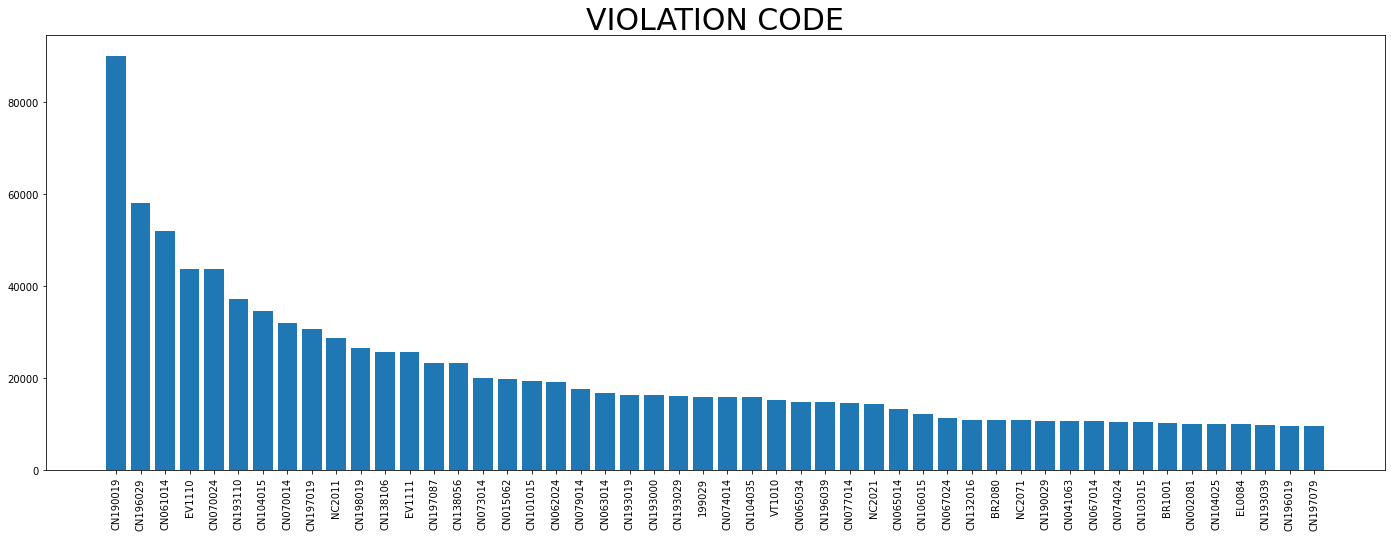

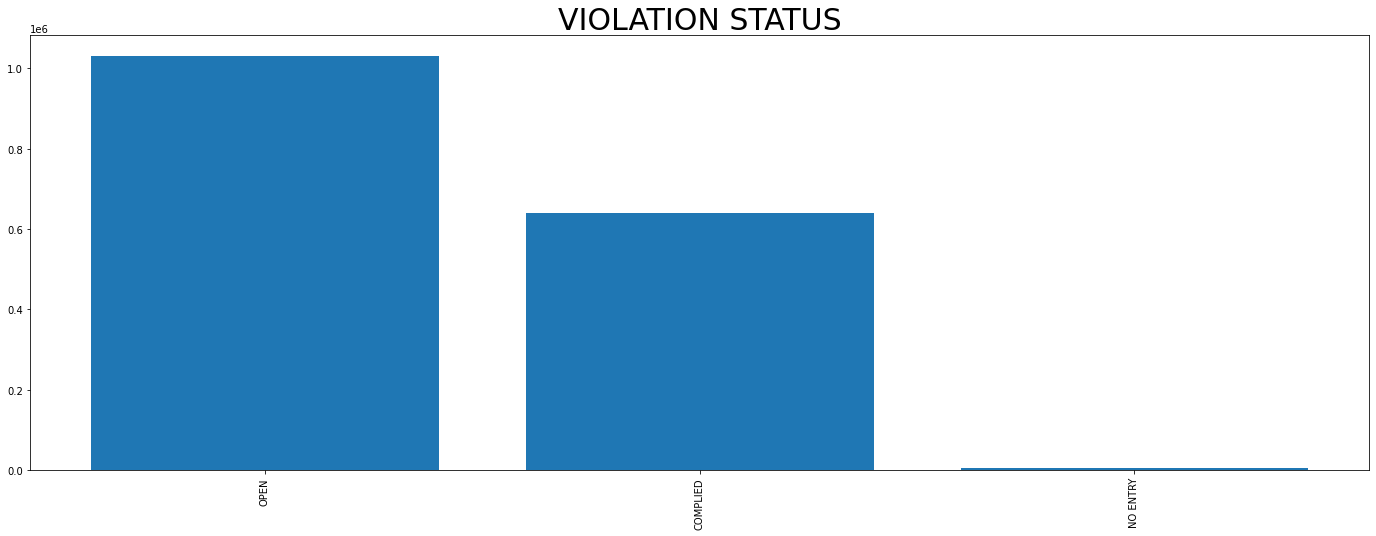

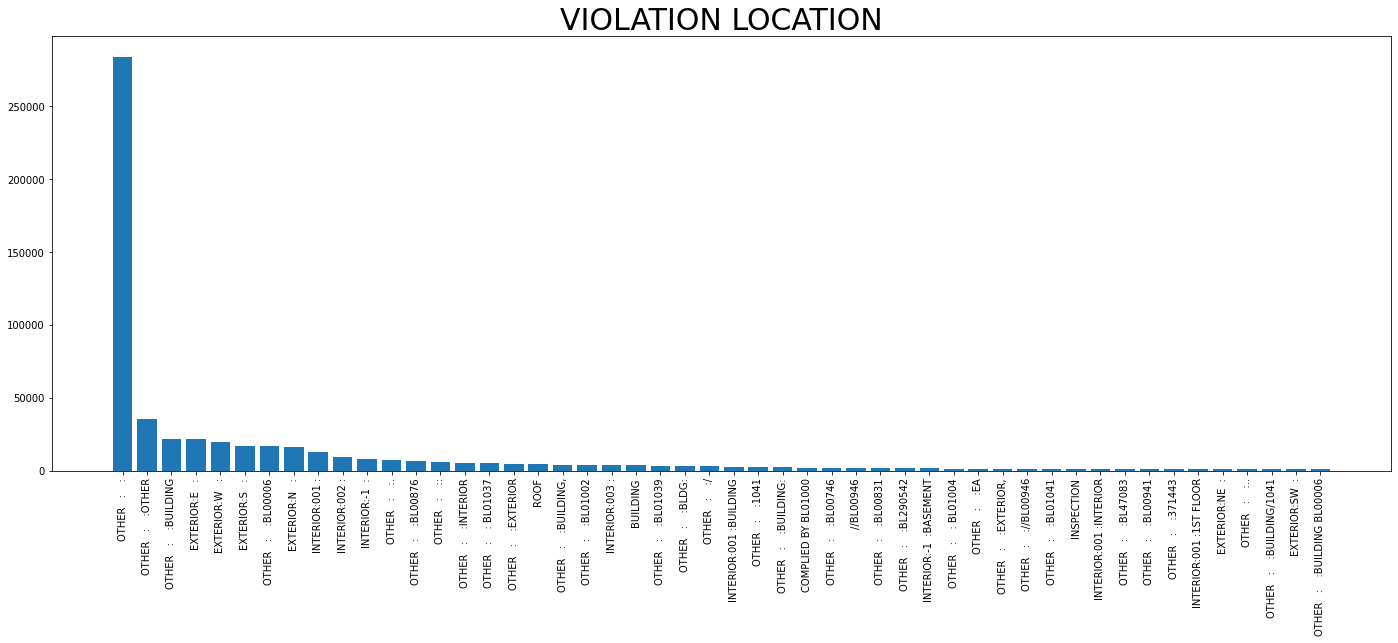

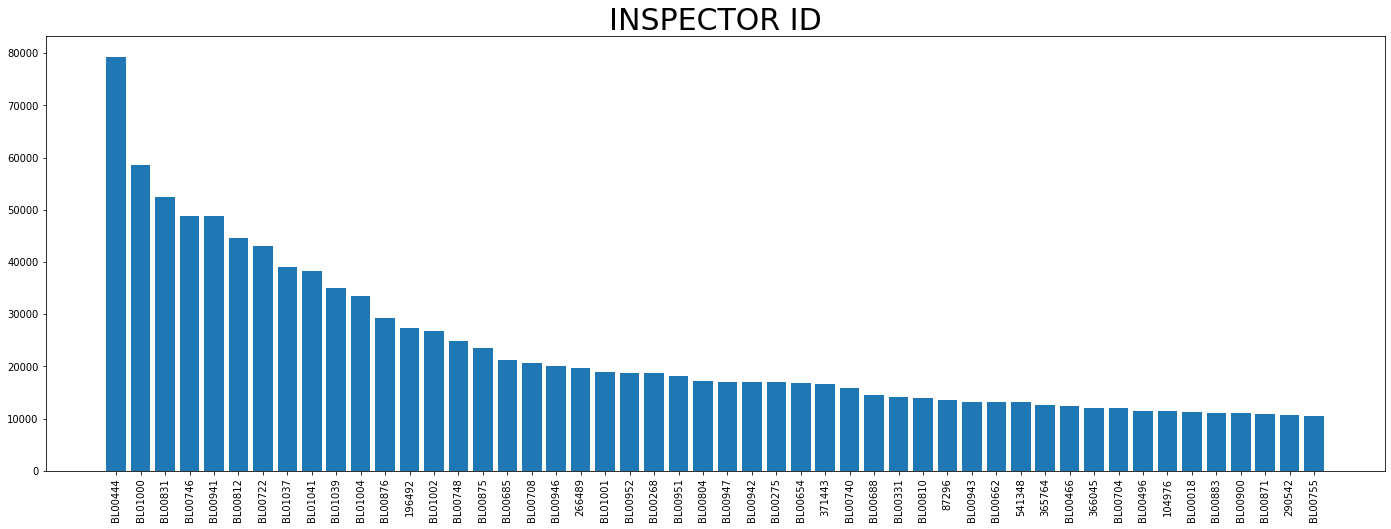

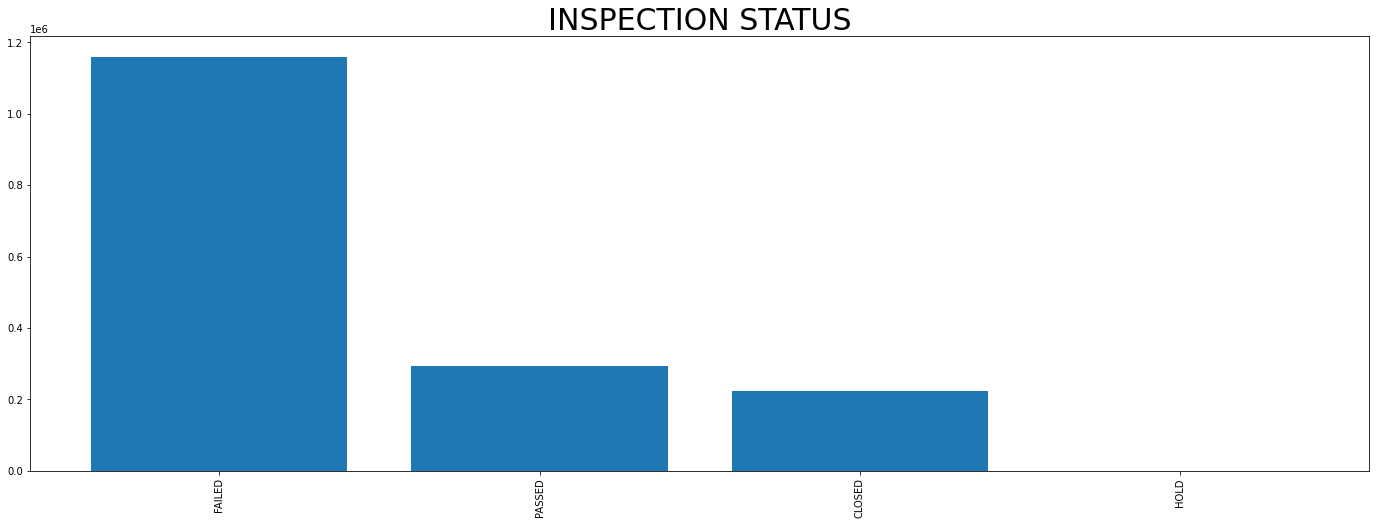

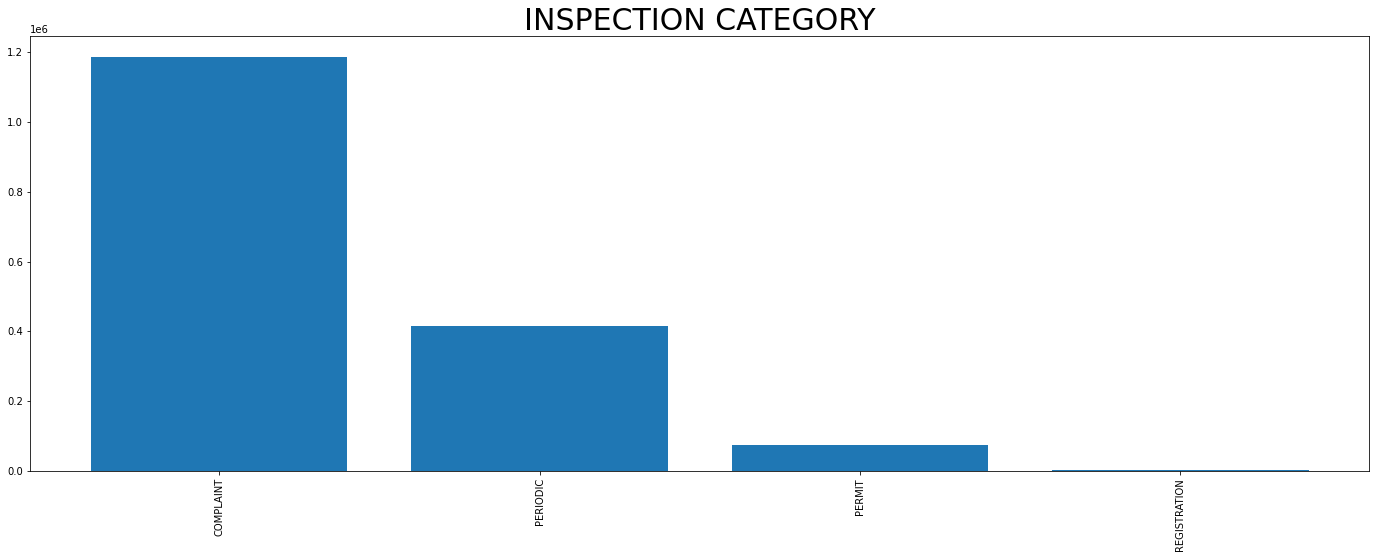

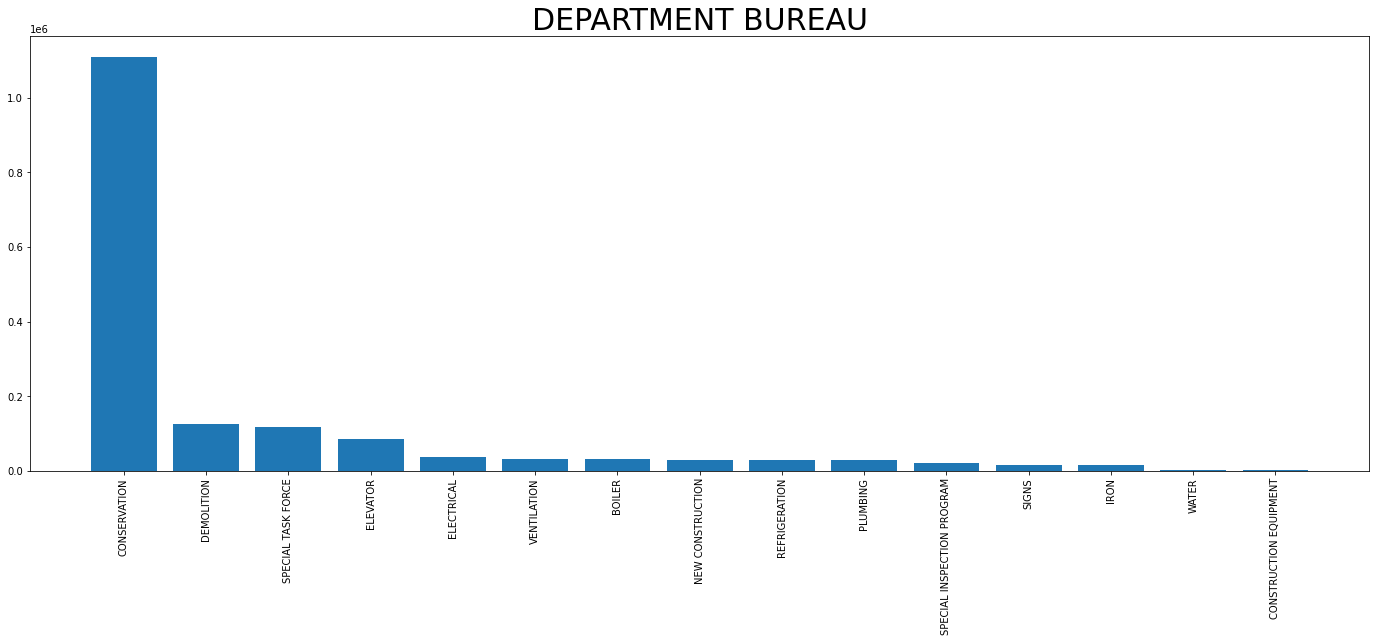

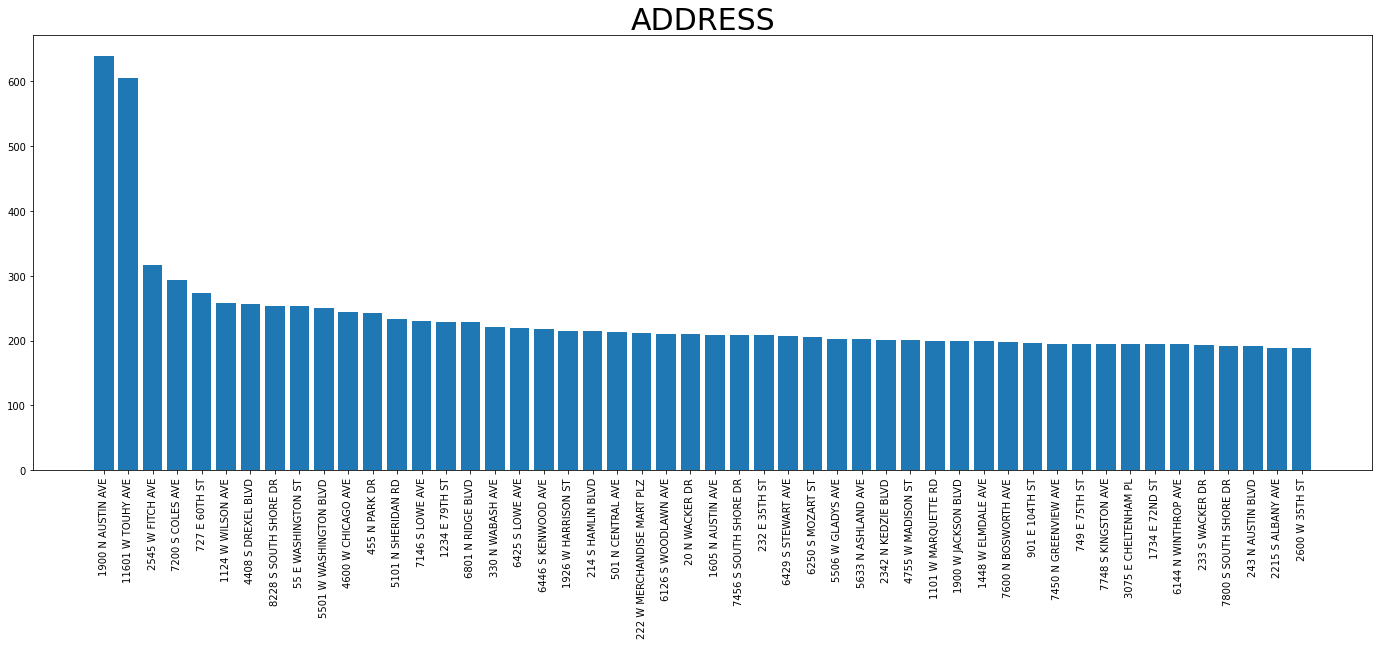

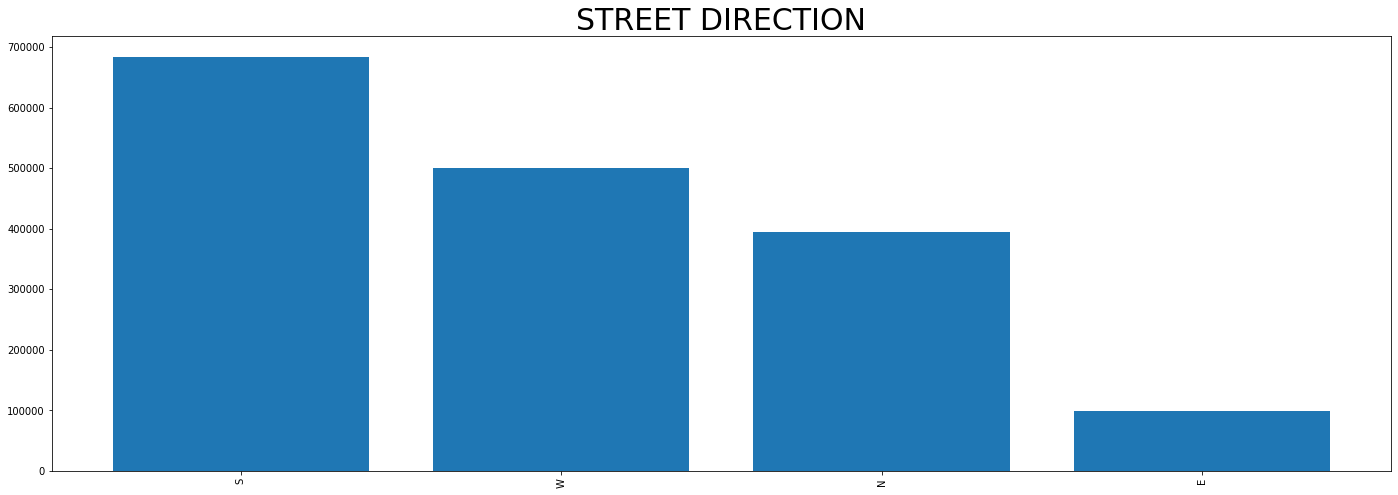

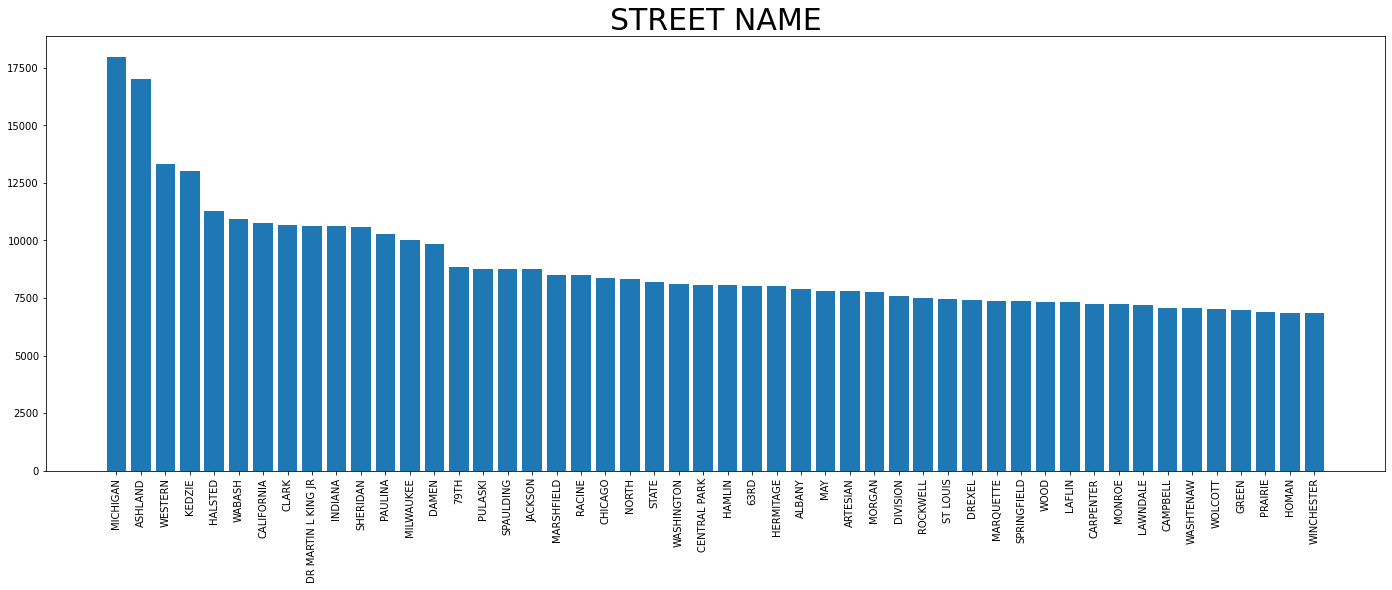

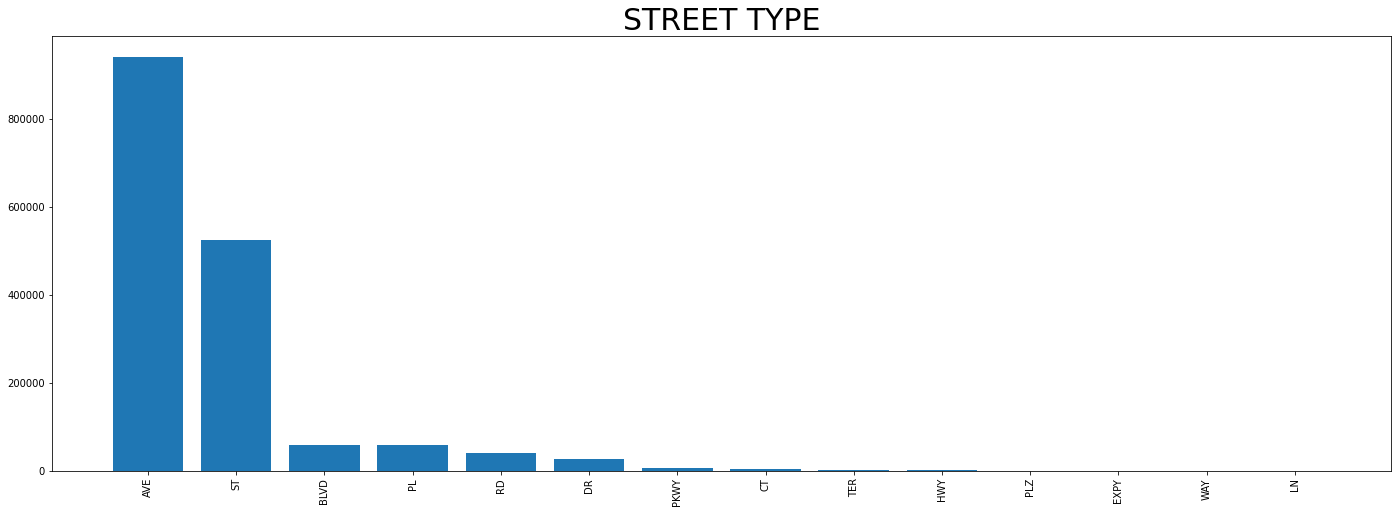

descriptive statistics (INSPECTION NUMBER):
Min: 265575.0000	Q1(25%): 2304416.0000 	Q2(50%): 10418746.0000 	Q3(75%): 11687280.0000 	Max: 13050915.0000
Missing: 0

descriptive statistics (STREET NUMBER):
Min: 1.0000	Q1(25%): 1648.0000 	Q2(50%): 3747.0000 	Q3(75%): 6228.0000 	Max: 13770.0000
Missing: 0

descriptive statistics (PROPERTY GROUP):
Min: 1000.0000	Q1(25%): 20560.0000 	Q2(50%): 154323.0000 	Q3(75%): 366984.0000 	Max: 677975.0000
Missing: 0

descriptive statistics (SSA):
Min: 1.0000	Q1(25%): 22.0000 	Q2(50%): 34.0000 	Q3(75%): 49.0000 	Max: 69.0000
Missing: 1356267

descriptive statistics (LATITUDE):
Min: 41.6447	Q1(25%): 41.7709 	Q2(50%): 41.8540 	Q3(75%): 41.9135 	Max: 42.0227
Missing: 1510

descriptive statistics (LONGITUDE):
Min: -87.9144	Q1(25%): -87.7139 	Q2(50%): -87.6699 	Q3(75%): -87.6329 	Max: -87.5247
Missing: 1510

descriptive statistics (Community Areas):
Min: 1.0000	Q1(25%): 24.0000 	Q2(50%): 36.0000 	Q3(75%): 58.0000 	Max: 77.0000
Missing: 2279

descriptive statis

In [76]:
miss_index=['VIOLATION LOCATION','INSPECTION STATUS','STREET TYPE','SSA',
            'LATITUDE','LONGITUDE','Community Areas','Zip Codes','Boundaries - ZIP Codes',
            'Census Tracts','Wards','Historical Wards 2003-2015' ]
comp_index=[ 'VIOLATION CODE', 'VIOLATION STATUS', 'INSPECTOR ID',
            'INSPECTION CATEGORY','DEPARTMENT BUREAU','ADDRESS','STREET DIRECTION','STREET NAME',
            'INSPECTION NUMBER','STREET NUMBER','PROPERTY GROUP']
attbuilding=attr_corr_fill(building,miss_index=miss_index,complete_index=comp_index)
columns_info(building,show_shape=True,new_df=attbuilding)
nominal_summary(building,nominal_index=nominal_index,head_n=50,new_df=attbuilding)
numerical_summary(building,numerical_index=numerical_index,new_df=attbuilding)

#### 4 通过数据对象之间的相似性来填补缺失值

In [ ]:
objbuilding=obj_corr_fill(building,numerical_index=numerical_index,k=10)
columns_info(building,show_shape=True,new_df=objbuilding)
nominal_summary(building,nominal_index=nominal_index,head_n=50,new_df=objbuilding)
numerical_summary(building,numerical_index=numerical_index,new_df=objbuilding)